# Notes
* This notebook has implementations of `Backprop` with binary spike feature vectors obtained from the `SPIKEFLOW`. Here, we will use tf.data API. Here the shape of the inputs is `[None, n_input]` instead of `[n_input, None]`. We had to do this because nested elements in `from_tensor_slices` must have the same dimension in 0th rank [see](https://stackoverflow.com/questions/49579684/what-is-the-difference-between-dataset-from-tensors-and-dataset-from-tensor-slic). Everytime an iterator `iter = dataset.make_initializable_iterator()` gets initialized, the dataset is randomly shuffled so we need not shuffle again, [see](https://stackoverflow.com/questions/49579684/what-is-the-difference-between-dataset-from-tensors-and-dataset-from-tensor-slic). We also use `z_3 = tf.floor(z_3)`. Surrogate gradients with one step is used. (one sided)

* Here, error in the hidden layer, $\delta^{2}$ is implemented as:
$ \delta^{2} = W^{3T}\delta^{(3)}\odot\sigma^{'}(z^{(2)}) \tag{1}$
* $\sigma^{'}(z^{(2)})$ is approximated with a surrogate. (See section 6)
* It also takes care of catastrophic forgetting by using synaptic intelligence.
* He initialization without AR1 gives lesser final accuracy than Trunc init because in He the gradients don't suffer from dimnishing.
* Here the weight importances are calculated in the first epoch in the disjoint case and first epoch in the 10% data stored case.
* Here each task has a size of 4 classes except for the last task which has 3 classes.
## References
* [Neural Nets](http://neuralnetworksanddeeplearning.com/chap3.html)
* [Randombackprop](https://github.com/xuexue/randombp/blob/master/randombp.py)
* [Randombackprop](https://github.com/sangyi92/feedback_alignment/blob/master/RFA.ipynb)
* [Backprop](http://blog.aloni.org/posts/backprop-with-tensorflow/)
* [Initializers](https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404)
* [Dropout](https://github.com/pinae/TensorFlow-MNIST-example/blob/master/fully-connected.py)
* [Softmax](https://stackoverflow.com/questions/34240703/what-is-logits-softmax-and-softmax-cross-entropy-with-logits)
* [SoftmaxLogits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)
* [TF memory leaks when  assigning in loop](https://github.com/tensorflow/tensorflow/issues/4151)
   

In [2]:
import os, time
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from IPython.display import display, HTML
tf.compat.v2.random.set_seed(0)
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.client import timeline
import h5py, pickle
from keras.utils.np_utils import to_categorical 
import numpy as np
import pandas as pd
import DATA_Loader
import seaborn as sb
import theano, random, sys, time
from sklearn.utils import shuffle

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)
tf

1.14.0


<module 'tensorflow' from '/home/ruthvik/.local/lib/python2.7/site-packages/tensorflow/__init__.pyc'>

# Hide code

In [ ]:
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Plots
* FOR PRETTY IEEE PLOTS mpl.rcParams['figure.figsize'] = 4.5,2.5, all fonts 9-12

## Large

In [4]:
mpl.rcParams['figure.figsize'] = 15,10
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['legend.fontsize'] = 25
mpl.rcParams['font.size'] = 22

## Small

In [5]:
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = 4.5,2.75
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

# Load data

In [6]:
filename = '../../spiking_networks/emnist_train_pool1_acc_cont_spike_features_inh_False_conv1maps_30.h5'
with h5py.File(filename, 'r') as hf:
    emnist_train_images = hf['pool1_spike_features'][:].astype(np.float32)
#@@emnist_train_images[np.where(emnist_train_images>=1)] = 1

filehandle = open('../../spiking_networks/emnist_train_y.pkl','rb')
emnist_train_labels = pickle.load(filehandle).astype(np.float32).tolist()
filehandle.close()
emnist_train_labels = np.array(emnist_train_labels)
print('Total train features:{}'.format(emnist_train_images.shape[0]))

#### LOAD TEST IMAGES AND LABELS
filename = '../../spiking_networks/emnist_test_pool1_acc_cont_spike_features_inh_False_conv1maps_30.h5'
with h5py.File(filename, 'r') as hf:
    emnist_test_images = hf['pool1_spike_features'][:].astype(np.float32)
#@@emnist_test_images[np.where(emnist_test_images>=1)] = 1
print('Total test features:{}'.format(emnist_test_images.shape[0]))

filehandle = open('../../spiking_networks/emnist_test_y.pkl','rb')
emnist_test_labels = pickle.load(filehandle).astype(np.float32)
filehandle.close()
emnist_test_labels = np.array(emnist_test_labels)

#### LOAD TRAIN AND VALIDATION DATA AND LABELS
train_images = emnist_train_images
train_labels = emnist_train_labels
train_labels = np.array(train_labels)
test_images = emnist_test_images
test_labels = emnist_test_labels
num_classes=47

Total train features:112799
Total test features:18800


In [7]:
train_images.max()

12.0

In [8]:
labels_map = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',10:'A',11:'B',12:'C',13:'D',14:'E',15:'F',
              16:'G',17:'H',18:'I',19:'J',20:'K',21:'L',22:'M',23:'N',24:'O',25:'P',26:'Q',27:'R',28:'S',29:'T',30:'U',
             31:'V',32:'W',33:'X',34:'Y',35:'Z',36:'a',37:'b',38:'d',39:'e',40:'f',41:'g',42:'h',43:'n',44:'q',45:'r',
             46:'t'}

In [9]:
BATCH_SIZE = 10
#### EXTRACT REQUIRED LOCATIONS OF 0 TO 5 FOR TRAIN DATA
def extract_class_data(start=0, stop=1):
    set1_locs = np.where((train_labels>=start) & (train_labels<=stop))[0]
    train_labels_set1 = to_categorical(train_labels[set1_locs], num_classes=num_classes)
    train_images_set1 = train_images[set1_locs,:]
    n_images = len(train_images_set1)

    #### EXTRACT REQUIRED LOCATIONS OF 0 TO 5 FOR TEST DATA
    set1_locs = np.where((test_labels>=start) & (test_labels<=stop))[0]
    test_labels_set1 = to_categorical(test_labels[set1_locs], num_classes=num_classes)
    test_images_set1 = test_images[set1_locs,:]
    print('Test features:{}'.format(test_images_set1.shape))
    print('Length of test labels:{}'.format(test_labels_set1.shape[0]))
    test_data_set1 = (test_images_set1, test_labels_set1)
    


    train_images_set1 = train_images_set1[int(0.09*n_images):]
    train_labels_set1 = train_labels_set1[int(0.09*n_images):]
    print('Train features:{}'.format(train_images_set1.shape))
    print('Length of train labels:{}'.format(train_labels_set1.shape[0]))
    train_data_set1 = (train_images_set1, train_labels_set1)

    valid_labels_set1 = train_labels_set1[0:int(0.09*n_images)]
    valid_images_set1 = train_images_set1[0:int(0.09*n_images)]
    print('Valid features:{}'.format(valid_images_set1.shape))
    print('Length of valid labels:{}'.format(valid_labels_set1.shape[0]))
    valid_data_set1 = (valid_images_set1, valid_labels_set1)
    
    n_train_set1 = train_labels_set1.shape[0]
    n_test_set1 = test_labels_set1.shape[0]
    n_valid_set1 = valid_labels_set1.shape[0]

    return train_data_set1, valid_data_set1, test_data_set1

# Start a session

In [10]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess= tf.InteractiveSession(config=config)
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

# Setup the network

In [11]:
n_input = 3630
n_middle = 1500
n_out = 47
batch_size = tf.placeholder(tf.int64, name='batch_size') 
gradient_gate = tf.placeholder(tf.float32, name='gradient_gate') 
a_1 = tf.placeholder(tf.float32, [None, n_input], name = 'Input_batch')
y = tf.placeholder(tf.float32, [None, n_out], name = 'output_batch')
dataset = tf.data.Dataset.from_tensor_slices((a_1, y))
#dataset = dataset.shuffle(buffer_size=len(all_train_labels), reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size)
iter = dataset.make_initializable_iterator()
features, labels = iter.get_next()

drop_out = tf.placeholder(tf.float32)
tau = tf.placeholder(tf.float32)
set1_mask = tf.placeholder(tf.float32, [n_out], name='mask')
eta = tf.placeholder(tf.float32)
n_tot = tf.placeholder(tf.float32)
lmbda = tf.placeholder(tf.float32, name='lambda')
with tf.name_scope('hid_lyr_w_b'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(n_input + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_input + n_middle))
    
    low = -tf.math.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
    high = tf.math.sqrt(2.0/(n_input))
    
    w_2 = tf.Variable(tf.random_uniform(shape=[n_input,n_middle],minval=low,maxval=high), name = 'W_2')
    #w_2 = tf.Variable(tf.truncated_normal(shape=[n_input,n_middle], stddev=0.01),name = 'W_2')
    w_2_update_placeholder = tf.placeholder(w_2.dtype, shape=w_2.get_shape(),name='update_w2')
    w_2_update_op = w_2.assign(w_2_update_placeholder)
    tf.summary.histogram('w_2', w_2)
    
    b_2 = tf.Variable(tf.zeros([1,n_middle]), name = 'b_2')
    b_2_update_placeholder = tf.placeholder(b_2.dtype, shape=b_2.get_shape(),name='update_b2')
    b_2_update_op = b_2.assign(b_2_update_placeholder)
    tf.summary.histogram('b_2', b_2)
    
    
    w2_grad_accum = tf.Variable(np.zeros(shape=[n_input,n_middle], dtype=np.float32),name='w2_grad_accum')
    w2_grad_accum_update_placeholder=tf.placeholder(w2_grad_accum.dtype, shape=w2_grad_accum.get_shape(),
                                            name='update_w2_grad_accum')
    w2_grad_accum_update_op = w2_grad_accum.assign(w2_grad_accum_update_placeholder)
    
    
    b2_grad_accum = tf.Variable(np.zeros(shape=[1,n_middle], dtype=np.float32), name='b2_grad_accum')
    b2_grad_accum_update_placeholder=tf.placeholder(b2_grad_accum.dtype,shape=b2_grad_accum.get_shape(),
                                            name='update_b2_grad_accum')
    b2_grad_accum_update_op = b2_grad_accum.assign(b2_grad_accum_update_placeholder)
    
    
    big_omeg_w2 = tf.Variable(np.zeros(shape=[n_input,n_middle], dtype=np.float32), name='omeg_w2')
    tf.summary.histogram('big_omeg_w2', big_omeg_w2)
    big_omeg_w2_update_placeholder = tf.placeholder(big_omeg_w2.dtype, shape=big_omeg_w2.get_shape(),
                                                    name='update_big_omeg_w2')
    big_omeg_w2_update_op = big_omeg_w2.assign(big_omeg_w2_update_placeholder)
    
    
    big_omeg_b2 = tf.Variable(np.zeros(shape=[1,n_middle], dtype=np.float32), name='omeg_b2')
    tf.summary.histogram('big_omeg_b2', big_omeg_b2)
    big_omeg_b2_update_placeholder = tf.placeholder(big_omeg_b2.dtype, shape=big_omeg_b2.get_shape(),
                                                    name='update_big_omeg_b2')
    big_omeg_b2_update_op = big_omeg_b2.assign(big_omeg_b2_update_placeholder)
    
    
    star_w2 = tf.Variable(np.zeros(shape=[n_input,n_middle], dtype=np.float32), name='star_w2')
    star_w2_update_placeholder = tf.placeholder(star_w2.dtype, shape=star_w2.get_shape(),
                                                name='update_star_w2')
    star_w2_update_op = star_w2.assign(star_w2_update_placeholder)
    
    
    star_b2 = tf.Variable(np.zeros(shape=[1,n_middle], dtype=np.float32), name='star_b2')
    star_b2_update_placeholder = tf.placeholder(star_b2.dtype, shape=star_b2.get_shape(),
                                                name='update_star_b2')
    star_b2_update_op = star_b2.assign(star_b2_update_placeholder)
with tf.name_scope('op_lyr_w_b'):
    
    low = -tf.math.sqrt(2.0/(n_middle))
    high = tf.math.sqrt(2.0/(n_middle))
    #w_3 = tf.Variable(tf.random_uniform(shape=[n_middle,10],minval=low,maxval=high), name = 'W_3')
    #w_3 = tf.Variable(tf.truncated_normal(shape=[n_middle,n_out], stddev=0.01),name = 'W_3')
    w_3 = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32),name = 'W_3')
    tf.summary.histogram('w_3', w_3)
    w_3_update_placeholder = tf.placeholder(w_3.dtype, shape=w_3.get_shape(),name='update_w3')
    w_3_update_op = w_3.assign(w_3_update_placeholder)
    
    b_3 = tf.Variable(tf.zeros([1,n_out]), name = 'b_3')
    tf.summary.histogram('b_3', b_3)
    b_3_update_placeholder = tf.placeholder(b_3.dtype, shape=b_3.get_shape(),name='update_b3')
    b_3_update_op = b_3.assign(b_3_update_placeholder)
    
    w3_grad_accum = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32), name='w3_grad_accum')
    b3_grad_accum = tf.Variable(np.zeros(shape=[1,n_out], dtype=np.float32), name='b3_grad_accum')
    
    big_omeg_w3 = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32), name='omeg_w3')
    tf.summary.histogram('big_omeg_w3', big_omeg_w3)
    big_omeg_b3 = tf.Variable(np.zeros(shape=[1,n_out], dtype=np.float32), name='omeg_b3')
    tf.summary.histogram('big_omeg_b3', big_omeg_b3)
    
    star_w3 = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32), name='star_w3')
    star_b3 = tf.Variable(np.zeros(shape=[1,n_out], dtype=np.float32), name='star_b3')

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
def tanh(x):
    return tf.math.divide(tf.subtract(tf.exp(x), tf.exp(tf.negative(x))), 
                          tf.add(tf.exp(x), tf.exp(tf.negative(x))) )

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

def tanhprime(x):
    return tf.subtract(tf.constant(1.0),tf.square(tanh(x)))

def spkNeuron(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))

def ReLU(x):
    return tf.maximum(0.0, x)

def ReLUprime(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))

def spkPrime1(x):
    l1_bound_higher = tf.greater_equal(x,-0/4)
    r1_bound_lesser = tf.less_equal(x,tau/4) 
    grad_one = tf.where(tf.logical_and(l1_bound_higher,r1_bound_lesser), tf.ones_like(x), tf.zeros_like(x))
    return grad_one

def firstLyrSpks(x):
    return tf.where(tf.greater_equal(x,1.0), tf.ones_like(x), 
                        tf.zeros_like(x))

    
with tf.name_scope('hid_lyr_acti'):
    z_2 = tf.add(tf.matmul(features,w_2,name = 'w_2xa_1'), b_2, name = 'z_2')
    locs_to_drop = tf.random.categorical(tf.math.log([[1.0-drop_out, drop_out]]), tf.size(z_2))
    locs_to_drop = tf.reshape(locs_to_drop, tf.shape(z_2))
    z_2 = tf.where(locs_to_drop>0,-tf.ones_like(z_2),z_2, 'drop_out_app')
    tf.summary.histogram('z_2', z_2)
    a_2 = ReLU(z_2)
    #@@a_2 = spkNeuron(z_2)
    tf.summary.histogram('a_2', a_2)
with tf.name_scope('op_lyr_acti'):
    z_3 = tf.add(tf.matmul(a_2,w_3, name = 'w_3xa_2'),b_3, name = 'z_3')
    #@@z_3 = tf.floor(z_3)
    #z_3 = tf.subtract(tf.reduce_max(z_3),z_3, name = 'inhibition')
    tf.summary.histogram('z_3', z_3)
    a_3 = tf.cast(tf.nn.softmax(z_3,axis=1), tf.float32)
    a_3 = tf.multiply(a_3, set1_mask, name='masking')
    tf.summary.histogram('a_3', a_3)
    ##COMMENT THE ABOVE LINE AND UNCOMMENT BELOW LINE IF YOU WANT SOFTMAX
    #a_3 = tf.nn.softmax(z_3,axis=1) ##AXIS IS VERY IMPORTANT!!! axis=1 INDICATES THE CLASSES AS y IS [None,10]

#cost = tf.reduce_mean(-tf.reduce_sum((y*tf.log(a_3) +tf.log(1-a_3)*(1-y)) ,axis=0), name = 'cost_calc') WORKS, USE BELOW
with tf.name_scope('cost_calc'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels,logits=z_3,axis=1),
                          name = 'cost_calc')#WORKS
        ##COMMENT BELOW LINES IF YOU WANT quadratic
    #@dc_da = tf.multiply(-tf.subtract(labels,a_3, name = 'y_minus_a_3'), mask)
    #@cost = tf.reduce_mean(tf.reduce_sum((1/2.0)*tf.square(dc_da),axis=1), name = 'cost_calc')
    tf.summary.scalar('cost', cost)

with tf.name_scope('op_lyr_grad'):
    #@d_z_3 = tf.multiply(-tf.subtract(labels,a_3, name = 'delta3'), mask, name='masking')
    d_z_3 = -tf.subtract(labels,a_3, name = 'delta3')
    #d_z_3 = tf.multiply(dc_da,a_3, name = 'delta3')
    d_b_3 = tf.expand_dims(tf.reduce_mean(d_z_3, axis=[0]), axis=0)
    tf.summary.histogram('d_b_3', d_b_3)
    d_w_3 = tf.multiply(1/tf.cast(batch_size, tf.float32),
                        tf.matmul(tf.transpose(a_2),d_z_3), 
                        name='delta_w3')
    tf.summary.histogram('d_w_3', d_w_3)
    
with tf.name_scope('hid_lyr_grad'):
    d_z_2 = tf.multiply(tf.matmul(d_z_3,tf.transpose(w_3), name = 'w_3Txdelta3'), ReLUprime(z_2),
                        name = 'delta2')
    #@@d_z_2 = tf.multiply(tf.matmul(d_z_3,tf.transpose(w_3), name = 'w_3Txdelta3'), spkPrime1(z_2),
    #@@                    name = 'delta2')
    #d_z_2 = tf.matmul(d_z_3,tf.transpose(w_3), name = 'delta2')
    d_b_2 = tf.expand_dims(tf.reduce_mean(d_z_2, axis=[0]), axis=0)
    d_b_2 = tf.multiply(gradient_gate, d_b_2, name='gradient_gating_b2')
    tf.summary.histogram('d_b_2', d_b_2)
    d_w_2 = tf.multiply(1/tf.cast(batch_size, tf.float32),
                        tf.matmul(tf.transpose(features),d_z_2), 
                        name='delta_w2')
    d_w_2 = tf.multiply(gradient_gate, d_w_2, name='gradient_gating_w2')
    tf.summary.histogram('d_w_2', d_w_2)
    
omega_step=[tf.assign(w2_grad_accum,
                      tf.add(w2_grad_accum,tf.multiply(eta*eta*lmbda/n_tot, tf.square(d_w_2))),
                     name='update_omeg_w2'),
            tf.assign(b2_grad_accum,
                      tf.add(b2_grad_accum,tf.multiply(eta*eta*lmbda/n_tot,tf.square(d_b_2))),
                     name='update_omeg_b2')
]

step = [tf.assign(w_2,
                  tf.subtract(w_2, (eta*d_w_2+big_omeg_w2*(w_2-star_w2))),name='update_w_2'),
        tf.assign(b_2,
                  tf.subtract(b_2,(eta*d_b_2+big_omeg_b2*(b_2-star_b2))),name='update_b_2'),
        
        tf.assign(w_3,
                  tf.subtract(w_3, (eta*d_w_3+big_omeg_w3*(w_3-star_w3))),name='update_w_3'),
        tf.assign(b_3,
                  tf.subtract(b_3,(eta*d_b_3+big_omeg_b3*(b_3-star_b3))),name='update_b_3')    
]
with tf.name_scope('acc_calc'):
    predictions = tf.argmax(a_3, 1)
    acct_mat = tf.equal(tf.argmax(a_3, 1), tf.argmax(labels, 1))
    acct_res = tf.reduce_mean(tf.cast(acct_mat, tf.float32))
    tf.summary.scalar('accuracy', acct_res)
    
    #test_accuracy_summary = tf.summary.scalar('test_accuracy', acct_res)
    
init_op = tf.global_variables_initializer()

# Init the writer with three best $\lambda$s

In [11]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/emnist/continual_learning/3sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/spike_emnist_ar1_final_v7', sess.graph)

# Generate $\lambda$s

In [12]:
np.random.seed(100)
n_lmbdas = 8
a = np.random.uniform(low=10.0, high=22, size=(n_lmbdas,))
print(a)
print()
a = a*1.0e5
a = a[np.argsort(a)]
#a= a[-3:]
print(a)
print(type(a))
n_reps = 6
a = (a.tolist())*n_reps
#a = ([0]+a.tolist())*n_reps
#n_lmbdas+=1
print(a, len(a))

[16.5208593  13.34043262 15.09421109 20.13731359 10.05662627 11.45882945
 18.04898902 19.91023306]
()
[1005662.62742917 1145882.94493974 1334043.26211256 1509421.10889896
 1652085.93014916 1804898.90167213 1991023.30612606 2013731.35878388]
<type 'numpy.ndarray'>
([1005662.627429167, 1145882.944939737, 1334043.2621125553, 1509421.1088989598, 1652085.9301491582, 1804898.9016721344, 1991023.306126057, 2013731.3587838842, 1005662.627429167, 1145882.944939737, 1334043.2621125553, 1509421.1088989598, 1652085.9301491582, 1804898.9016721344, 1991023.306126057, 2013731.3587838842, 1005662.627429167, 1145882.944939737, 1334043.2621125553, 1509421.1088989598, 1652085.9301491582, 1804898.9016721344, 1991023.306126057, 2013731.3587838842, 1005662.627429167, 1145882.944939737, 1334043.2621125553, 1509421.1088989598, 1652085.9301491582, 1804898.9016721344, 1991023.306126057, 2013731.3587838842, 1005662.627429167, 1145882.944939737, 1334043.2621125553, 1509421.1088989598, 1652085.9301491582, 1804898.

# Generate random weights

In [13]:
lmbdas = a
np.random.seed(0)
np_weights = []
low = -np.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
high = np.sqrt(2.0/(n_input))
for i in range(n_reps):
    np_weights.append(np.random.uniform(low=low,high=high,size=(n_input,n_middle)))

np_weights=[item for item in np_weights for i in range(n_lmbdas)]
print(len(np_weights), len(lmbdas))

(48, 48)


In [14]:
np.array_equal(np_weights[0], np_weights[7])

True

In [15]:
np.array_equal(np_weights[0], np_weights[8])

False

In [16]:
np.array_equal(np_weights[8], np_weights[10])

True

# Splitting the dataset into tasks

In [17]:
print(labels_map)

task_splits = np.array_split(np.arange(num_classes), num_classes/4-1)

task_splits = [(item.tolist()[0], item.tolist()[-1]) for item in task_splits]
task_splits



{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}


[(0, 4),
 (5, 9),
 (10, 14),
 (15, 19),
 (20, 24),
 (25, 29),
 (30, 34),
 (35, 38),
 (39, 42),
 (43, 46)]

# Commence training

In [18]:
START_TIME = time.time()
method3_test_accs = []
#INITIALIZE THE NETWORK
logging_count = 0
sess.run(init_op,options=run_options, run_metadata=run_metadata)
sess.graph.finalize()
all_prev_task_test_accs = []
all_prev_task_test_activs = []
for l in range(len(lmbdas)):
    print('Training with lmbda:{}, {}'.format(lmbdas[l], l))
    #sess.run(init_op,options=run_options, run_metadata=run_metadata)
    zeta = 1e-3
    new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
    w3_zeros = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    b3_zeros = np.zeros(shape=[1,n_out], dtype=np.float32)
    w3_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    w3_accum = []
    b3_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    b3_accum = []
    reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)

    start_w2 = None
    start_b2 = None
    sess.run(w_2_update_op, {w_2_update_placeholder:np_weights[l]})
    sess.run(b_2_update_op, {b_2_update_placeholder:np.zeros(shape=[1,n_middle],dtype=np.float32)})
    end_w2 = None
    end_b2 = None

    old_test_data = []
    frac_old_train_images = []
    frac_old_train_labels = []
    historical_cross_test_acc = {}
    historical_train_accuracies = {}
    historical_train_costs = {}
    historical_val_accuracies = {}
    historical_val_costs = {}
    sets = np.array_split(range(num_classes), int(num_classes/2))
    sets = [tuple(item.tolist()) for item in sets]
    sets = [(0, 9), (10, 35), (36, 46)]
    sets = task_splits
    test_labels_set = []
    prev_task_test_accs = []
    prev_task_test_activs = []
    n_test_samples = []
    for a_set in range(len(sets)):
        current_set = sets[a_set]
        current_set_name = 'set'+str(a_set)
        mask_val = [0]*num_classes
        for i in range(0, current_set[1]+1):
            mask_val[i]=1
        set_mask_val = np.array(mask_val, dtype=np.float32)
        print('Current mask:{}'.format(set_mask_val))
        train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                      stop=current_set[1])
        train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
        valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
        test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
        n_test_samples.append(len(test_labels_set))
        train_total = len(train_images_set)
        n_batches = len(train_images_set)/BATCH_SIZE
        #@@print('Number of batches:{}'.format(n_batches))


        #@@set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2)]
        #@@sess.run(set_omegas)
        
        sess.run(big_omeg_w2_update_op, {big_omeg_w2_update_placeholder:new_big_omeg_w2})
        sess.run(big_omeg_b2_update_op, {big_omeg_b2_update_placeholder:new_big_omeg_b2})

        #@@reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
        #@@                     tf.assign(b2_grad_accum, reset_b2_grad_accum)]
        #@@sess.run(reset_grad_accums)
        
        sess.run(w2_grad_accum_update_op, {w2_grad_accum_update_placeholder:reset_w2_grad_accum})
        sess.run(b2_grad_accum_update_op, {b2_grad_accum_update_placeholder:reset_b2_grad_accum})

        
        #@@reset_w3 = [tf.assign(w_3, w3_zeros), tf.assign(b_3, b3_zeros)]
        #@@sess.run(reset_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:w3_zeros})
        sess.run(b_3_update_op, {b_3_update_placeholder:b3_zeros})
    
        epochs = 20
        repeats = 1

        for repeat in range(repeats):
            #tf.set_random_seed(l)
            print('Repeat:{}'.format(repeat))
            train_accuracies = []
            train_costs = []
            val_accuracies = []
            val_costs = []
            best_val = 0
            first_params_set = None
            last_params_set = None
            T1 = time.time()
            for i in range(epochs):
                if(i==epochs-1):
                    start_w2, start_b2 = w_2.eval(), b_2.eval()
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: len(train_images_set)})
                #@@print('Epoch:{}'.format((i)))
                t1 = time.time()

                ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
                train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                     set1_mask:set_mask_val})
                train_costs.append(train_cost)
                train_accuracies.append(train_accuracy)
                #train_writer.add_summary(summary,logging_count)

                print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

                ### CALCULATE VALID COSTS AND VALID ACCURACIES
                sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                      batch_size: len(valid_images_set)})
                _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
                val_costs.append(val_cost)
                val_accuracies.append(val_acc)

                if(val_acc>best_val):
                    best_val = val_acc
                    best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
                print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: BATCH_SIZE})


                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: BATCH_SIZE})
                print('Training on :{}'.format(current_set))
                for j in range(n_batches):

                    if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                        #if(a_set==1):
                        #    print(j, w_2.eval().sum(), w_3.eval().sum())
                        if(((j)% 1000 ==0)):
                            logging_count+=1
                            if(i==0):   
                                summary,_,_ = sess.run([merged,step, omega_step], 
                                                     feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                                  set1_mask:set_mask_val,eta:0.001,
                                                                  lmbda:lmbdas[l],n_tot:train_total,
                                                                 gradient_gate:1})
                            else:
                                summary,_, = sess.run([merged,step], 
                                                     feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                                  set1_mask:set_mask_val,eta:0.001,
                                                                  lmbda:lmbdas[l],n_tot:train_total,
                                                                 gradient_gate:1})
                            #train_writer.add_summary(summary, (i+1)*j)
                            train_writer.add_summary(summary, logging_count)
                        else:
                            if(i==0):
                                sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                         tau:0.5,set1_mask:set_mask_val,
                                                                         eta:0.001,lmbda:lmbdas[l],
                                                                         n_tot:train_total,
                                                                         gradient_gate:1})
                            else:
                                sess.run([step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                     tau:0.5,set1_mask:set_mask_val,
                                                                     eta:0.001,lmbda:lmbdas[l],
                                                                     n_tot:train_total,
                                                            gradient_gate:1})
                    else:
                        print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
                #@@print('Epoch time:{}'.format(time.time()-t1))


            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                                  feed_dict = {drop_out:0.0, 
                                                                               set1_mask:set_mask_val})
            #@@print('Final test accuracy is:{}'.format(final_test_acc))
            end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
            #@@sess.run(update_star_wbs)
            sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
            sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
            
            
            #all_final_test_accs_set1.append(final_test_acc)


            #@@best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
            #@@             tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
            #@@sess.run(best_step)
            
            sess.run(w_2_update_op, {w_2_update_placeholder:best_params_set1[0][0]})
            sess.run(b_2_update_op, {b_2_update_placeholder:best_params_set1[0][1]})
            
            sess.run(w_3_update_op, {w_3_update_placeholder:best_params_set1[1][0]})
            sess.run(b_3_update_op, {b_3_update_placeholder:best_params_set1[1][1]})
            
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                     feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

            #@@print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
            print('Time taken:{}'.format(time.time()-T1))
            #w3_list.append(w_3.eval())
            w3_accum.append(w_3.eval())
            #b3_list.append(b_3.eval())
            b3_accum.append(b_3.eval())
            if(i==epochs-1):
                if(test_acc_corresp_best_val>final_test_acc):
                    end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                    #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                    #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
                    #@@sess.run(update_star_wbs)
                    
                    sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
                    sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
                    

                #@@best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                #@@         tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
                #@@sess.run(best_step)
                
                
                sess.run(w_2_update_op, {w_2_update_placeholder:end_w2})
                sess.run(b_2_update_op, {b_2_update_placeholder:end_b2})
                
                sess.run(w_3_update_op, {w_3_update_placeholder:end_w3})
                sess.run(b_3_update_op, {b_3_update_placeholder:end_b3})

                first_params_set = [(start_w2, start_b2)]
                last_params_set = [(end_w2, end_b2)]

                small_omegas = [(w2_grad_accum.eval(),b2_grad_accum.eval())]

                delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                           [item[0] for item in first_params_set])

                delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                           [item[1] for item in first_params_set])
                delta_wbs = zip(delta_ws, delta_bs)

                big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                           [item[0] for item in delta_wbs])            
                big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                           [item[1] for item in delta_wbs])

                big_omegas = zip(big_omegas_ws, big_omegas_bs)
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                #@@print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                #@@                                                new_big_omeg_w2.mean(),
                #@@                                                new_big_omeg_w2.std()))
                #@@print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                #@@                                                new_big_omeg_b2.mean(),
                #@@                                                new_big_omeg_b2.std()))

        historical_train_accuracies[current_set_name]=train_accuracies
        historical_train_costs[current_set_name]=train_costs
        historical_val_accuracies[current_set_name]=val_accuracies
        historical_val_costs[current_set_name]=val_costs
        
        old_test_data.append(test_data_set)
        #######Method 3 ###########
        w3_set_rows = []
        offset=0
        #for item in w3_accum:
        #    w3_set_rows.append(item[:,offset:offset+2])
        #    offset+=2
        for v in range(len(w3_accum)):
            current_set = sets[v]
            w3_set_rows.append(w3_accum[v][:,offset:offset+(current_set[1]-current_set[0]+1)])
            offset+=current_set[1]-current_set[0]+1


        w3_set_row_avgs = [item.mean() for item in w3_set_rows]
        final_w3 = map(lambda x,y:x-y,w3_set_rows, w3_set_row_avgs)
        #final_w3 = np.concatenate(final_w3, axis=1)
        final_w3 = np.concatenate([item for item in final_w3]+[np.zeros((1500,n_out-offset))], axis=1)
        
        b3_set_rows = []
        offset=0
        #for item in b3_accum:
        #    b3_set_rows.append(item[:,offset:offset+2])
        #    offset+=2
        for v in range(len(b3_accum)):
            current_set = sets[v]
            b3_set_rows.append(b3_accum[v][:,offset:offset+(current_set[1]-current_set[0]+1)])
            offset+=current_set[1]-current_set[0]+1
            
        b3_set_row_avgs = [item.mean() for item in b3_set_rows]
        final_b3 = map(lambda x,y:x-y,b3_set_rows, b3_set_row_avgs)
        #final_b3 = np.concatenate(final_b3, axis=1)
        final_b3 = np.concatenate([item for item in final_b3]+[np.zeros((1,n_out-offset))], axis=1)
        
        #@@set_w3 = [tf.assign(w_3, final_w3), tf.assign(b_3, final_b3)]
        #@@sess.run(set_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:final_w3})
        sess.run(b_3_update_op, {b_3_update_placeholder:final_b3})
        
        for items in old_test_data:
            test_images_set, test_labels_set = items[0], items[1]
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, 
                                                  y:test_labels_set,
                                                  batch_size: len(test_images_set)})
            _,final_test_acc,final_test_activ = sess.run([predictions, acct_res, a_3],
                                      feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
            prev_task_test_accs.append(final_test_acc)
            prev_task_test_activs.append(final_test_activ)
            print('Method 3 test accuracy:{}'.format(final_test_acc))
    
    all_prev_task_test_accs.append(prev_task_test_accs)
    all_prev_task_test_activs.append(prev_task_test_activs)
    #sys.exit()
    
train_writer.close()
print('Total time:{}'.format(time.time()-START_TIME))

Training with lmbda:1005662.62743, 0
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.20045787096
validation cost:3.85014748573 and validation accuracy:0.183333337307
Training on :(0, 4)
training cost:0.0648179203272 and training accuracy:0.986263751984
validation cost:0.061288446188 and validation accuracy:0.98425924778
Training on :(0, 4)
training cost:0.0365205183625 and training accuracy:0.992582440376
validation cost:0.0333814546466 and validation accuracy:0.991666674614
Training on :(0, 4)
training cost:0.0237346682698 and training accuracy:0.996611714363
validation cost:0.0210521202534 and validation accuracy:0.996296286583
Training on :(0, 4)
trai

Training on :(10, 14)
training cost:0.0192798692733 and training accuracy:0.999358952045
validation cost:0.0263390392065 and validation accuracy:0.99722224474
Training on :(10, 14)
training cost:0.0173503048718 and training accuracy:0.999542117119
validation cost:0.0237089805305 and validation accuracy:0.998148143291
Training on :(10, 14)
training cost:0.0157953482121 and training accuracy:0.999725282192
validation cost:0.0215583797544 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0145209040493 and training accuracy:0.999725282192
validation cost:0.0197771284729 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0134593974799 and training accuracy:0.999816834927
validation cost:0.018278228119 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0125630050898 and training accuracy:0.999908447266
validation cost:0.0170039981604 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0117956837639 and training accuracy:0.9999084472

Training on :(20, 24)
training cost:0.0132449856028 and training accuracy:0.999450564384
validation cost:0.0150728421286 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0125276688486 and training accuracy:0.999450564384
validation cost:0.0142500260845 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0118964090943 and training accuracy:0.999633669853
validation cost:0.0135272033513 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0113329794258 and training accuracy:0.999816834927
validation cost:0.012878571637 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0108260521665 and training accuracy:0.999816834927
validation cost:0.0123035497963 and validation accuracy:1.0
Training on :(20, 24)
Time taken:277.620317936
Method 3 test accuracy:0.699999988079
Method 3 test accuracy:0.863499999046
Method 3 test accuracy:0.801999986172
Method 3 test accuracy:0.71850001812
Method 3 test accuracy:0.

Time taken:278.54076004
Method 3 test accuracy:0.628499984741
Method 3 test accuracy:0.745999991894
Method 3 test accuracy:0.740999996662
Method 3 test accuracy:0.680999994278
Method 3 test accuracy:0.586499989033
Method 3 test accuracy:0.722000002861
Method 3 test accuracy:0.730000019073
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(863, 3630)
Length of valid labels:863
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014796257 and validation accuracy:0.0
Training on :(35, 38)
training cost:0.0853985771537 and training accuracy:0.979853451252
validation cost:0.0956195443869 and validation accuracy:0.974507510662
Training on :(35, 38)
training cost:0.0611112266779 and training accuracy:0.985805869102
validation cost:0.0

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(43, 46)
training cost:0.122053742409 and training accuracy:0.971955120564
validation cost:0.137384533882 and validation accuracy:0.965277791023
Training on :(43, 46)
training cost:0.0880883708596 and training accuracy:0.980883717537
validation cost:0.103031381965 and validation accuracy:0.97685188055
Training on :(43, 46)
training cost:0.0718559399247 and training accuracy:0.984775662422
validation cost:0.0860525742173 and validation accuracy:0.981481492519
Training on :(43, 46)
training cost:0.0614513270557 and training accuracy:0.986721634865
validation cost:0.074615560472 and validation accuracy:0.983796298504
Training on :(43, 46)
training cost:0.0539009720087 and training accuracy:0.989239931107
validation cost:0.0658586099744 and validation accuracy:0.986111104488
Training on :(43, 46)
training cost:0.0480561442673 and training accuracy:0.991529285908
vali

Training on :(5, 9)
training cost:0.0163226220757 and training accuracy:0.999633669853
validation cost:0.0193829834461 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0143141634762 and training accuracy:0.999633669853
validation cost:0.0168553739786 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0127403121442 and training accuracy:0.999725282192
validation cost:0.0148574598134 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.011483325623 and training accuracy:0.999725282192
validation cost:0.0132656153291 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0104671670124 and training accuracy:0.999725282192
validation cost:0.0119929173961 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00963369756937 and training accuracy:0.999816834927
validation cost:0.0109658837318 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00894260033965 a

Training on :(15, 19)
training cost:0.020191218704 and training accuracy:0.998992681503
validation cost:0.0267670229077 and validation accuracy:0.996296286583
Training on :(15, 19)
training cost:0.0189779140055 and training accuracy:0.999358952045
validation cost:0.0250880774111 and validation accuracy:0.99722224474
Training on :(15, 19)
training cost:0.0179052688181 and training accuracy:0.999450564384
validation cost:0.0236169788986 and validation accuracy:0.99722224474
Training on :(15, 19)
training cost:0.0169555731118 and training accuracy:0.999542117119
validation cost:0.0223086904734 and validation accuracy:0.998148143291
Training on :(15, 19)
training cost:0.0161064397544 and training accuracy:0.999633669853
validation cost:0.0211394224316 and validation accuracy:0.999074101448
Training on :(15, 19)
Time taken:276.894459963
Method 3 test accuracy:0.793500006199
Method 3 test accuracy:0.869000017643
Method 3 test accuracy:0.820500016212
Method 3 test accuracy:0.736999988556
Curr

Method 3 test accuracy:0.804499983788
Method 3 test accuracy:0.712000012398
Method 3 test accuracy:0.649500012398
Method 3 test accuracy:0.752499997616
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(30, 34)
training cost:0.194364726543 and training accuracy:0.944780230522
validation cost:0.179827168584 and validation accuracy:0.954629600048
Training on :(30, 34)
training cost:0.147655203938 and training accuracy:0.957967042923
validation cost:0.135804980993 and validation accuracy:0.960185170174
Training on :(30, 34)
training cost:0.122347429395 and training accuracy:0.96611720323

training cost:0.0941057056189 and training accuracy:0.979395627975
validation cost:0.103126578033 and validation accuracy:0.973379611969
Training on :(39, 42)
training cost:0.0672717094421 and training accuracy:0.98592031002
validation cost:0.0788785368204 and validation accuracy:0.979166686535
Training on :(39, 42)
training cost:0.0540657900274 and training accuracy:0.989926755428
validation cost:0.0657969787717 and validation accuracy:0.983796298504
Training on :(39, 42)
training cost:0.0456099063158 and training accuracy:0.99164378643
validation cost:0.0567598491907 and validation accuracy:0.987268507481
Training on :(39, 42)
training cost:0.039585608989 and training accuracy:0.993131875992
validation cost:0.0499304123223 and validation accuracy:0.987268507481
Training on :(39, 42)
training cost:0.035035431385 and training accuracy:0.994734406471
validation cost:0.0445105172694 and validation accuracy:0.988425910473
Training on :(39, 42)
training cost:0.0314526446164 and training ac

Training on :(0, 4)
training cost:0.0165944229811 and training accuracy:0.998534798622
validation cost:0.0144818034023 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0121941203251 and training accuracy:0.999358952045
validation cost:0.010662808083 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0093383770436 and training accuracy:0.999542117119
validation cost:0.00829836912453 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00742981024086 and training accuracy:0.999908447266
validation cost:0.00674580596387 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00610721157864 and training accuracy:0.999908447266
validation cost:0.00564641179517 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00515504181385 and training accuracy:1.0
validation cost:0.00482049351558 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00444224802777 and training accuracy:1.0
validation cost:0.00417770119384 and validatio

Training on :(10, 14)
training cost:0.0127912750468 and training accuracy:0.999908447266
validation cost:0.0173972435296 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0120675917715 and training accuracy:0.999908447266
validation cost:0.0163628663868 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0114312106743 and training accuracy:0.999908447266
validation cost:0.0154514899477 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0108699547127 and training accuracy:1.0
validation cost:0.0146452402696 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0103671727702 and training accuracy:1.0
validation cost:0.013925274834 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00991716235876 and training accuracy:1.0
validation cost:0.0132808685303 and validation accuracy:1.0
Training on :(10, 14)
Time taken:277.243124008
Method 3 test accuracy:0.867999970913
Method 3 test accuracy:0.912500023842
Method 3 test ac

Method 3 test accuracy:0.814499974251
Method 3 test accuracy:0.728500008583
Method 3 test accuracy:0.597500026226
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.089622117579 and training accuracy:0.980311334133
validation cost:0.094582028687 and validation accuracy:0.975000023842
Training on :(25, 29)
training cost:0.0611208304763 and training accuracy:0.987362623215
validation cost:0.0668535456061 and validation accuracy:0.982407391071
Training on :(25, 29)
training cost:0.0472583696246 and training accuracy:0.991300344467
validation cost:0.0524160191417 a

Training on :(35, 38)
training cost:0.0634457394481 and training accuracy:0.985347986221
validation cost:0.0726969987154 and validation accuracy:0.983777523041
Training on :(35, 38)
training cost:0.0511288382113 and training accuracy:0.988553106785
validation cost:0.0592502132058 and validation accuracy:0.986095011234
Training on :(35, 38)
training cost:0.0431386232376 and training accuracy:0.991758227348
validation cost:0.0501725785434 and validation accuracy:0.989571273327
Training on :(35, 38)
training cost:0.0373873338103 and training accuracy:0.993017375469
validation cost:0.0434278808534 and validation accuracy:0.990729987621
Training on :(35, 38)
training cost:0.0329951681197 and training accuracy:0.994162082672
validation cost:0.0381491705775 and validation accuracy:0.99188876152
Training on :(35, 38)
training cost:0.0295151788741 and training accuracy:0.995764672756
validation cost:0.0339110903442 and validation accuracy:0.994206249714
Training on :(35, 38)
training cost:0.026

Training on :(43, 46)
training cost:0.0511863492429 and training accuracy:0.99061357975
validation cost:0.0623074956238 and validation accuracy:0.987268507481
Training on :(43, 46)
training cost:0.0463400520384 and training accuracy:0.991758227348
validation cost:0.0562933422625 and validation accuracy:0.987268507481
Training on :(43, 46)
training cost:0.0423139855266 and training accuracy:0.992788434029
validation cost:0.0511680543423 and validation accuracy:0.988425910473
Training on :(43, 46)
training cost:0.038919236511 and training accuracy:0.99347525835
validation cost:0.0468100346625 and validation accuracy:0.990740716457
Training on :(43, 46)
training cost:0.0360061116517 and training accuracy:0.994047641754
validation cost:0.0430362559855 and validation accuracy:0.990740716457
Training on :(43, 46)
training cost:0.0334736928344 and training accuracy:0.994848906994
validation cost:0.0397918373346 and validation accuracy:0.993055582047
Training on :(43, 46)
training cost:0.03126

Training on :(5, 9)
training cost:0.00959999766201 and training accuracy:0.999816834927
validation cost:0.0109350346029 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00897482596338 and training accuracy:0.999908447266
validation cost:0.0101797049865 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00843874551356 and training accuracy:1.0
validation cost:0.00954488944262 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00797321461141 and training accuracy:1.0
validation cost:0.0089956196025 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00756531162187 and training accuracy:1.0
validation cost:0.00851769931614 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00720394542441 and training accuracy:1.0
validation cost:0.00809910427779 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00688037043437 and training accuracy:1.0
validation cost:0.00772595498711 and validation accuracy:1.0
Trai

Method 3 test accuracy:0.833999991417
Method 3 test accuracy:0.698499977589
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(20, 24)
training cost:0.093363776803 and training accuracy:0.981776535511
validation cost:0.112137325108 and validation accuracy:0.972222208977
Training on :(20, 24)
training cost:0.0636535212398 and training accuracy:0.988553106785
validation cost:0.0763296112418 and validation accuracy:0.980555534363
Training on :(20, 24)
training cost:0.0499910339713 and training accuracy:0.991300344467
validation cost:0.0595161728561 and validation accuracy:0.98425924778
T

Training on :(30, 34)
training cost:0.127535402775 and training accuracy:0.964194118977
validation cost:0.116472177207 and validation accuracy:0.965740740299
Training on :(30, 34)
training cost:0.110225714743 and training accuracy:0.96978020668
validation cost:0.100557625294 and validation accuracy:0.967592597008
Training on :(30, 34)
training cost:0.097192004323 and training accuracy:0.973626375198
validation cost:0.088794618845 and validation accuracy:0.971296310425
Training on :(30, 34)
training cost:0.0868858024478 and training accuracy:0.97710621357
validation cost:0.0797049179673 and validation accuracy:0.979629635811
Training on :(30, 34)
training cost:0.0785303115845 and training accuracy:0.979761898518
validation cost:0.0724825784564 and validation accuracy:0.986111104488
Training on :(30, 34)
training cost:0.0715990811586 and training accuracy:0.982417583466
validation cost:0.0666015893221 and validation accuracy:0.987962961197
Training on :(30, 34)
training cost:0.0657591521

Training on :(39, 42)
training cost:0.0333506129682 and training accuracy:0.995077848434
validation cost:0.0422391407192 and validation accuracy:0.988425910473
Training on :(39, 42)
training cost:0.0303391888738 and training accuracy:0.995764672756
validation cost:0.0384769365191 and validation accuracy:0.989583313465
Training on :(39, 42)
training cost:0.027831075713 and training accuracy:0.996222555637
validation cost:0.0352711975574 and validation accuracy:0.989583313465
Training on :(39, 42)
training cost:0.0257021859288 and training accuracy:0.996680378914
validation cost:0.0325152464211 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.0238715782762 and training accuracy:0.997481703758
validation cost:0.0301233548671 and validation accuracy:0.993055582047
Training on :(39, 42)
training cost:0.0222780834883 and training accuracy:0.997825086117
validation cost:0.0280361901969 and validation accuracy:0.993055582047
Training on :(39, 42)
training cost:0.0208

training cost:0.00444224802777 and training accuracy:1.0
validation cost:0.00417770119384 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00389003870077 and training accuracy:1.0
validation cost:0.00366651266813 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00345107656904 and training accuracy:1.0
validation cost:0.00325590535067 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00309458328411 and training accuracy:1.0
validation cost:0.00291888648644 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0027997365687 and training accuracy:1.0
validation cost:0.00263868784532 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00255221896805 and training accuracy:1.0
validation cost:0.00240241899155 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00234182691202 and training accuracy:1.0
validation cost:0.00220151781105 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.002161038341 and tr

Training on :(10, 14)
Time taken:277.820141792
Method 3 test accuracy:0.860499978065
Method 3 test accuracy:0.90649998188
Method 3 test accuracy:0.89200001955
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(15, 19)
training cost:0.130757451057 and training accuracy:0.965476214886
validation cost:0.148894578218 and validation accuracy:0.954629600048
Training on :(15, 19)
training cost:0.0953159108758 and training accuracy:0.975732624531
validation cost:0.111454196274 and validation accuracy:0.970370352268
Training on :(15, 19)
training cost:0.0770917385817 and training accuracy:0.98

Training on :(25, 29)
training cost:0.0489832162857 and training accuracy:0.990934073925
validation cost:0.0542400367558 and validation accuracy:0.987037062645
Training on :(25, 29)
training cost:0.0402235239744 and training accuracy:0.993223428726
validation cost:0.0448237136006 and validation accuracy:0.988888859749
Training on :(25, 29)
training cost:0.0341164581478 and training accuracy:0.994322359562
validation cost:0.0381133966148 and validation accuracy:0.990740716457
Training on :(25, 29)
training cost:0.0295909289271 and training accuracy:0.995879113674
validation cost:0.0330833531916 and validation accuracy:0.991666674614
Training on :(25, 29)
training cost:0.0261167194694 and training accuracy:0.996520161629
validation cost:0.0291943512857 and validation accuracy:0.991666674614
Training on :(25, 29)
training cost:0.0233663599938 and training accuracy:0.99761903286
validation cost:0.0261060893536 and validation accuracy:0.992592573166
Training on :(25, 29)
training cost:0.021

Training on :(35, 38)
training cost:0.0278269797564 and training accuracy:0.996451437473
validation cost:0.0318216942251 and validation accuracy:0.994206249714
Training on :(35, 38)
training cost:0.0254093389958 and training accuracy:0.997252762318
validation cost:0.0288773775101 and validation accuracy:0.995365023613
Training on :(35, 38)
training cost:0.0233591478318 and training accuracy:0.997481703758
validation cost:0.0264138672501 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0215945262462 and training accuracy:0.997710645199
validation cost:0.0243323165923 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0200610030442 and training accuracy:0.997939586639
validation cost:0.0225588362664 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0187178421766 and training accuracy:0.998282968998
validation cost:0.0210333969444 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.01

Training on :(43, 46)
training cost:0.0329625532031 and training accuracy:0.995421230793
validation cost:0.0387369133532 and validation accuracy:0.993055582047
Training on :(43, 46)
training cost:0.0309367794544 and training accuracy:0.995650172234
validation cost:0.0361871384084 and validation accuracy:0.994212985039
Training on :(43, 46)
training cost:0.029126258567 and training accuracy:0.996222555637
validation cost:0.0339333862066 and validation accuracy:0.994212985039
Training on :(43, 46)
training cost:0.0275083836168 and training accuracy:0.997023820877
validation cost:0.0319357924163 and validation accuracy:0.995370388031
Training on :(43, 46)
training cost:0.0260489378124 and training accuracy:0.997252762318
validation cost:0.0301524307579 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.0247265603393 and training accuracy:0.997596144676
validation cost:0.0285614337772 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.023

Training on :(5, 9)
training cost:0.0072042257525 and training accuracy:1.0
validation cost:0.00811398308724 and validation accuracy:1.0
Training on :(5, 9)
Time taken:277.946994066
Method 3 test accuracy:0.943000018597
Method 3 test accuracy:0.945999979973
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0980005711317 and training accuracy:0.97829669714
validation cost:0.118114806712 and validation accuracy:0.964814841747
Training on :(10, 14)
training cost:0.0646518021822 and training accuracy:0.986904740334
validation cost:0.082140982151 and validation acc

Training on :(20, 24)
training cost:0.0512066073716 and training accuracy:0.991300344467
validation cost:0.0610545836389 and validation accuracy:0.98425924778
Training on :(20, 24)
training cost:0.0427182167768 and training accuracy:0.9934065938
validation cost:0.0506760552526 and validation accuracy:0.990740716457
Training on :(20, 24)
training cost:0.0367959886789 and training accuracy:0.995054960251
validation cost:0.0435259491205 and validation accuracy:0.992592573166
Training on :(20, 24)
training cost:0.032362241298 and training accuracy:0.996153831482
validation cost:0.0382181294262 and validation accuracy:0.995370388031
Training on :(20, 24)
training cost:0.0288862567395 and training accuracy:0.996611714363
validation cost:0.0340735577047 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0260724406689 and training accuracy:0.996794879436
validation cost:0.0307072140276 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.023738

Training on :(30, 34)
training cost:0.0746712237597 and training accuracy:0.981135547161
validation cost:0.0690737292171 and validation accuracy:0.987962961197
Training on :(30, 34)
training cost:0.0687952041626 and training accuracy:0.983974337578
validation cost:0.0641330555081 and validation accuracy:0.988888859749
Training on :(30, 34)
training cost:0.0637791976333 and training accuracy:0.986446857452
validation cost:0.0599814467132 and validation accuracy:0.990740716457
Training on :(30, 34)
training cost:0.0594190433621 and training accuracy:0.988095223904
validation cost:0.0564294680953 and validation accuracy:0.991666674614
Training on :(30, 34)
training cost:0.0556053817272 and training accuracy:0.989926755428
validation cost:0.0532993637025 and validation accuracy:0.992592573166
Training on :(30, 34)
training cost:0.052293535322 and training accuracy:0.991117238998
validation cost:0.0505925640464 and validation accuracy:0.993518531322
Training on :(30, 34)
training cost:0.049

Training on :(39, 42)
training cost:0.0230774618685 and training accuracy:0.997596144676
validation cost:0.0290276799351 and validation accuracy:0.993055582047
Training on :(39, 42)
training cost:0.0216376353055 and training accuracy:0.998168468475
validation cost:0.0271440297365 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0203631650656 and training accuracy:0.998397409916
validation cost:0.0254790820181 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0192251447588 and training accuracy:0.998626351357
validation cost:0.0239984672517 and validation accuracy:0.996527791023
Training on :(39, 42)
training cost:0.0182061716914 and training accuracy:0.998855292797
validation cost:0.0226747374982 and validation accuracy:0.997685194016
Training on :(39, 42)
training cost:0.0172864478081 and training accuracy:0.999084234238
validation cost:0.0214888770133 and validation accuracy:0.997685194016
Training on :(39, 42)
training cost:0.01

Training on :(0, 4)
training cost:0.00234182691202 and training accuracy:1.0
validation cost:0.00220151781105 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.002161038341 and training accuracy:1.0
validation cost:0.00202873861417 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00200422620401 and training accuracy:1.0
validation cost:0.00187872804236 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00186699163169 and training accuracy:1.0
validation cost:0.00174744764809 and validation accuracy:1.0
Training on :(0, 4)
Time taken:277.23319912
Method 3 test accuracy:0.987999975681
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and tr

Training on :(15, 19)
training cost:0.0970281213522 and training accuracy:0.975366294384
validation cost:0.113137237728 and validation accuracy:0.970370352268
Training on :(15, 19)
training cost:0.078846886754 and training accuracy:0.979304015636
validation cost:0.0938505753875 and validation accuracy:0.974074065685
Training on :(15, 19)
training cost:0.0668890848756 and training accuracy:0.983424901962
validation cost:0.081112511456 and validation accuracy:0.979629635811
Training on :(15, 19)
training cost:0.0581640377641 and training accuracy:0.986355304718
validation cost:0.0717672854662 and validation accuracy:0.979629635811
Training on :(15, 19)
training cost:0.0514132529497 and training accuracy:0.988919436932
validation cost:0.0644459724426 and validation accuracy:0.983333349228
Training on :(15, 19)
training cost:0.0459835454822 and training accuracy:0.991025626659
validation cost:0.0584698617458 and validation accuracy:0.986111104488
Training on :(15, 19)
training cost:0.04150

training cost:0.0271786581725 and training accuracy:0.996336996555
validation cost:0.0303705781698 and validation accuracy:0.991666674614
Training on :(25, 29)
training cost:0.0243525821716 and training accuracy:0.997161149979
validation cost:0.0272006988525 and validation accuracy:0.991666674614
Training on :(25, 29)
training cost:0.0220609623939 and training accuracy:0.997985363007
validation cost:0.0246222950518 and validation accuracy:0.993518531322
Training on :(25, 29)
training cost:0.0201669353992 and training accuracy:0.998351633549
validation cost:0.022488778457 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.0185782946646 and training accuracy:0.998626351357
validation cost:0.0206997580826 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.0172253567725 and training accuracy:0.999084234238
validation cost:0.0191801935434 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.0160610973835 and training

Training on :(35, 38)
training cost:0.0208139177412 and training accuracy:0.997825086117
validation cost:0.0233315192163 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0194327924401 and training accuracy:0.998168468475
validation cost:0.0217524114996 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.01821154356 and training accuracy:0.998282968998
validation cost:0.0203773695976 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.017126314342 and training accuracy:0.998397409916
validation cost:0.019170941785 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.0161574762315 and training accuracy:0.998626351357
validation cost:0.0181026030332 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0152887897566 and training accuracy:0.99896979332
validation cost:0.0171499121934 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0145068

Training on :(43, 46)
training cost:0.0272093452513 and training accuracy:0.997138261795
validation cost:0.0313280560076 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.0258433669806 and training accuracy:0.997481703758
validation cost:0.0296756308526 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.0245999787003 and training accuracy:0.997710645199
validation cost:0.0281841251999 and validation accuracy:0.997685194016
Training on :(43, 46)
training cost:0.0234670694917 and training accuracy:0.997939586639
validation cost:0.0268354676664 and validation accuracy:0.998842597008
Training on :(43, 46)
Time taken:220.438090086
Method 3 test accuracy:0.603500008583
Method 3 test accuracy:0.678499996662
Method 3 test accuracy:0.763499975204
Method 3 test accuracy:0.611000001431
Method 3 test accuracy:0.481999993324
Method 3 test accuracy:0.722500026226
Method 3 test accuracy:0.699500024319
Method 3 test accuracy:0.546249985695
Method 3 

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0990623533726 and training accuracy:0.978205144405
validation cost:0.119195386767 and validation accuracy:0.964814841747
Training on :(10, 14)
training cost:0.0656604245305 and training accuracy:0.986721634865
validation cost:0.0832775756717 and validation accuracy:0.975000023842
Training on :(10, 14)
training cost:0.0501904152334 and training accuracy:0.991941392422
validation cost:0.0654696747661 and validation accuracy:0.982407391071
Training on :(10, 14)
training cost:0.040759075433 and training accuracy:0.994963347912
validation cost:0.0541017502546 and validation accuracy:0.987037062645
Training on :(10, 14)
training cost:0.0343086160719 and training accuracy:0.996062278748
validation cost:0.0461157374084 and validation accuracy:0.991666674614
Training on :(10, 14)
training cost:0.0296144783497 and training accuracy:0.997069597244
v

Training on :(20, 24)
training cost:0.0295644011348 and training accuracy:0.996611714363
validation cost:0.0348845608532 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0267117787153 and training accuracy:0.996794879436
validation cost:0.0314836315811 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.024349886924 and training accuracy:0.99697804451
validation cost:0.0286487545818 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0223546922207 and training accuracy:0.997252762318
validation cost:0.0262474622577 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0206538364291 and training accuracy:0.997893750668
validation cost:0.0241843927652 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0191861279309 and training accuracy:0.998168468475
validation cost:0.0224154628813 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.0179

Training on :(30, 34)
training cost:0.0575577504933 and training accuracy:0.98846155405
validation cost:0.0547625124454 and validation accuracy:0.992592573166
Training on :(30, 34)
training cost:0.0541763715446 and training accuracy:0.990384638309
validation cost:0.052015107125 and validation accuracy:0.992592573166
Training on :(30, 34)
training cost:0.0511704050004 and training accuracy:0.991300344467
validation cost:0.0495535172522 and validation accuracy:0.993518531322
Training on :(30, 34)
training cost:0.0484911389649 and training accuracy:0.992582440376
validation cost:0.0473377518356 and validation accuracy:0.993518531322
Training on :(30, 34)
training cost:0.0460786558688 and training accuracy:0.993040263653
validation cost:0.045369900763 and validation accuracy:0.994444429874
Training on :(30, 34)
training cost:0.0439170859754 and training accuracy:0.994139194489
validation cost:0.0435574240983 and validation accuracy:0.995370388031
Training on :(30, 34)
training cost:0.04195

Training on :(39, 42)
training cost:0.0186272449791 and training accuracy:0.998855292797
validation cost:0.0231477580965 and validation accuracy:0.997685194016
Training on :(39, 42)
training cost:0.0176886152476 and training accuracy:0.99896979332
validation cost:0.0219389479607 and validation accuracy:0.997685194016
Training on :(39, 42)
training cost:0.0168384052813 and training accuracy:0.999313175678
validation cost:0.020844919607 and validation accuracy:0.997685194016
Training on :(39, 42)
training cost:0.016065120697 and training accuracy:0.999771058559
validation cost:0.0198557749391 and validation accuracy:1.0
Training on :(39, 42)
Time taken:220.868108988
Method 3 test accuracy:0.605499982834
Method 3 test accuracy:0.711000025272
Method 3 test accuracy:0.772499978542
Method 3 test accuracy:0.611500024796
Method 3 test accuracy:0.504499971867
Method 3 test accuracy:0.729499995708
Method 3 test accuracy:0.704999983311
Method 3 test accuracy:0.550625026226
Method 3 test accuracy:

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(5, 9)
training cost:0.0812896639109 and training accuracy:0.980769217014
validation cost:0.0938948243856 and validation accuracy:0.973148167133
Training on :(5, 9)
training cost:0.0495740734041 and training accuracy:0.990476191044
validation cost:0.05915543437 and validation accuracy:0.988888859749
Training on :(5, 9)
training cost:0.0354486778378 and training accuracy:0.995146512985
validation cost:0.0428751334548 and validation accuracy:0.995370388031
Training on :(5, 9)
training cost:0.0272868257016 and training accuracy:0.997069597244
validation cost:0.0332791060209 and validation accuracy:0.996296286583
Training on :(5, 9)
training cost:0.0220540557057 and training accuracy:0.998443245888
validation cost:0.0270250383765 and validation accuracy:0.998148143291
Training on :(5, 9)
training cost:0.0184631776065 and training accuracy:0.999084234238
validation co

Training on :(15, 19)
training cost:0.0330545008183 and training accuracy:0.994688630104
validation cost:0.0405939929187 and validation accuracy:0.991666674614
Training on :(15, 19)
training cost:0.0300917569548 and training accuracy:0.99578756094
validation cost:0.0369535908103 and validation accuracy:0.992592573166
Training on :(15, 19)
training cost:0.0275934245437 and training accuracy:0.996611714363
validation cost:0.0338471196592 and validation accuracy:0.993518531322
Training on :(15, 19)
training cost:0.0254719108343 and training accuracy:0.997161149979
validation cost:0.031193157658 and validation accuracy:0.995370388031
Training on :(15, 19)
training cost:0.0236492026597 and training accuracy:0.997710645199
validation cost:0.0288868248463 and validation accuracy:0.995370388031
Training on :(15, 19)
training cost:0.0220693591982 and training accuracy:0.998168468475
validation cost:0.0268913172185 and validation accuracy:0.996296286583
Training on :(15, 19)
training cost:0.0206

Training on :(25, 29)
training cost:0.0119099570438 and training accuracy:0.999816834927
validation cost:0.0145066101104 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.0112801818177 and training accuracy:0.999816834927
validation cost:0.013763747178 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.0107213659212 and training accuracy:1.0
validation cost:0.0130987558514 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.0102226790041 and training accuracy:1.0
validation cost:0.012498434633 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.00977368652821 and training accuracy:1.0
validation cost:0.0119552444667 and validation accuracy:1.0
Training on :(25, 29)
Time taken:279.267305136
Method 3 test accuracy:0.773000001907
Method 3 test accuracy:0.808000028133
Method 3 test accuracy:0.837499976158
Method 3 test accuracy:0.672500014305
Method 3 test accuracy:0.535499989986
Method 3 test accuracy:0.76399

Training on :(35, 38)
Time taken:220.111005068
Method 3 test accuracy:0.702000021935
Method 3 test accuracy:0.724500000477
Method 3 test accuracy:0.774500012398
Method 3 test accuracy:0.638000011444
Method 3 test accuracy:0.487500011921
Method 3 test accuracy:0.712499976158
Method 3 test accuracy:0.701499998569
Method 3 test accuracy:0.518750011921
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(39, 42)
training cost:0.0910870581865 and training accuracy:0.979739010334
validation cost:0.10483507067 and validation accuracy:0.969907402992
Training on :(39, 42)
training cost:0.06495993584

Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.20045787096
validation cost:3.85014748573 and validation accuracy:0.183333337307
Training on :(0, 4)
training cost:0.0628657862544 and training accuracy:0.986446857452
validation cost:0.059824179858 and validation accuracy:0.983333349228
Training on :(0, 4)
training cost:0.0355046316981 and training accuracy:0.993589758873
validation cost:0.0335519351065 and validation accuracy:0.992592573166
Training on :(0, 4)
training cost:0.0233146585524 and training accuracy:0.996153831482
validation cost:0.0221030861139 and validation accuracy:0.993518531322
Training on :(0, 4)
training cost:0.0164138730615 and training accuracy:0.997985363007
validation cost:0.0156665090472 and validation accuracy:0.998148143291
Training on :(0, 4)
training cost:0.0121312336996 and train

Training on :(10, 14)
training cost:0.0183843336999 and training accuracy:0.999450564384
validation cost:0.0257758758962 and validation accuracy:0.998148143291
Training on :(10, 14)
training cost:0.0167048200965 and training accuracy:0.999633669853
validation cost:0.0233042500913 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0153338573873 and training accuracy:0.999725282192
validation cost:0.0212527606636 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0141938989982 and training accuracy:0.999816834927
validation cost:0.0195356514305 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0132325617597 and training accuracy:0.999908447266
validation cost:0.0180813390762 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0124091040343 and training accuracy:0.999908447266
validation cost:0.0168396160007 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.01

Training on :(20, 24)
training cost:0.0145252579823 and training accuracy:0.998992681503
validation cost:0.0152262402698 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0137412045151 and training accuracy:0.999267399311
validation cost:0.0144113078713 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0130354762077 and training accuracy:0.999358952045
validation cost:0.0136811733246 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0124065792188 and training accuracy:0.999450564384
validation cost:0.0130301211029 and validation accuracy:1.0
Training on :(20, 24)
Time taken:276.663415194
Method 3 test accuracy:0.784500002861
Method 3 test accuracy:0.855499982834
Method 3 test accuracy:0.851000010967
Method 3 test accuracy:0.685000002384
Method 3 test accuracy:0.572000026703
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Method 3 test accuracy:0.701499998569
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(863, 3630)
Length of valid labels:863
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014796257 and validation accuracy:0.0
Training on :(35, 38)
training cost:0.0841271355748 and training accuracy:0.979510068893
validation cost:0.0929583385587 and validation accuracy:0.969872534275
Training on :(35, 38)
training cost:0.0590182580054 and training accuracy:0.987065017223
validation cost:0.0662984326482 and validation accuracy:0.982618749142
Training on :(35, 38)
training cost:0.0467452779412 and training accuracy:0.990041196346
validation cost:0.0526146665215 and validation accuracy:0.98493629694
Training on :(35, 38)
training cost:0.038

Training on :(43, 46)
training cost:0.0882939249277 and training accuracy:0.980311334133
validation cost:0.100966222584 and validation accuracy:0.969907402992
Training on :(43, 46)
training cost:0.0714445263147 and training accuracy:0.984546720982
validation cost:0.0812419131398 and validation accuracy:0.975694417953
Training on :(43, 46)
training cost:0.0605528429151 and training accuracy:0.987637341022
validation cost:0.068454541266 and validation accuracy:0.982638895512
Training on :(43, 46)
training cost:0.0527009665966 and training accuracy:0.989239931107
validation cost:0.0592802613974 and validation accuracy:0.983796298504
Training on :(43, 46)
training cost:0.0467081256211 and training accuracy:0.991071403027
validation cost:0.0523288063705 and validation accuracy:0.986111104488
Training on :(43, 46)
training cost:0.0419600494206 and training accuracy:0.992673993111
validation cost:0.0468763448298 and validation accuracy:0.987268507481
Training on :(43, 46)
training cost:0.0381

Training on :(5, 9)
training cost:0.0132823297754 and training accuracy:0.999725282192
validation cost:0.0159828793257 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0120131429285 and training accuracy:0.999725282192
validation cost:0.0142902517691 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0109820235521 and training accuracy:0.999725282192
validation cost:0.0129118803889 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0101288482547 and training accuracy:0.999908447266
validation cost:0.0117855835706 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00941472779959 and training accuracy:0.999908447266
validation cost:0.010866635479 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00880550779402 and training accuracy:1.0
validation cost:0.010100716725 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.0082841143012 and training accuracy:1.

Training on :(15, 19)
training cost:0.0202246122062 and training accuracy:0.998717963696
validation cost:0.0245387293398 and validation accuracy:0.99722224474
Training on :(15, 19)
training cost:0.0191873349249 and training accuracy:0.998901069164
validation cost:0.0232393592596 and validation accuracy:0.998148143291
Training on :(15, 19)
training cost:0.0182506106794 and training accuracy:0.999084234238
validation cost:0.0220662485808 and validation accuracy:0.999074101448
Training on :(15, 19)
Time taken:276.686863899
Method 3 test accuracy:0.824500024319
Method 3 test accuracy:0.860499978065
Method 3 test accuracy:0.854499995708
Method 3 test accuracy:0.699500024319
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:10

Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(30, 34)
training cost:0.199109911919 and training accuracy:0.942307710648
validation cost:0.182453840971 and validation accuracy:0.949074089527
Training on :(30, 34)
training cost:0.155205771327 and training accuracy:0.956685006618
validation cost:0.140409380198 and validation accuracy:0.962037026882
Training on :(30, 34)
training cost:0.13177831471 and training accuracy:0.964468836784
validation cost:0.118573278189 and validation accuracy:0.96851849556
Training on :(30, 34)
training cost:0.115407824516 and training accuracy:0.968864440918
validation cost:0.10349906981 and validation accuracy:0.972222208977
Training on :(30, 34)
training cost:0.102743275464 and training accuracy:0.9728022

Training on :(39, 42)
training cost:0.04718830809 and training accuracy:0.990155696869
validation cost:0.0617187507451 and validation accuracy:0.980324089527
Training on :(39, 42)
training cost:0.0414666123688 and training accuracy:0.99141484499
validation cost:0.0549583882093 and validation accuracy:0.982638895512
Training on :(39, 42)
training cost:0.0370441377163 and training accuracy:0.993360817432
validation cost:0.049487143755 and validation accuracy:0.987268507481
Training on :(39, 42)
training cost:0.033472713083 and training accuracy:0.994276583195
validation cost:0.0449371412396 and validation accuracy:0.988425910473
Training on :(39, 42)
training cost:0.0304987952113 and training accuracy:0.995535731316
validation cost:0.0410832166672 and validation accuracy:0.990740716457
Training on :(39, 42)
training cost:0.0279894191772 and training accuracy:0.996451437473
validation cost:0.0378139950335 and validation accuracy:0.993055582047
Training on :(39, 42)
training cost:0.0258352

Training on :(0, 4)
training cost:0.00741065386683 and training accuracy:0.999816834927
validation cost:0.00724208774045 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0060768336989 and training accuracy:1.0
validation cost:0.00596485892311 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00511700287461 and training accuracy:1.0
validation cost:0.00503067485988 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00440098810941 and training accuracy:1.0
validation cost:0.00432614935562 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00384879275225 and training accuracy:1.0
validation cost:0.00377841386944 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00341148977168 and training accuracy:1.0
validation cost:0.00334406993352 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0030571797397 and training accuracy:1.0
validation cost:0.0029909776058 and validation accuracy:1.0
Training on :(0, 4)
traini

Training on :(10, 14)
training cost:0.0113750370219 and training accuracy:1.0
validation cost:0.0153127759695 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0108395945281 and training accuracy:1.0
validation cost:0.014515559189 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0103615662083 and training accuracy:1.0
validation cost:0.0138141745701 and validation accuracy:1.0
Training on :(10, 14)
Time taken:277.810855865
Method 3 test accuracy:0.871999979019
Method 3 test accuracy:0.89050000906
Method 3 test accuracy:0.895500004292
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and valid

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.08885281533 and training accuracy:0.979761898518
validation cost:0.0944267660379 and validation accuracy:0.97685188055
Training on :(25, 29)
training cost:0.0608489438891 and training accuracy:0.988369941711
validation cost:0.0667938739061 and validation accuracy:0.98425924778
Training on :(25, 29)
training cost:0.047227691859 and training accuracy:0.992124557495
validation cost:0.0527474656701 and validation accuracy:0.988888859749
Training on :(25, 29)
training cost:0.0387409366667 and training accuracy:0.994139194489
validation cost:0.0437657162547 and validation accuracy:0.990740716457
Training on :(25, 29)
training cost:0.03287550807 and training accuracy:0.99578756094
validation cost:0.037490285933 and validation accuracy:0.991666674614
Training on :(25, 29)
training cost:0.0285700988024 and training accuracy:0.996794879436
validati

Training on :(35, 38)
training cost:0.0351264625788 and training accuracy:0.993589758873
validation cost:0.039292242378 and validation accuracy:0.99188876152
Training on :(35, 38)
training cost:0.0308432802558 and training accuracy:0.995077848434
validation cost:0.034449853003 and validation accuracy:0.995365023613
Training on :(35, 38)
training cost:0.0274729635566 and training accuracy:0.996222555637
validation cost:0.0306962635368 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.0247435998172 and training accuracy:0.997138261795
validation cost:0.0277042128146 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0224860589951 and training accuracy:0.997710645199
validation cost:0.0252598263323 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0205964427441 and training accuracy:0.998282968998
validation cost:0.0232347436249 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.01899

Training on :(43, 46)
training cost:0.0373260043561 and training accuracy:0.994391024113
validation cost:0.0415377579629 and validation accuracy:0.99189811945
Training on :(43, 46)
training cost:0.0344845503569 and training accuracy:0.995421230793
validation cost:0.0383510924876 and validation accuracy:0.993055582047
Training on :(43, 46)
training cost:0.0320553258061 and training accuracy:0.995764672756
validation cost:0.0356331467628 and validation accuracy:0.993055582047
Training on :(43, 46)
training cost:0.0299319345504 and training accuracy:0.996451437473
validation cost:0.0332716479897 and validation accuracy:0.994212985039
Training on :(43, 46)
training cost:0.0280792098492 and training accuracy:0.996680378914
validation cost:0.0312099289149 and validation accuracy:0.994212985039
Training on :(43, 46)
training cost:0.0264269839972 and training accuracy:0.997023820877
validation cost:0.0293816309422 and validation accuracy:0.995370388031
Training on :(43, 46)
training cost:0.024

Training on :(5, 9)
training cost:0.00826849974692 and training accuracy:1.0
validation cost:0.00945408362895 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00784496590495 and training accuracy:1.0
validation cost:0.00894202291965 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00746951950714 and training accuracy:1.0
validation cost:0.00849474035203 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00713349180296 and training accuracy:1.0
validation cost:0.00810169335455 and validation accuracy:1.0
Training on :(5, 9)
Time taken:278.591753006
Method 3 test accuracy:0.953999996185
Method 3 test accuracy:0.933000028133
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Re

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(20, 24)
training cost:0.0968378856778 and training accuracy:0.980036616325
validation cost:0.112405516207 and validation accuracy:0.975000023842
Training on :(20, 24)
training cost:0.0677868649364 and training accuracy:0.987637341022
validation cost:0.0780805200338 and validation accuracy:0.985185205936
Training on :(20, 24)
training cost:0.0543673411012 and training accuracy:0.990934073925
validation cost:0.0622524470091 and validation accuracy:0.989814817905
Training on :(20, 24)
training cost:0.0459382012486 and training accuracy:0.992948710918
validation cost:0.0523748956621 and validation accuracy:0.992592573166
Training on :(20, 24)
training cost:0.0399483777583 and training accuracy:0.994047641754
validation cost:0.0453112795949 and validation accuracy:0.992592573166
Training on :(20, 24)
training cost:0.0353784151375 and training accuracy:0.995329678059


Training on :(30, 34)
training cost:0.106751203537 and training accuracy:0.971337020397
validation cost:0.0953045263886 and validation accuracy:0.975000023842
Training on :(30, 34)
training cost:0.0966252237558 and training accuracy:0.974816858768
validation cost:0.0861183777452 and validation accuracy:0.977777779102
Training on :(30, 34)
training cost:0.0881263390183 and training accuracy:0.977930426598
validation cost:0.0784167572856 and validation accuracy:0.980555534363
Training on :(30, 34)
training cost:0.0808705613017 and training accuracy:0.979670345783
validation cost:0.0718763396144 and validation accuracy:0.981481492519
Training on :(30, 34)
training cost:0.074687667191 and training accuracy:0.98131865263
validation cost:0.0662910118699 and validation accuracy:0.983333349228
Training on :(30, 34)
training cost:0.069170281291 and training accuracy:0.982967019081
validation cost:0.0613971836865 and validation accuracy:0.986111104488
Training on :(30, 34)
training cost:0.064481

training cost:0.0293188691139 and training accuracy:0.995879113674
validation cost:0.0394996330142 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.0271083880216 and training accuracy:0.996680378914
validation cost:0.0366229787469 and validation accuracy:0.993055582047
Training on :(39, 42)
training cost:0.025190692395 and training accuracy:0.997367203236
validation cost:0.0341317392886 and validation accuracy:0.993055582047
Training on :(39, 42)
training cost:0.0235141161829 and training accuracy:0.997710645199
validation cost:0.0319623053074 and validation accuracy:0.993055582047
Training on :(39, 42)
training cost:0.022037724033 and training accuracy:0.997825086117
validation cost:0.0300594419241 and validation accuracy:0.993055582047
Training on :(39, 42)
training cost:0.0207292474806 and training accuracy:0.998397409916
validation cost:0.0283786524087 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0195634756237 and training 

Training on :(0, 4)
training cost:0.0030571797397 and training accuracy:1.0
validation cost:0.0029909776058 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00276487809606 and training accuracy:1.0
validation cost:0.00269995210692 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00251995469444 and training accuracy:1.0
validation cost:0.0024565467611 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00231213332154 and training accuracy:1.0
validation cost:0.00225001573563 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0021337508224 and training accuracy:1.0
validation cost:0.00207305233926 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00197908072732 and training accuracy:1.0
validation cost:0.0019198236987 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00184385769535 and training accuracy:1.0
validation cost:0.00178606912959 and validation accuracy:1.0
Training on :(0, 4)
Time taken:277.0081

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(15, 19)
training cost:0.132451862097 and training accuracy:0.965384602547
validation cost:0.151127994061 and validation accuracy:0.955555558205
Training on :(15, 19)
training cost:0.0972148105502 and training accuracy:0.975457847118
validation cost:0.112430118024 and validation accuracy:0.967592597008
Training on :(15, 19)
training cost:0.0792455077171 and training accuracy:0.979761898518
validation cost:0.0926024541259 and validation accuracy:0.973148167133
Training on :(15, 19)
training cost:0.0674285292625 and training accuracy:0.984157502651
validation cost:0.0795402154326 and validation accuracy:0.978703677654
Training on :(15, 19)
training cost:0.0587776266038 and training accuracy:0.986904740334
validation cost:0.0699549242854 and validation accuracy:0.983333349228
Training on :(15, 19)
training cost:0.0520616844296 and training accuracy:0.988736271858
va

Training on :(25, 29)
training cost:0.0297122653574 and training accuracy:0.996611714363
validation cost:0.0340900532901 and validation accuracy:0.992592573166
Training on :(25, 29)
training cost:0.0263282302767 and training accuracy:0.997435867786
validation cost:0.0304756555706 and validation accuracy:0.992592573166
Training on :(25, 29)
training cost:0.0236471295357 and training accuracy:0.998076915741
validation cost:0.027619458735 and validation accuracy:0.993518531322
Training on :(25, 29)
training cost:0.0214707218111 and training accuracy:0.998260080814
validation cost:0.0252912472934 and validation accuracy:0.994444429874
Training on :(25, 29)
training cost:0.0196709148586 and training accuracy:0.998443245888
validation cost:0.0233481153846 and validation accuracy:0.994444429874
Training on :(25, 29)
training cost:0.018155882135 and training accuracy:0.998717963696
validation cost:0.021700842306 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.01686

Training on :(35, 38)
training cost:0.0196991953999 and training accuracy:0.998511910439
validation cost:0.022204708308 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0182769484818 and training accuracy:0.998855292797
validation cost:0.0206934660673 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0170441307127 and training accuracy:0.998855292797
validation cost:0.0193878207356 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0159623976797 and training accuracy:0.999084234238
validation cost:0.0182388871908 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0150111988187 and training accuracy:0.99919873476
validation cost:0.0172262825072 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0141677083448 and training accuracy:0.999313175678
validation cost:0.0163235552609 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0134143261239 and training

Training on :(43, 46)
training cost:0.0260610152036 and training accuracy:0.997138261795
validation cost:0.0288901012391 and validation accuracy:0.995370388031
Training on :(43, 46)
training cost:0.0246918145567 and training accuracy:0.997710645199
validation cost:0.0273805465549 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.0234581846744 and training accuracy:0.998168468475
validation cost:0.0260156262666 and validation accuracy:0.997685194016
Training on :(43, 46)
training cost:0.0223349221051 and training accuracy:0.998511910439
validation cost:0.0247801337391 and validation accuracy:0.998842597008
Training on :(43, 46)
training cost:0.0213138498366 and training accuracy:0.99919873476
validation cost:0.0236512497067 and validation accuracy:1.0
Training on :(43, 46)
Time taken:220.33790493
Method 3 test accuracy:0.657000005245
Method 3 test accuracy:0.6875
Method 3 test accuracy:0.776499986649
Method 3 test accuracy:0.5625
Method 3 test accuracy:0.46900

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0985769852996 and training accuracy:0.97646522522
validation cost:0.119412995875 and validation accuracy:0.962962985039
Training on :(10, 14)
training cost:0.0667298734188 and training accuracy:0.985164821148
validation cost:0.0858293920755 and validation accuracy:0.980555534363
Training on :(10, 14)
training cost:0.0516186058521 and training accuracy:0.990659356117
validation cost:0.0688084959984 and validation accuracy:0.983333349228
Training on :(10, 14)
training cost:0.0421286448836 and training accuracy:0.993864476681
validation cost:0.0575066618621 and validation accuracy:0.986111104488
Training on :(10, 14)
training cost:0.0354787521064 and training accuracy:0.99523806572
validation cost:0.0491908378899 and validation accuracy:0.987037062645
Training on :(10, 14)
training cost:0.030551571399 and training accuracy:0.996153831482
val

Training on :(20, 24)
training cost:0.033025700599 and training accuracy:0.995604395866
validation cost:0.036958232522 and validation accuracy:0.993518531322
Training on :(20, 24)
training cost:0.029995219782 and training accuracy:0.996062278748
validation cost:0.0333007015288 and validation accuracy:0.994444429874
Training on :(20, 24)
training cost:0.0274564996362 and training accuracy:0.996611714363
validation cost:0.0302364565432 and validation accuracy:0.995370388031
Training on :(20, 24)
training cost:0.0252931192517 and training accuracy:0.99697804451
validation cost:0.0276265628636 and validation accuracy:0.995370388031
Training on :(20, 24)
training cost:0.0234331544489 and training accuracy:0.997435867786
validation cost:0.0254012886435 and validation accuracy:0.995370388031
Training on :(20, 24)
training cost:0.021811787039 and training accuracy:0.997710645199
validation cost:0.0234747119248 and validation accuracy:0.995370388031
Training on :(20, 24)
training cost:0.0203948

Training on :(30, 34)
training cost:0.0639102384448 and training accuracy:0.984798550606
validation cost:0.0563896298409 and validation accuracy:0.987962961197
Training on :(30, 34)
training cost:0.0601921714842 and training accuracy:0.986538469791
validation cost:0.0530888736248 and validation accuracy:0.988888859749
Training on :(30, 34)
training cost:0.056801520288 and training accuracy:0.987728953362
validation cost:0.0501071773469 and validation accuracy:0.992592573166
Training on :(30, 34)
training cost:0.0537753887475 and training accuracy:0.989835143089
validation cost:0.0474577248096 and validation accuracy:0.993518531322
Training on :(30, 34)
training cost:0.0511196479201 and training accuracy:0.991117238998
validation cost:0.0450667068362 and validation accuracy:0.994444429874
Training on :(30, 34)
training cost:0.0486111715436 and training accuracy:0.992490828037
validation cost:0.042903970927 and validation accuracy:0.995370388031
Training on :(30, 34)
training cost:0.0464

Training on :(39, 42)
training cost:0.0193235892802 and training accuracy:0.998855292797
validation cost:0.0264905430377 and validation accuracy:0.997685194016
Training on :(39, 42)
training cost:0.0183474123478 and training accuracy:0.99896979332
validation cost:0.025245372206 and validation accuracy:0.998842597008
Training on :(39, 42)
training cost:0.0174629688263 and training accuracy:0.99896979332
validation cost:0.0241169929504 and validation accuracy:0.998842597008
Training on :(39, 42)
training cost:0.0166595168412 and training accuracy:0.99896979332
validation cost:0.0230894256383 and validation accuracy:0.998842597008
Training on :(39, 42)
Time taken:223.859866142
Method 3 test accuracy:0.65750002861
Method 3 test accuracy:0.70300000906
Method 3 test accuracy:0.778999984264
Method 3 test accuracy:0.577000021935
Method 3 test accuracy:0.497500002384
Method 3 test accuracy:0.672999978065
Method 3 test accuracy:0.708000004292
Method 3 test accuracy:0.529375016689
Method 3 test a

Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(5, 9)
training cost:0.0847291052341 and training accuracy:0.980402946472
validation cost:0.097099006176 and validation accuracy:0.973148167133
Training on :(5, 9)
training cost:0.0532850176096 and training accuracy:0.989743590355
validation cost:0.0629274025559 and validation accuracy:0.985185205936
Training on :(5, 9)
training cost:0.0391031689942 and training accuracy:0.994230747223
validation cost:0.0467776469886 and validation accuracy:0.995370388031
Training on :(5, 9)
training cost:0.0307347271591 and training accuracy:0.99642854929
validation cost:0.0370776355267 and validation accuracy:0.996296286583
Training on :(5, 9)
training cost:0.0252381321043 and training accuracy:0.997985363007
validation cost:0.0306259077042 and validation accuracy:0.99722224474
Training on :(5, 9)
training cost:0.021381335333 and training accuracy:0.998717963696
valida

Training on :(15, 19)
training cost:0.043262206018 and training accuracy:0.991025626659
validation cost:0.0524153672159 and validation accuracy:0.988888859749
Training on :(15, 19)
training cost:0.0395196266472 and training accuracy:0.992673993111
validation cost:0.0480666123331 and validation accuracy:0.990740716457
Training on :(15, 19)
training cost:0.0363400541246 and training accuracy:0.993589758873
validation cost:0.0443058162928 and validation accuracy:0.990740716457
Training on :(15, 19)
training cost:0.0336135402322 and training accuracy:0.99459707737
validation cost:0.0410414598882 and validation accuracy:0.992592573166
Training on :(15, 19)
training cost:0.0312560349703 and training accuracy:0.995329678059
validation cost:0.0381718091667 and validation accuracy:0.992592573166
Training on :(15, 19)
training cost:0.0291946306825 and training accuracy:0.996245443821
validation cost:0.0356561541557 and validation accuracy:0.993518531322
Training on :(15, 19)
training cost:0.0273

training cost:0.0161891169846 and training accuracy:0.999358952045
validation cost:0.0195318497717 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.0151936542243 and training accuracy:0.999450564384
validation cost:0.0184181518853 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.0143199777231 and training accuracy:0.999633669853
validation cost:0.0174255240709 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.013547828421 and training accuracy:0.999725282192
validation cost:0.0165423117578 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.012861693278 and training accuracy:0.999725282192
validation cost:0.0157526731491 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.0122461887076 and training accuracy:0.999725282192
validation cost:0.0150302071124 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.0116933370009 and training ac

Training on :(35, 38)
training cost:0.013025094755 and training accuracy:0.999656617641
validation cost:0.0150724295527 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0124020185322 and training accuracy:0.999656617641
validation cost:0.0143936472014 and validation accuracy:1.0
Training on :(35, 38)
Time taken:227.167926073
Method 3 test accuracy:0.661000013351
Method 3 test accuracy:0.728500008583
Method 3 test accuracy:0.78100001812
Method 3 test accuracy:0.596000015736
Method 3 test accuracy:0.499000012875
Method 3 test accuracy:0.678499996662
Method 3 test accuracy:0.711000025272
Method 3 test accuracy:0.552500009537
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.8501472

Method 3 test accuracy:0.669000029564
Method 3 test accuracy:0.700500011444
Method 3 test accuracy:0.526875019073
Method 3 test accuracy:0.449375003576
Method 3 test accuracy:0.511874973774
Training with lmbda:1005662.62743, 16
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.20045787096
validation cost:3.85014748573 and validation accuracy:0.183333337307
Training on :(0, 4)
training cost:0.0645587816834 and training accuracy:0.985714256763
validation cost:0.0642194747925 and validation accuracy:0.981481492519
Training on :(0, 4)
training cost:0.0364198386669 and training accuracy:0.993681311607
validation cost:0.0359098501503 and validation accuracy:0.99

Training on :(10, 14)
training cost:0.0223115086555 and training accuracy:0.998260080814
validation cost:0.0271998904645 and validation accuracy:0.99722224474
Training on :(10, 14)
training cost:0.0197328906506 and training accuracy:0.99880951643
validation cost:0.0239773988724 and validation accuracy:0.998148143291
Training on :(10, 14)
training cost:0.0176993031055 and training accuracy:0.999175846577
validation cost:0.0214413478971 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0160737708211 and training accuracy:0.999542117119
validation cost:0.019408589229 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0147456461564 and training accuracy:0.999725282192
validation cost:0.0177487600595 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0136478859931 and training accuracy:0.999908447266
validation cost:0.0163733977824 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.012722786516 and training a

Training on :(20, 24)
training cost:0.0147611210123 and training accuracy:0.998717963696
validation cost:0.0157279968262 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0138879576698 and training accuracy:0.998901069164
validation cost:0.0147927626967 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0131194088608 and training accuracy:0.998992681503
validation cost:0.0139743750915 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0124422684312 and training accuracy:0.999084234238
validation cost:0.0132466778159 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0118378633633 and training accuracy:0.999267399311
validation cost:0.0125979678705 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0112995514646 and training accuracy:0.999358952045
validation cost:0.0120157049969 and validation accuracy:1.0
Training on :(20, 24)
Time taken:278.997014046
Method 3 test accuracy:0.805499970913

Training on :(30, 34)
Time taken:278.860992193
Method 3 test accuracy:0.721499979496
Method 3 test accuracy:0.707000017166
Method 3 test accuracy:0.76700001955
Method 3 test accuracy:0.60949999094
Method 3 test accuracy:0.512000024319
Method 3 test accuracy:0.693499982357
Method 3 test accuracy:0.728999972343
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(863, 3630)
Length of valid labels:863
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014796257 and validation accuracy:0.0
Training on :(35, 38)
training cost:0.0857451781631 and training accuracy:0.977564096451
validation cost:0.0956755951047 and validation accuracy:0.973348796368
Training on :(35, 38)
training cost:0.0614171214402 and training accuracy:0.98431777954

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(43, 46)
training cost:0.120650604367 and training accuracy:0.972298562527
validation cost:0.138695672154 and validation accuracy:0.956018507481
Training on :(43, 46)
training cost:0.085743740201 and training accuracy:0.980769217014
validation cost:0.103480257094 and validation accuracy:0.967592597008
Training on :(43, 46)
training cost:0.0690263733268 and training accuracy:0.986149251461
validation cost:0.0858776494861 and validation accuracy:0.979166686535
Training on :(43, 46)
training cost:0.0584254637361 and training accuracy:0.988324165344
validation cost:0.074247457087 and validation accuracy:0.982638895512
Training on :(43, 46)
training cost:0.0508891530335 and training accuracy:0.990155696869
validation cost:0.0656576678157 and validation accuracy:0.984953701496
Training on :(43, 46)
training cost:0.0451751947403 and training accuracy:0.992559552193
vali

Training on :(5, 9)
training cost:0.0157597251236 and training accuracy:0.999542117119
validation cost:0.018541963771 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0138994799927 and training accuracy:0.999633669853
validation cost:0.0162121653557 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0124545814469 and training accuracy:0.999725282192
validation cost:0.0144214583561 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0113052735105 and training accuracy:0.999816834927
validation cost:0.0130175398663 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.0103705171496 and training accuracy:0.999816834927
validation cost:0.0118945846334 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00959740206599 and training accuracy:0.999816834927
validation cost:0.0109813353047 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00894475448877 and training accuracy:0.9999084472

Training on :(15, 19)
training cost:0.021227683872 and training accuracy:0.998626351357
validation cost:0.0264814738184 and validation accuracy:0.996296286583
Training on :(15, 19)
training cost:0.0199288558215 and training accuracy:0.999084234238
validation cost:0.0248387269676 and validation accuracy:0.998148143291
Training on :(15, 19)
training cost:0.0187827330083 and training accuracy:0.999084234238
validation cost:0.0233790483326 and validation accuracy:0.998148143291
Training on :(15, 19)
training cost:0.0177724007517 and training accuracy:0.999450564384
validation cost:0.0221006181091 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0168720390648 and training accuracy:0.999450564384
validation cost:0.0209622345865 and validation accuracy:0.999074101448
Training on :(15, 19)
Time taken:277.459341049
Method 3 test accuracy:0.852500021458
Method 3 test accuracy:0.84249997139
Method 3 test accuracy:0.845499992371
Method 3 test accuracy:0.683499991894
Cur

Method 3 test accuracy:0.834500014782
Method 3 test accuracy:0.652499973774
Method 3 test accuracy:0.573000013828
Method 3 test accuracy:0.745999991894
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(30, 34)
training cost:0.201138585806 and training accuracy:0.943131864071
validation cost:0.194958984852 and validation accuracy:0.94259262085
Training on :(30, 34)
training cost:0.153050735593 and training accuracy:0.957509160042
validation cost:0.148486360908 and validation accuracy:0.953703701496
Training on :(30, 34)
training cost:0.127158090472 and training accuracy:0.964835166931

Training on :(39, 42)
training cost:0.0660739913583 and training accuracy:0.987065017223
validation cost:0.0818091928959 and validation accuracy:0.978009283543
Training on :(39, 42)
training cost:0.0533240064979 and training accuracy:0.989926755428
validation cost:0.0681241899729 and validation accuracy:0.980324089527
Training on :(39, 42)
training cost:0.0453765615821 and training accuracy:0.992216110229
validation cost:0.0589380301535 and validation accuracy:0.982638895512
Training on :(39, 42)
training cost:0.0397216938436 and training accuracy:0.993704199791
validation cost:0.0520651973784 and validation accuracy:0.987268507481
Training on :(39, 42)
training cost:0.0353756248951 and training accuracy:0.995192289352
validation cost:0.0465997904539 and validation accuracy:0.990740716457
Training on :(39, 42)
training cost:0.0318845584989 and training accuracy:0.995650172234
validation cost:0.042093269527 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.0290

Training on :(0, 4)
training cost:0.0121207404882 and training accuracy:0.999084234238
validation cost:0.011401033029 and validation accuracy:0.999074101448
Training on :(0, 4)
training cost:0.00927482172847 and training accuracy:0.999725282192
validation cost:0.00873152259737 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00736262975261 and training accuracy:1.0
validation cost:0.00697753857821 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00603256095201 and training accuracy:1.0
validation cost:0.00575694767758 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0050774118863 and training accuracy:1.0
validation cost:0.00487180799246 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.004366743844 and training accuracy:1.0
validation cost:0.00420594774187 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0038206030149 and training accuracy:1.0
validation cost:0.00369009491988 and validation accuracy:1.0
Training

Training on :(10, 14)
training cost:0.0122080137953 and training accuracy:0.999908447266
validation cost:0.0146030634642 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0115581583232 and training accuracy:0.999908447266
validation cost:0.0137894963846 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0109854442999 and training accuracy:0.999908447266
validation cost:0.0130739528686 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0104725770652 and training accuracy:0.999908447266
validation cost:0.0124413501471 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0100154578686 and training accuracy:1.0
validation cost:0.0118721770123 and validation accuracy:1.0
Training on :(10, 14)
Time taken:277.971066952
Method 3 test accuracy:0.899500012398
Method 3 test accuracy:0.887499988079
Method 3 test accuracy:0.891499996185
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 

Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.0899279564619 and training accuracy:0.980952382088
validation cost:0.0938013568521 and validation accuracy:0.978703677654
Training on :(25, 29)
training cost:0.0618952140212 and training accuracy:0.987728953362
validation cost:0.0665585026145 and validation accuracy:0.987962961197
Training on :(25, 29)
training cost:0.0481648109853 and training accuracy:0.991208791733
validation cost:0.0524627566338 and validation accuracy:0.988888859749
Training on :(25, 29)
training cost:0.0395669676363 and training accuracy:0.993956029415
validation cost:0.0432545468211 and validation accuracy:0.990740716457
Training on :(25, 29)
training cost:0.0336026698351 and training accura

Training on :(35, 38)
training cost:0.0431609228253 and training accuracy:0.990499079227
validation cost:0.0495875328779 and validation accuracy:0.986095011234
Training on :(35, 38)
training cost:0.0372844859958 and training accuracy:0.992559552193
validation cost:0.0427884720266 and validation accuracy:0.988412499428
Training on :(35, 38)
training cost:0.0327582731843 and training accuracy:0.994162082672
validation cost:0.0374823659658 and validation accuracy:0.993047535419
Training on :(35, 38)
training cost:0.029163710773 and training accuracy:0.995993614197
validation cost:0.0332369767129 and validation accuracy:0.995365023613
Training on :(35, 38)
training cost:0.0262478850782 and training accuracy:0.997023820877
validation cost:0.0297928340733 and validation accuracy:0.995365023613
Training on :(35, 38)
training cost:0.0238423384726 and training accuracy:0.997596144676
validation cost:0.0269574541599 and validation accuracy:0.995365023613
Training on :(35, 38)
training cost:0.021

Training on :(43, 46)
training cost:0.0396291725338 and training accuracy:0.994047641754
validation cost:0.0522247999907 and validation accuracy:0.987268507481
Training on :(43, 46)
training cost:0.0364410914481 and training accuracy:0.995077848434
validation cost:0.0482650659978 and validation accuracy:0.988425910473
Training on :(43, 46)
training cost:0.0337313339114 and training accuracy:0.995879113674
validation cost:0.0448563806713 and validation accuracy:0.988425910473
Training on :(43, 46)
training cost:0.0313994847238 and training accuracy:0.996336996555
validation cost:0.0418961197138 and validation accuracy:0.988425910473
Training on :(43, 46)
training cost:0.0293662175536 and training accuracy:0.996680378914
validation cost:0.0393005535007 and validation accuracy:0.988425910473
Training on :(43, 46)
training cost:0.0275731347501 and training accuracy:0.996680378914
validation cost:0.037005841732 and validation accuracy:0.988425910473
Training on :(43, 46)
training cost:0.025

Training on :(5, 9)
training cost:0.00848273839802 and training accuracy:1.0
validation cost:0.00970501732081 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00803208071738 and training accuracy:1.0
validation cost:0.00918056908995 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00763354124501 and training accuracy:1.0
validation cost:0.00871500466019 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00727994320914 and training accuracy:1.0
validation cost:0.00830656848848 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00696151144803 and training accuracy:1.0
validation cost:0.00793582294136 and validation accuracy:1.0
Training on :(5, 9)
Time taken:277.429772139
Method 3 test accuracy:0.965499997139
Method 3 test accuracy:0.917500019073
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Lengt

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(20, 24)
training cost:0.0956920161843 and training accuracy:0.980311334133
validation cost:0.115897551179 and validation accuracy:0.96851849556
Training on :(20, 24)
training cost:0.065776437521 and training accuracy:0.98846155405
validation cost:0.0789131373167 and validation accuracy:0.981481492519
Training on :(20, 24)
training cost:0.0521752499044 and training accuracy:0.991208791733
validation cost:0.0617405995727 and validation accuracy:0.988888859749
Training on :(20, 24)
training cost:0.0436900928617 and training accuracy:0.992857158184
validation cost:0.0511332862079 and validation accuracy:0.991666674614
Training on :(20, 24)
training cost:0.0376947820187 and training accuracy:0.99523806572
validation cost:0.0436449237168 and validation accuracy:0.992592573166
Training on :(20, 24)
training cost:0.033161316067 and training accuracy:0.996245443821
valid

Training on :(30, 34)
training cost:0.090907536447 and training accuracy:0.978021979332
validation cost:0.0889704898 and validation accuracy:0.97685188055
Training on :(30, 34)
training cost:0.0822845250368 and training accuracy:0.980219781399
validation cost:0.081000007689 and validation accuracy:0.979629635811
Training on :(30, 34)
training cost:0.0750565603375 and training accuracy:0.982326030731
validation cost:0.0743700414896 and validation accuracy:0.980555534363
Training on :(30, 34)
training cost:0.0689344480634 and training accuracy:0.984065949917
validation cost:0.0687989145517 and validation accuracy:0.983333349228
Training on :(30, 34)
training cost:0.0636764541268 and training accuracy:0.986172139645
validation cost:0.0640056580305 and validation accuracy:0.987037062645
Training on :(30, 34)
training cost:0.0591105818748 and training accuracy:0.987820506096
validation cost:0.0598383285105 and validation accuracy:0.988888859749
Training on :(30, 34)
training cost:0.05513046

Training on :(39, 42)
training cost:0.0262549687177 and training accuracy:0.996680378914
validation cost:0.0344456359744 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0244094226509 and training accuracy:0.997023820877
validation cost:0.0319307558239 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0228016097099 and training accuracy:0.998054027557
validation cost:0.0297187846154 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0213914271444 and training accuracy:0.998397409916
validation cost:0.027759898454 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0201466176659 and training accuracy:0.998626351357
validation cost:0.0260209403932 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0190295185894 and training accuracy:0.99896979332
validation cost:0.024452643469 and validation accuracy:0.996527791023
Training on :(39, 42)
training cost:0.01803

Training on :(0, 4)
training cost:0.00274940137751 and training accuracy:1.0
validation cost:0.00266045634635 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00250720698386 and training accuracy:1.0
validation cost:0.002425464103 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00230149016716 and training accuracy:1.0
validation cost:0.00222453498282 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00212471885607 and training accuracy:1.0
validation cost:0.00205187546089 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00197135494091 and training accuracy:1.0
validation cost:0.00190164404921 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00183716765605 and training accuracy:1.0
validation cost:0.00177022232674 and validation accuracy:1.0
Training on :(0, 4)
Time taken:279.030640841
Method 3 test accuracy:0.990000009537
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(15, 19)
training cost:0.130168288946 and training accuracy:0.966941416264
validation cost:0.1456682235 and validation accuracy:0.957407414913
Training on :(15, 19)
training cost:0.0956047773361 and training accuracy:0.976007342339
validation cost:0.108613312244 and validation accuracy:0.973148167133
Training on :(15, 19)
training cost:0.0781234875321 and training accuracy:0.979945063591
validation cost:0.0903793349862 and validation accuracy:0.975925922394
Training on :(15, 19)
training cost:0.0665929988027 and training accuracy:0.983608067036
validation cost:0.0784256979823 and validation accuracy:0.980555534363
Training on :(15, 19)
training cost:0.0581007115543 and training accuracy:0.986172139645
validation cost:0.0695305913687 and validation accuracy:0.981481492519
Training on :(15, 19)
training cost:0.0514648668468 and training accuracy:0.988278388977
vali

Training on :(25, 29)
training cost:0.0308256037533 and training accuracy:0.996336996555
validation cost:0.0335542820394 and validation accuracy:0.992592573166
Training on :(25, 29)
training cost:0.0273364651948 and training accuracy:0.99697804451
validation cost:0.0296741034836 and validation accuracy:0.993518531322
Training on :(25, 29)
training cost:0.0245591606945 and training accuracy:0.997161149979
validation cost:0.0266032647341 and validation accuracy:0.994444429874
Training on :(25, 29)
training cost:0.0222941786051 and training accuracy:0.997893750668
validation cost:0.0241233538836 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.0204102098942 and training accuracy:0.998260080814
validation cost:0.0220790207386 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.0188239216805 and training accuracy:0.998717963696
validation cost:0.0203781630844 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.017

Training on :(35, 38)
training cost:0.0213047955185 and training accuracy:0.998054027557
validation cost:0.0237962752581 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0197736825794 and training accuracy:0.998397409916
validation cost:0.0220292713493 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0184455942363 and training accuracy:0.998855292797
validation cost:0.0205070693046 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.0172851514071 and training accuracy:0.99896979332
validation cost:0.01918550767 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.0162637829781 and training accuracy:0.99919873476
validation cost:0.0180265791714 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0153574086726 and training accuracy:0.999427676201
validation cost:0.0170003138483 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0145507985726 and

Training on :(43, 46)
training cost:0.0260989367962 and training accuracy:0.997367203236
validation cost:0.0350974611938 and validation accuracy:0.989583313465
Training on :(43, 46)
training cost:0.0247576236725 and training accuracy:0.997481703758
validation cost:0.0333678610623 and validation accuracy:0.990740716457
Training on :(43, 46)
training cost:0.023545037955 and training accuracy:0.997481703758
validation cost:0.0318034030497 and validation accuracy:0.990740716457
Training on :(43, 46)
training cost:0.0224415417761 and training accuracy:0.998054027557
validation cost:0.0303687602282 and validation accuracy:0.993055582047
Training on :(43, 46)
training cost:0.0214338377118 and training accuracy:0.998054027557
validation cost:0.0290548242629 and validation accuracy:0.993055582047
Training on :(43, 46)
Time taken:219.948117018
Method 3 test accuracy:0.688499987125
Method 3 test accuracy:0.627499997616
Method 3 test accuracy:0.754999995232
Method 3 test accuracy:0.574500024319
Me

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0960586816072 and training accuracy:0.979029297829
validation cost:0.112883619964 and validation accuracy:0.974074065685
Training on :(10, 14)
training cost:0.0645980760455 and training accuracy:0.986446857452
validation cost:0.0785681381822 and validation accuracy:0.978703677654
Training on :(10, 14)
training cost:0.0498779192567 and training accuracy:0.990750908852
validation cost:0.0612818673253 and validation accuracy:0.98425924778
Training on :(10, 14)
training cost:0.0407046973705 and training accuracy:0.992765545845
validation cost:0.0500791184604 and validation accuracy:0.987962961197
Training on :(10, 14)
training cost:0.0343281887472 and training accuracy:0.994780242443
validation cost:0.0421905703843 and validation accuracy:0.990740716457
Training on :(10, 14)
training cost:0.0296072326601 and training accuracy:0.996611714363
v

Training on :(20, 24)
training cost:0.0306843370199 and training accuracy:0.996794879436
validation cost:0.03480052948 and validation accuracy:0.993518531322
Training on :(20, 24)
training cost:0.0277145244181 and training accuracy:0.997161149979
validation cost:0.0310705043375 and validation accuracy:0.994444429874
Training on :(20, 24)
training cost:0.0252404883504 and training accuracy:0.997252762318
validation cost:0.0279953069985 and validation accuracy:0.994444429874
Training on :(20, 24)
training cost:0.0231500063092 and training accuracy:0.997435867786
validation cost:0.0254458393902 and validation accuracy:0.995370388031
Training on :(20, 24)
training cost:0.0213675070554 and training accuracy:0.99761903286
validation cost:0.0233208555728 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0198289044201 and training accuracy:0.997893750668
validation cost:0.0215321090072 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.01849

Training on :(30, 34)
training cost:0.0580847039819 and training accuracy:0.988095223904
validation cost:0.0590015426278 and validation accuracy:0.988888859749
Training on :(30, 34)
training cost:0.0545077584684 and training accuracy:0.988736271858
validation cost:0.0557002574205 and validation accuracy:0.988888859749
Training on :(30, 34)
training cost:0.0513410866261 and training accuracy:0.989835143089
validation cost:0.0527574196458 and validation accuracy:0.988888859749
Training on :(30, 34)
training cost:0.0485208146274 and training accuracy:0.990842461586
validation cost:0.0501133091748 and validation accuracy:0.990740716457
Training on :(30, 34)
training cost:0.0459976270795 and training accuracy:0.992490828037
validation cost:0.0477094613016 and validation accuracy:0.993518531322
Training on :(30, 34)
training cost:0.0437257476151 and training accuracy:0.9934065938
validation cost:0.0455181896687 and validation accuracy:0.994444429874
Training on :(30, 34)
training cost:0.0417

Training on :(39, 42)
training cost:0.0187573097646 and training accuracy:0.99896979332
validation cost:0.023974314332 and validation accuracy:0.996527791023
Training on :(39, 42)
training cost:0.0178267862648 and training accuracy:0.999084234238
validation cost:0.0226641520858 and validation accuracy:0.997685194016
Training on :(39, 42)
training cost:0.0169783383608 and training accuracy:0.999313175678
validation cost:0.0214787684381 and validation accuracy:0.998842597008
Training on :(39, 42)
training cost:0.016208358109 and training accuracy:0.999313175678
validation cost:0.0204086620361 and validation accuracy:0.998842597008
Training on :(39, 42)
Time taken:220.235198975
Method 3 test accuracy:0.681500017643
Method 3 test accuracy:0.671000003815
Method 3 test accuracy:0.768000006676
Method 3 test accuracy:0.586000025272
Method 3 test accuracy:0.552999973297
Method 3 test accuracy:0.699500024319
Method 3 test accuracy:0.675499975681
Method 3 test accuracy:0.579999983311
Method 3 tes

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(5, 9)
training cost:0.0819947198033 and training accuracy:0.984340667725
validation cost:0.0953664854169 and validation accuracy:0.979629635811
Training on :(5, 9)
training cost:0.0509256087244 and training accuracy:0.991941392422
validation cost:0.0609115101397 and validation accuracy:0.988888859749
Training on :(5, 9)
training cost:0.0372715443373 and training accuracy:0.994871795177
validation cost:0.0449336953461 and validation accuracy:0.991666674614
Training on :(5, 9)
training cost:0.0293089430779 and training accuracy:0.996611714363
validation cost:0.035276722163 and validation accuracy:0.996296286583
Training on :(5, 9)
training cost:0.0241123773158 and training accuracy:0.998260080814
validation cost:0.0288609303534 and validation accuracy:0.996296286583
Training on :(5, 9)
training cost:0.0204898305237 and training accuracy:0.998626351357
validation c

Training on :(15, 19)
training cost:0.0434233099222 and training accuracy:0.991208791733
validation cost:0.0535165034235 and validation accuracy:0.987962961197
Training on :(15, 19)
training cost:0.0396419987082 and training accuracy:0.992490828037
validation cost:0.049184743315 and validation accuracy:0.989814817905
Training on :(15, 19)
training cost:0.0364049933851 and training accuracy:0.993864476681
validation cost:0.0454161688685 and validation accuracy:0.990740716457
Training on :(15, 19)
training cost:0.0336064249277 and training accuracy:0.994413912296
validation cost:0.0420816764235 and validation accuracy:0.991666674614
Training on :(15, 19)
training cost:0.0311696305871 and training accuracy:0.995329678059
validation cost:0.0391366444528 and validation accuracy:0.992592573166
Training on :(15, 19)
training cost:0.0290328301489 and training accuracy:0.99642854929
validation cost:0.0364947617054 and validation accuracy:0.994444429874
Training on :(15, 19)
training cost:0.0271

training cost:0.016991417855 and training accuracy:0.999175846577
validation cost:0.0183832813054 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.0159241892397 and training accuracy:0.999267399311
validation cost:0.0172626823187 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.0149824265391 and training accuracy:0.999358952045
validation cost:0.0162786524743 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.0141440648586 and training accuracy:0.999542117119
validation cost:0.0154035529122 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.0133956549689 and training accuracy:0.999633669853
validation cost:0.0146282231435 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.0127200977877 and training accuracy:0.999633669853
validation cost:0.0139298634604 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.0121074588969 and training accuracy:0.999633669

Training on :(35, 38)
training cost:0.0142880259082 and training accuracy:0.999656617641
validation cost:0.0157179888338 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0136112580076 and training accuracy:0.999656617641
validation cost:0.0149585912004 and validation accuracy:1.0
Training on :(35, 38)
Time taken:219.799277067
Method 3 test accuracy:0.712000012398
Method 3 test accuracy:0.705500006676
Method 3 test accuracy:0.774500012398
Method 3 test accuracy:0.611999988556
Method 3 test accuracy:0.483999997377
Method 3 test accuracy:0.71850001812
Method 3 test accuracy:0.688000023365
Method 3 test accuracy:0.600000023842
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.850147

Method 3 test accuracy:0.677999973297
Method 3 test accuracy:0.581250011921
Method 3 test accuracy:0.476875007153
Method 3 test accuracy:0.531875014305
Training with lmbda:2013731.35878, 23
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.20045787096
validation cost:3.85014748573 and validation accuracy:0.183333337307
Training on :(0, 4)
training cost:0.0645587816834 and training accuracy:0.985714256763
validation cost:0.0642194747925 and validation accuracy:0.981481492519
Training on :(0, 4)
training cost:0.0364198386669 and training accuracy:0.993681311607
validation cost:0.0359098501503 and validation accuracy:0.992592573166
Training on :(0, 4)
trainin

Training on :(10, 14)
training cost:0.0267339330167 and training accuracy:0.997252762318
validation cost:0.0327387787402 and validation accuracy:0.995370388031
Training on :(10, 14)
training cost:0.0238412320614 and training accuracy:0.997985363007
validation cost:0.0291348285973 and validation accuracy:0.996296286583
Training on :(10, 14)
training cost:0.0215064268559 and training accuracy:0.998626351357
validation cost:0.0262265149504 and validation accuracy:0.998148143291
Training on :(10, 14)
training cost:0.019598081708 and training accuracy:0.99880951643
validation cost:0.0238451641053 and validation accuracy:0.998148143291
Training on :(10, 14)
training cost:0.0180117618293 and training accuracy:0.999175846577
validation cost:0.0218711029738 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0166817754507 and training accuracy:0.999358952045
validation cost:0.0202040281147 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0155

training cost:0.0190273802727 and training accuracy:0.997985363007
validation cost:0.02064123936 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.0178319569677 and training accuracy:0.998351633549
validation cost:0.0192945674062 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0167788527906 and training accuracy:0.998443245888
validation cost:0.0181206166744 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0158438161016 and training accuracy:0.998534798622
validation cost:0.0170917455107 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0150116942823 and training accuracy:0.998717963696
validation cost:0.0161836966872 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0142687726766 and training accuracy:0.998717963696
validation cost:0.0153690269217 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0135986218229 and training

Training on :(30, 34)
training cost:0.0433786585927 and training accuracy:0.993772864342
validation cost:0.0452431514859 and validation accuracy:0.994444429874
Training on :(30, 34)
training cost:0.0414942838252 and training accuracy:0.994047641754
validation cost:0.0433817841113 and validation accuracy:0.994444429874
Training on :(30, 34)
Time taken:277.990180016
Method 3 test accuracy:0.716000020504
Method 3 test accuracy:0.723999977112
Method 3 test accuracy:0.779500007629
Method 3 test accuracy:0.622500002384
Method 3 test accuracy:0.486499994993
Method 3 test accuracy:0.740000009537
Method 3 test accuracy:0.695999979973
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(863, 3630)
Length of valid labels:863
Repeat:0
training cost:3.85014724731 and train

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(43, 46)
training cost:0.133018344641 and training accuracy:0.96978020668
validation cost:0.150549009442 and validation accuracy:0.956018507481
Training on :(43, 46)
training cost:0.0957376286387 and training accuracy:0.978594303131
validation cost:0.113574199378 and validation accuracy:0.964120388031
Training on :(43, 46)
training cost:0.07787078619 and training accuracy:0.98282968998
validation cost:0.0951665267348 and validation accuracy:0.975694417953
Training on :(43, 46)
training cost:0.0665261298418 and training accuracy:0.986721634865
validation cost:0.0830595418811 and validation accuracy:0.979166686535
Training on :(43, 46)
training cost:0.058420740068 and training accuracy:0.988553106785
validation cost:0.074109710753 and validation accuracy:0.980324089527
Training on :(43, 46)
training cost:0.0522350892425 and training accuracy:0.990041196346
validati

Training on :(5, 9)
training cost:0.0158359352499 and training accuracy:0.999450564384
validation cost:0.0202406216413 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0138864284381 and training accuracy:0.999633669853
validation cost:0.0176932401955 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0123722748831 and training accuracy:0.999816834927
validation cost:0.0156518742442 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0111696086824 and training accuracy:0.999816834927
validation cost:0.0139998318627 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0101945325732 and training accuracy:0.999816834927
validation cost:0.0126481726766 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00939257908612 and training accuracy:0.999816834927
validation cost:0.0115424254909 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00872254185379 

Training on :(15, 19)
training cost:0.0202246997505 and training accuracy:0.998168468475
validation cost:0.025531321764 and validation accuracy:0.998148143291
Training on :(15, 19)
training cost:0.0190447401255 and training accuracy:0.998443245888
validation cost:0.0239794105291 and validation accuracy:0.998148143291
Training on :(15, 19)
training cost:0.0180084872991 and training accuracy:0.998717963696
validation cost:0.0226046722382 and validation accuracy:0.998148143291
Training on :(15, 19)
training cost:0.0170804094523 and training accuracy:0.999175846577
validation cost:0.0213737916201 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0162580851465 and training accuracy:0.999267399311
validation cost:0.0202773697674 and validation accuracy:0.999074101448
Training on :(15, 19)
Time taken:277.836520195
Method 3 test accuracy:0.827000021935
Method 3 test accuracy:0.881500005722
Method 3 test accuracy:0.832000017166
Method 3 test accuracy:0.730499982834
Cu

Method 3 test accuracy:0.828999996185
Method 3 test accuracy:0.706499993801
Method 3 test accuracy:0.50150001049
Method 3 test accuracy:0.763000011444
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(30, 34)
training cost:0.198636606336 and training accuracy:0.942490816116
validation cost:0.187994554639 and validation accuracy:0.941666662693
Training on :(30, 34)
training cost:0.152709871531 and training accuracy:0.959065914154
validation cost:0.146696835756 and validation accuracy:0.958333313465
Training on :(30, 34)
training cost:0.127725034952 and training accuracy:0.966483533382

Training on :(39, 42)
training cost:0.0654478669167 and training accuracy:0.986378192902
validation cost:0.0766973942518 and validation accuracy:0.980324089527
Training on :(39, 42)
training cost:0.0526020266116 and training accuracy:0.989468872547
validation cost:0.0638334229589 and validation accuracy:0.983796298504
Training on :(39, 42)
training cost:0.0443994477391 and training accuracy:0.991185903549
validation cost:0.0549980476499 and validation accuracy:0.984953701496
Training on :(39, 42)
training cost:0.0385368838906 and training accuracy:0.99244505167
validation cost:0.0482771471143 and validation accuracy:0.984953701496
Training on :(39, 42)
training cost:0.0340644717216 and training accuracy:0.994047641754
validation cost:0.0428929068148 and validation accuracy:0.989583313465
Training on :(39, 42)
training cost:0.0305095426738 and training accuracy:0.995192289352
validation cost:0.0384565107524 and validation accuracy:0.990740716457
Training on :(39, 42)
training cost:0.027

Training on :(0, 4)
training cost:0.0124843847007 and training accuracy:0.999175846577
validation cost:0.0112144164741 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00957615952939 and training accuracy:0.999633669853
validation cost:0.00869818683714 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00759931420907 and training accuracy:0.999816834927
validation cost:0.00699693709612 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00622358359396 and training accuracy:0.999908447266
validation cost:0.00579908443615 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00523347686976 and training accuracy:1.0
validation cost:0.00492173573002 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00449550664052 and training accuracy:1.0
validation cost:0.004258279223 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00392752839252 and training accuracy:1.0
validation cost:0.00373970041983 and validation accurac

Training on :(10, 14)
training cost:0.0118584157899 and training accuracy:0.999816834927
validation cost:0.0146389855072 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.011227671057 and training accuracy:0.999816834927
validation cost:0.0138627141714 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0106720179319 and training accuracy:0.999816834927
validation cost:0.0131707405671 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.010176980868 and training accuracy:1.0
validation cost:0.0125484410673 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00973366480321 and training accuracy:1.0
validation cost:0.0119915567338 and validation accuracy:1.0
Training on :(10, 14)
Time taken:277.574325085
Method 3 test accuracy:0.875500023365
Method 3 test accuracy:0.913999974728
Method 3 test accuracy:0.873000025749
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.0874463617802 and training accuracy:0.981135547161
validation cost:0.0927538052201 and validation accuracy:0.975000023842
Training on :(25, 29)
training cost:0.0603454150259 and training accuracy:0.987454235554
validation cost:0.0670000091195 and validation accuracy:0.985185205936
Training on :(25, 29)
training cost:0.0470341444016 and training accuracy:0.990934073925
validation cost:0.0534339360893 and validation accuracy:0.987962961197
Training on :(25, 29)
training cost:0.0386097691953 and training accuracy:0.994505465031
validation cost:0.0444444082677 and validation accuracy:0.990740716457
Training on :(25, 29)
training cost:0.0327238366008 and training accuracy:0.995695948601
validation cost:0.0379270426929 and validation accuracy:0.991666674614
Training on :(25, 29)
training cost:0.0283736232668 and training accuracy:0.997

Training on :(35, 38)
training cost:0.0352656766772 and training accuracy:0.994505465031
validation cost:0.0354592502117 and validation accuracy:0.993047535419
Training on :(35, 38)
training cost:0.0309589654207 and training accuracy:0.996222555637
validation cost:0.0310083758086 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0275845769793 and training accuracy:0.996794879436
validation cost:0.027624245733 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0248695835471 and training accuracy:0.997023820877
validation cost:0.0249766092747 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0226301178336 and training accuracy:0.997710645199
validation cost:0.0228388719261 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0207561254501 and training accuracy:0.998282968998
validation cost:0.0210711359978 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.019

Training on :(43, 46)
training cost:0.0342590622604 and training accuracy:0.994734406471
validation cost:0.0418159775436 and validation accuracy:0.989583313465
Training on :(43, 46)
training cost:0.0314962863922 and training accuracy:0.995535731316
validation cost:0.0384678281844 and validation accuracy:0.989583313465
Training on :(43, 46)
training cost:0.0291428808123 and training accuracy:0.996451437473
validation cost:0.0355985350907 and validation accuracy:0.99189811945
Training on :(43, 46)
training cost:0.0271163228899 and training accuracy:0.997023820877
validation cost:0.03312337026 and validation accuracy:0.99189811945
Training on :(43, 46)
training cost:0.0253571867943 and training accuracy:0.997367203236
validation cost:0.0309595260769 and validation accuracy:0.99189811945
Training on :(43, 46)
training cost:0.0238144639879 and training accuracy:0.998054027557
validation cost:0.029065458104 and validation accuracy:0.995370388031
Training on :(43, 46)
training cost:0.02245707

Training on :(5, 9)
training cost:0.00779909873381 and training accuracy:1.0
validation cost:0.00943824555725 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00739848520607 and training accuracy:1.0
validation cost:0.00891840457916 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00704434514046 and training accuracy:1.0
validation cost:0.00846561882645 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.0067268810235 and training accuracy:1.0
validation cost:0.00806118175387 and validation accuracy:1.0
Training on :(5, 9)
Time taken:279.367246866
Method 3 test accuracy:0.950999975204
Method 3 test accuracy:0.93599998951
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repe

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(20, 24)
training cost:0.0922716110945 and training accuracy:0.981593430042
validation cost:0.108218580484 and validation accuracy:0.970370352268
Training on :(20, 24)
training cost:0.0637282058597 and training accuracy:0.988186836243
validation cost:0.0750362500548 and validation accuracy:0.983333349228
Training on :(20, 24)
training cost:0.0504165589809 and training accuracy:0.990842461586
validation cost:0.0594344399869 and validation accuracy:0.987962961197
Training on :(20, 24)
training cost:0.0420730412006 and training accuracy:0.993681311607
validation cost:0.0495508387685 and validation accuracy:0.990740716457
Training on :(20, 24)
training cost:0.0361825563014 and training accuracy:0.995329678059
validation cost:0.0424374900758 and validation accuracy:0.993518531322
Training on :(20, 24)
training cost:0.031744517386 and training accuracy:0.996153831482
v

Training on :(30, 34)
training cost:0.0934468582273 and training accuracy:0.977564096451
validation cost:0.091943949461 and validation accuracy:0.980555534363
Training on :(30, 34)
training cost:0.0851136222482 and training accuracy:0.979853451252
validation cost:0.0838599726558 and validation accuracy:0.983333349228
Training on :(30, 34)
training cost:0.0781196728349 and training accuracy:0.982051253319
validation cost:0.0768972486258 and validation accuracy:0.98425924778
Training on :(30, 34)
training cost:0.0721138119698 and training accuracy:0.984249055386
validation cost:0.0709314122796 and validation accuracy:0.985185205936
Training on :(30, 34)
training cost:0.0668928325176 and training accuracy:0.985897421837
validation cost:0.065640039742 and validation accuracy:0.987962961197
Training on :(30, 34)
training cost:0.0623440258205 and training accuracy:0.986630022526
validation cost:0.0610680691898 and validation accuracy:0.987962961197
Training on :(30, 34)
training cost:0.05830

training cost:0.0249073263258 and training accuracy:0.997252762318
validation cost:0.0311948135495 and validation accuracy:0.993055582047
Training on :(39, 42)
training cost:0.0230679493397 and training accuracy:0.998168468475
validation cost:0.0288252998143 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0214700847864 and training accuracy:0.998397409916
validation cost:0.026765178889 and validation accuracy:0.996527791023
Training on :(39, 42)
training cost:0.0200751703233 and training accuracy:0.998626351357
validation cost:0.0249693598598 and validation accuracy:0.997685194016
Training on :(39, 42)
training cost:0.0188433043659 and training accuracy:0.999084234238
validation cost:0.0233699250966 and validation accuracy:0.998842597008
Training on :(39, 42)
training cost:0.0177535470575 and training accuracy:0.999084234238
validation cost:0.0219587571919 and validation accuracy:0.998842597008
Training on :(39, 42)
training cost:0.0167818050832 and trainin

Training on :(0, 4)
training cost:0.00281492667273 and training accuracy:1.0
validation cost:0.00270048133098 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00256418460049 and training accuracy:1.0
validation cost:0.00246163131669 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00235156016424 and training accuracy:1.0
validation cost:0.00225831614807 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00216920673847 and training accuracy:1.0
validation cost:0.00208307965659 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00201118551195 and training accuracy:1.0
validation cost:0.00193108455278 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0018730617594 and training accuracy:1.0
validation cost:0.00179782067426 and validation accuracy:1.0
Training on :(0, 4)
Time taken:278.154702902
Method 3 test accuracy:0.989499986172
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(15, 19)
training cost:0.129407897592 and training accuracy:0.965750932693
validation cost:0.153932467103 and validation accuracy:0.955555558205
Training on :(15, 19)
training cost:0.0944275483489 and training accuracy:0.97527474165
validation cost:0.115545414388 and validation accuracy:0.965740740299
Training on :(15, 19)
training cost:0.0764288082719 and training accuracy:0.980860829353
validation cost:0.0949896275997 and validation accuracy:0.972222208977
Training on :(15, 19)
training cost:0.0645915195346 and training accuracy:0.98489010334
validation cost:0.080965384841 and validation accuracy:0.979629635811
Training on :(15, 19)
training cost:0.0559623464942 and training accuracy:0.987179458141
validation cost:0.0705281794071 and validation accuracy:0.983333349228
Training on :(15, 19)
training cost:0.0493049584329 and training accuracy:0.990018308163
valid

Training on :(25, 29)
training cost:0.0303650386631 and training accuracy:0.996520161629
validation cost:0.0351005606353 and validation accuracy:0.991666674614
Training on :(25, 29)
training cost:0.0268883947283 and training accuracy:0.997527480125
validation cost:0.031128000468 and validation accuracy:0.992592573166
Training on :(25, 29)
training cost:0.024114806205 and training accuracy:0.997985363007
validation cost:0.0279265176505 and validation accuracy:0.994444429874
Training on :(25, 29)
training cost:0.0218574292958 and training accuracy:0.998351633549
validation cost:0.0253216009587 and validation accuracy:0.994444429874
Training on :(25, 29)
training cost:0.0199781097472 and training accuracy:0.998626351357
validation cost:0.0231516622007 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.0183972455561 and training accuracy:0.99880951643
validation cost:0.021332392469 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.017041

Training on :(35, 38)
training cost:0.0205343607813 and training accuracy:0.998397409916
validation cost:0.0207637082785 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0190861206502 and training accuracy:0.998626351357
validation cost:0.0194084066898 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0178279094398 and training accuracy:0.998740851879
validation cost:0.0182283073664 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0167231634259 and training accuracy:0.99896979332
validation cost:0.0171843245625 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0157492253929 and training accuracy:0.999084234238
validation cost:0.0162554774433 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0148835657164 and training accuracy:0.999427676201
validation cost:0.015419524163 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0141133610159 and training accuracy:0

Training on :(43, 46)
training cost:0.0242752246559 and training accuracy:0.997939586639
validation cost:0.0293477941304 and validation accuracy:0.995370388031
Training on :(43, 46)
training cost:0.0229768846184 and training accuracy:0.998397409916
validation cost:0.027762690559 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.021812774241 and training accuracy:0.998855292797
validation cost:0.0263328161091 and validation accuracy:0.998842597008
Training on :(43, 46)
training cost:0.0207684263587 and training accuracy:0.998855292797
validation cost:0.0250524058938 and validation accuracy:0.998842597008
Training on :(43, 46)
training cost:0.0198204927146 and training accuracy:0.999084234238
validation cost:0.0238842405379 and validation accuracy:0.998842597008
Training on :(43, 46)
Time taken:219.990091801
Method 3 test accuracy:0.685500025749
Method 3 test accuracy:0.71899998188
Method 3 test accuracy:0.775499999523
Method 3 test accuracy:0.629499971867
Meth

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0950909256935 and training accuracy:0.980952382088
validation cost:0.10448666662 and validation accuracy:0.97685188055
Training on :(10, 14)
training cost:0.063152872026 and training accuracy:0.987545788288
validation cost:0.0711560100317 and validation accuracy:0.98425924778
Training on :(10, 14)
training cost:0.048505499959 and training accuracy:0.991758227348
validation cost:0.0555682741106 and validation accuracy:0.987962961197
Training on :(10, 14)
training cost:0.0394968539476 and training accuracy:0.994780242443
validation cost:0.0458294004202 and validation accuracy:0.990740716457
Training on :(10, 14)
training cost:0.033301319927 and training accuracy:0.996520161629
validation cost:0.0390548072755 and validation accuracy:0.994444429874
Training on :(10, 14)
training cost:0.0287750195712 and training accuracy:0.99697804451
validat

Training on :(20, 24)
training cost:0.0295804925263 and training accuracy:0.99642854929
validation cost:0.0342025458813 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0266647338867 and training accuracy:0.996611714363
validation cost:0.0304942801595 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.024239262566 and training accuracy:0.997435867786
validation cost:0.0273918174207 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0221843197942 and training accuracy:0.997893750668
validation cost:0.0247736014426 and validation accuracy:0.99722224474
Training on :(20, 24)
training cost:0.0204322654754 and training accuracy:0.998260080814
validation cost:0.0225853063166 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.0189146641642 and training accuracy:0.998626351357
validation cost:0.0207405239344 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.01760

Training on :(30, 34)
training cost:0.0626002922654 and training accuracy:0.986721634865
validation cost:0.0611676387489 and validation accuracy:0.987962961197
Training on :(30, 34)
training cost:0.0590125657618 and training accuracy:0.987820506096
validation cost:0.0574651435018 and validation accuracy:0.990740716457
Training on :(30, 34)
training cost:0.0557288043201 and training accuracy:0.988644659519
validation cost:0.0541624575853 and validation accuracy:0.990740716457
Training on :(30, 34)
training cost:0.0528286322951 and training accuracy:0.989652037621
validation cost:0.051194190979 and validation accuracy:0.993518531322
Training on :(30, 34)
training cost:0.0501288324594 and training accuracy:0.990750908852
validation cost:0.0485087372363 and validation accuracy:0.994444429874
Training on :(30, 34)
training cost:0.0477639548481 and training accuracy:0.991391956806
validation cost:0.0460808314383 and validation accuracy:0.994444429874
Training on :(30, 34)
training cost:0.045

training cost:0.0176520757377 and training accuracy:0.999084234238
validation cost:0.0217593666166 and validation accuracy:0.998842597008
Training on :(39, 42)
training cost:0.0167375691235 and training accuracy:0.99919873476
validation cost:0.0205766465515 and validation accuracy:0.998842597008
Training on :(39, 42)
training cost:0.0159135814756 and training accuracy:0.99919873476
validation cost:0.0195118356496 and validation accuracy:0.998842597008
Training on :(39, 42)
training cost:0.0151645168662 and training accuracy:0.999313175678
validation cost:0.0185401532799 and validation accuracy:0.998842597008
Training on :(39, 42)
Time taken:220.382114172
Method 3 test accuracy:0.683000028133
Method 3 test accuracy:0.739000022411
Method 3 test accuracy:0.787000000477
Method 3 test accuracy:0.628499984741
Method 3 test accuracy:0.477999985218
Method 3 test accuracy:0.694500029087
Method 3 test accuracy:0.676500022411
Method 3 test accuracy:0.53250002861
Method 3 test accuracy:0.468124985

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(5, 9)
training cost:0.0830866619945 and training accuracy:0.982326030731
validation cost:0.100259631872 and validation accuracy:0.973148167133
Training on :(5, 9)
training cost:0.0521650388837 and training accuracy:0.99029302597
validation cost:0.0651078596711 and validation accuracy:0.98425924778
Training on :(5, 9)
training cost:0.0383100323379 and training accuracy:0.993864476681
validation cost:0.0482248701155 and validation accuracy:0.990740716457
Training on :(5, 9)
training cost:0.0300657562912 and training accuracy:0.997069597244
validation cost:0.0379869379103 and validation accuracy:0.996296286583
Training on :(5, 9)
training cost:0.0246420111507 and training accuracy:0.998351633549
validation cost:0.0312645211816 and validation accuracy:0.998148143291
Training on :(5, 9)
training cost:0.0208445489407 and training accuracy:0.99880951643
validation cost

Training on :(15, 19)
training cost:0.0413726642728 and training accuracy:0.992032945156
validation cost:0.0524603500962 and validation accuracy:0.987962961197
Training on :(15, 19)
training cost:0.0377118550241 and training accuracy:0.992765545845
validation cost:0.0479183718562 and validation accuracy:0.987962961197
Training on :(15, 19)
training cost:0.0346202030778 and training accuracy:0.993956029415
validation cost:0.0440298058093 and validation accuracy:0.989814817905
Training on :(15, 19)
training cost:0.0319696068764 and training accuracy:0.994505465031
validation cost:0.0406840108335 and validation accuracy:0.990740716457
Training on :(15, 19)
training cost:0.0296922083944 and training accuracy:0.995329678059
validation cost:0.0377681255341 and validation accuracy:0.991666674614
Training on :(15, 19)
training cost:0.02770604752 and training accuracy:0.99578756094
validation cost:0.0352297350764 and validation accuracy:0.992592573166
Training on :(15, 19)
training cost:0.02596

Training on :(25, 29)
training cost:0.015616318211 and training accuracy:0.999358952045
validation cost:0.0180887822062 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.0146768130362 and training accuracy:0.999450564384
validation cost:0.0170125961304 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.0138469999656 and training accuracy:0.999542117119
validation cost:0.0160564556718 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.0131058609113 and training accuracy:0.999542117119
validation cost:0.0151970665902 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.0124478181824 and training accuracy:0.999816834927
validation cost:0.0144317252561 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.0118549615145 and training accuracy:0.999816834927
validation cost:0.0137345027179 and validation accuracy:0.999074101448
Training on :(25, 29)
Time taken:277.9980

Training on :(35, 38)
training cost:0.0133390258998 and training accuracy:0.999542117119
validation cost:0.0138376113027 and validation accuracy:1.0
Training on :(35, 38)
Time taken:220.582067966
Method 3 test accuracy:0.675000011921
Method 3 test accuracy:0.763499975204
Method 3 test accuracy:0.783500015736
Method 3 test accuracy:0.652999997139
Method 3 test accuracy:0.490000009537
Method 3 test accuracy:0.706499993801
Method 3 test accuracy:0.676500022411
Method 3 test accuracy:0.541249990463
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(39, 42)
training cost:0.0991727635264 and tr

Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.20045787096
validation cost:3.85014748573 and validation accuracy:0.183333337307
Training on :(0, 4)
training cost:0.0653280317783 and training accuracy:0.985073268414
validation cost:0.0597168318927 and validation accuracy:0.985185205936
Training on :(0, 4)
training cost:0.0367122776806 and training accuracy:0.991941392422
validation cost:0.03256508708 and validation accuracy:0.994444429874
Training on :(0, 4)
training cost:0.0240473989397 and training accuracy:0.99642854929
validation cost:0.0213271901011 and validation accuracy:0.99722224474
Training on :(0, 4)
training cost:0.0169109310955 and training accuracy:0.998168468475
validation cost:0.0150993224233 and validation accuracy:0.998148143291
Training on :(0, 4)
training cost:0.0124843847007 and training

Training on :(10, 14)
training cost:0.0238076038659 and training accuracy:0.998260080814
validation cost:0.0286061409861 and validation accuracy:0.998148143291
Training on :(10, 14)
training cost:0.0215652063489 and training accuracy:0.998626351357
validation cost:0.0260997805744 and validation accuracy:0.998148143291
Training on :(10, 14)
training cost:0.0197188016027 and training accuracy:0.999175846577
validation cost:0.0240096412599 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0181765146554 and training accuracy:0.999358952045
validation cost:0.0222357958555 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0168719049543 and training accuracy:0.999633669853
validation cost:0.0207284409553 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0157495308667 and training accuracy:0.999725282192
validation cost:0.0194119345397 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0147785926238

Training on :(20, 24)
training cost:0.017275005579 and training accuracy:0.99880951643
validation cost:0.0188281666487 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0162298213691 and training accuracy:0.999175846577
validation cost:0.0176228843629 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0153018487617 and training accuracy:0.999175846577
validation cost:0.0165770556778 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.014484629035 and training accuracy:0.999358952045
validation cost:0.0156562309712 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0137525023893 and training accuracy:0.999358952045
validation cost:0.0148405553773 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0130954617634 and training accuracy:0.999450564384
validation cost:0.0141115617007 and validation accuracy:1.0
Training on :(20, 24)
Time taken:278.56942606
Method 3 test accuracy:0.754000008106
Method 3 test 

Training on :(30, 34)
training cost:0.0469663180411 and training accuracy:0.991758227348
validation cost:0.0450356267393 and validation accuracy:0.994444429874
Training on :(30, 34)
Time taken:282.531590939
Method 3 test accuracy:0.674000024796
Method 3 test accuracy:0.769500017166
Method 3 test accuracy:0.78250002861
Method 3 test accuracy:0.662000000477
Method 3 test accuracy:0.486499994993
Method 3 test accuracy:0.726000010967
Method 3 test accuracy:0.688000023365
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(863, 3630)
Length of valid labels:863
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014796257 and validation accuracy:0.0
Training on :(35, 38)
training cost:0.0931154266 and training accuracy:0.97813642025
v

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(43, 46)
training cost:0.132925257087 and training accuracy:0.970581531525
validation cost:0.145883128047 and validation accuracy:0.957175910473
Training on :(43, 46)
training cost:0.0959717780352 and training accuracy:0.979281127453
validation cost:0.109196811914 and validation accuracy:0.965277791023
Training on :(43, 46)
training cost:0.0782683342695 and training accuracy:0.984546720982
validation cost:0.0908623710275 and validation accuracy:0.973379611969
Training on :(43, 46)
training cost:0.0668964460492 and training accuracy:0.987065017223
validation cost:0.0786570087075 and validation accuracy:0.981481492519
Training on :(43, 46)
training cost:0.0586374178529 and training accuracy:0.988896548748
validation cost:0.0695239007473 and validation accuracy:0.982638895512
Training on :(43, 46)
training cost:0.0522438436747 and training accuracy:0.989812254906
va

Training on :(5, 9)
training cost:0.0185164082795 and training accuracy:0.999175846577
validation cost:0.0236800070852 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0163592025638 and training accuracy:0.999450564384
validation cost:0.0209464803338 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0146612785757 and training accuracy:0.999633669853
validation cost:0.018748678267 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0132935578004 and training accuracy:0.999725282192
validation cost:0.016937861219 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0121687175706 and training accuracy:0.999816834927
validation cost:0.0154229849577 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0112315146253 and training accuracy:0.999816834927
validation cost:0.0141404690221 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0104389861226 and 

training cost:0.0268584564328 and training accuracy:0.996336996555
validation cost:0.0341004952788 and validation accuracy:0.993518531322
Training on :(15, 19)
training cost:0.0252929013222 and training accuracy:0.996794879436
validation cost:0.0320616401732 and validation accuracy:0.993518531322
Training on :(15, 19)
training cost:0.0239059217274 and training accuracy:0.997069597244
validation cost:0.0302653554827 and validation accuracy:0.993518531322
Training on :(15, 19)
training cost:0.0226622968912 and training accuracy:0.997344315052
validation cost:0.0286479927599 and validation accuracy:0.996296286583
Training on :(15, 19)
training cost:0.0215506609529 and training accuracy:0.998076915741
validation cost:0.027181038633 and validation accuracy:0.998148143291
Training on :(15, 19)
training cost:0.0205430891365 and training accuracy:0.998351633549
validation cost:0.025863263756 and validation accuracy:0.998148143291
Training on :(15, 19)
Time taken:279.152859926
Method 3 test acc

Training on :(25, 29)
Time taken:278.173829079
Method 3 test accuracy:0.727999985218
Method 3 test accuracy:0.830999970436
Method 3 test accuracy:0.837499976158
Method 3 test accuracy:0.682500004768
Method 3 test accuracy:0.53100001812
Method 3 test accuracy:0.759500026703
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(30, 34)
training cost:0.212046012282 and training accuracy:0.938553094864
validation cost:0.19936427474 and validation accuracy:0.937037050724
Training on :(30, 34)
training cost:0.165966078639 and training accuracy:0.953022003174
validation cost:0.158024221659 and 

Training on :(39, 42)
training cost:0.100586429238 and training accuracy:0.976991772652
validation cost:0.108545318246 and validation accuracy:0.971064805984
Training on :(39, 42)
training cost:0.0727013275027 and training accuracy:0.984203279018
validation cost:0.0832265391946 and validation accuracy:0.979166686535
Training on :(39, 42)
training cost:0.0590060502291 and training accuracy:0.987980782986
validation cost:0.0699245855212 and validation accuracy:0.982638895512
Training on :(39, 42)
training cost:0.0502522625029 and training accuracy:0.990041196346
validation cost:0.0608830973506 and validation accuracy:0.984953701496
Training on :(39, 42)
training cost:0.0439736880362 and training accuracy:0.991300344467
validation cost:0.054036680609 and validation accuracy:0.984953701496
Training on :(39, 42)
training cost:0.0391667746007 and training accuracy:0.992330610752
validation cost:0.0485535115004 and validation accuracy:0.984953701496
Training on :(39, 42)
training cost:0.03532

Training on :(0, 4)
training cost:0.0163289736956 and training accuracy:0.998076915741
validation cost:0.0148162450641 and validation accuracy:0.998148143291
Training on :(0, 4)
training cost:0.0119939949363 and training accuracy:0.999084234238
validation cost:0.0109845111147 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00917680375278 and training accuracy:0.999725282192
validation cost:0.00850028451532 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00729034887627 and training accuracy:0.999908447266
validation cost:0.00682205380872 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00598708633333 and training accuracy:1.0
validation cost:0.00564674427733 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00505004357547 and training accuracy:1.0
validation cost:0.00479201646522 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00434914324433 and training accuracy:1.0
validation cost:0.00414710631594 and validat

Training on :(10, 14)
training cost:0.011689693667 and training accuracy:0.999908447266
validation cost:0.013785360381 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0110070984811 and training accuracy:0.999908447266
validation cost:0.012936277315 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0104106431827 and training accuracy:1.0
validation cost:0.0121991140768 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00988727994263 and training accuracy:1.0
validation cost:0.0115473065525 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00942044984549 and training accuracy:1.0
validation cost:0.0109698688611 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.00900441687554 and training accuracy:1.0
validation cost:0.0104527920485 and validation accuracy:1.0
Training on :(10, 14)
Time taken:278.706493855
Method 3 test accuracy:0.883499979973
Method 3 test accuracy:0.898000001907
Method 3 test accuracy:0.89

Method 3 test accuracy:0.860000014305
Method 3 test accuracy:0.658500015736
Method 3 test accuracy:0.550999999046
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.0846291705966 and training accuracy:0.983241736889
validation cost:0.0882793292403 and validation accuracy:0.982407391071
Training on :(25, 29)
training cost:0.0578452646732 and training accuracy:0.989743590355
validation cost:0.0623971447349 and validation accuracy:0.987962961197
Training on :(25, 29)
training cost:0.0449330359697 and training accuracy:0.992857158184
validation cost:0.0493578501046

training cost:0.0649319663644 and training accuracy:0.982944130898
validation cost:0.0746283829212 and validation accuracy:0.977983772755
Training on :(35, 38)
training cost:0.0517571978271 and training accuracy:0.988438665867
validation cost:0.0605663955212 and validation accuracy:0.982618749142
Training on :(35, 38)
training cost:0.0430567786098 and training accuracy:0.989812254906
validation cost:0.0508416667581 and validation accuracy:0.982618749142
Training on :(35, 38)
training cost:0.0368020683527 and training accuracy:0.992902934551
validation cost:0.0436854884028 and validation accuracy:0.990729987621
Training on :(35, 38)
training cost:0.0320852212608 and training accuracy:0.994276583195
validation cost:0.0382476970553 and validation accuracy:0.990729987621
Training on :(35, 38)
training cost:0.0284093916416 and training accuracy:0.995192289352
validation cost:0.0340230576694 and validation accuracy:0.993047535419
Training on :(35, 38)
training cost:0.0254670064896 and traini

Training on :(43, 46)
training cost:0.0451661199331 and training accuracy:0.990956962109
validation cost:0.0489191673696 and validation accuracy:0.988425910473
Training on :(43, 46)
training cost:0.040633931756 and training accuracy:0.992788434029
validation cost:0.044151481241 and validation accuracy:0.99189811945
Training on :(43, 46)
training cost:0.0369341783226 and training accuracy:0.994391024113
validation cost:0.0402577109635 and validation accuracy:0.993055582047
Training on :(43, 46)
training cost:0.0338636487722 and training accuracy:0.994963347912
validation cost:0.0370134152472 and validation accuracy:0.993055582047
Training on :(43, 46)
training cost:0.0312586911023 and training accuracy:0.995993614197
validation cost:0.0342707335949 and validation accuracy:0.993055582047
Training on :(43, 46)
training cost:0.0290232356638 and training accuracy:0.996565937996
validation cost:0.0319152325392 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.02707

Training on :(5, 9)
training cost:0.00886573828757 and training accuracy:0.999816834927
validation cost:0.0109160207212 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00828692223877 and training accuracy:0.999908447266
validation cost:0.0101272799075 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00779055338353 and training accuracy:1.0
validation cost:0.00946888606995 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00735949538648 and training accuracy:1.0
validation cost:0.00890799239278 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00698150740936 and training accuracy:1.0
validation cost:0.00842310395092 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00664660474285 and training accuracy:1.0
validation cost:0.00799878966063 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00634728465229 and training accuracy:1.0
validation cost:0.00762110715732 and validation accuracy:1.0
Tra

Method 3 test accuracy:0.864000022411
Method 3 test accuracy:0.67049998045
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(20, 24)
training cost:0.0917315781116 and training accuracy:0.980860829353
validation cost:0.103797383606 and validation accuracy:0.972222208977
Training on :(20, 24)
training cost:0.0620245188475 and training accuracy:0.988095223904
validation cost:0.0694238767028 and validation accuracy:0.983333349228
Training on :(20, 24)
training cost:0.0489963926375 and training accuracy:0.991025626659
validation cost:0.053892582655 and validation accuracy:0.987037062645
T

training cost:0.12494635582 and training accuracy:0.96556776762
validation cost:0.116396278143 and validation accuracy:0.965740740299
Training on :(30, 34)
training cost:0.107778519392 and training accuracy:0.971245408058
validation cost:0.100367665291 and validation accuracy:0.972222208977
Training on :(30, 34)
training cost:0.0948339104652 and training accuracy:0.97527474165
validation cost:0.0883953198791 and validation accuracy:0.975000023842
Training on :(30, 34)
training cost:0.0845640078187 and training accuracy:0.978846132755
validation cost:0.0789828896523 and validation accuracy:0.97685188055
Training on :(30, 34)
training cost:0.0761801078916 and training accuracy:0.982142865658
validation cost:0.0713473409414 and validation accuracy:0.981481492519
Training on :(30, 34)
training cost:0.0692017525434 and training accuracy:0.984615385532
validation cost:0.0650176033378 and validation accuracy:0.985185205936
Training on :(30, 34)
training cost:0.0632987990975 and training accur

Training on :(39, 42)
training cost:0.0281008221209 and training accuracy:0.996565937996
validation cost:0.0391595177352 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.0257530938834 and training accuracy:0.997023820877
validation cost:0.0357785373926 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.0237604957074 and training accuracy:0.997596144676
validation cost:0.0328909531236 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.0220488272607 and training accuracy:0.997939586639
validation cost:0.0303977113217 and validation accuracy:0.994212985039
Training on :(39, 42)
training cost:0.0205685254186 and training accuracy:0.998168468475
validation cost:0.0282429661602 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.019272280857 and training accuracy:0.998626351357
validation cost:0.0263618845493 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.018131

training cost:0.0038073444739 and training accuracy:1.0
validation cost:0.00364278722554 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00337792816572 and training accuracy:1.0
validation cost:0.00324006634764 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00302945263684 and training accuracy:1.0
validation cost:0.00291054393165 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00274169724435 and training accuracy:1.0
validation cost:0.00263653299771 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.002500371309 and training accuracy:1.0
validation cost:0.00240528443828 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00229549547657 and training accuracy:1.0
validation cost:0.00220854463987 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00211936188862 and training accuracy:1.0
validation cost:0.0020385235548 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00196654186584 and tra

Time taken:278.252301931
Method 3 test accuracy:0.870000004768
Method 3 test accuracy:0.892499983311
Method 3 test accuracy:0.901499986649
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(15, 19)
training cost:0.130637973547 and training accuracy:0.966208815575
validation cost:0.144495561719 and validation accuracy:0.957407414913
Training on :(15, 19)
training cost:0.0946982577443 and training accuracy:0.974816858768
validation cost:0.106959857047 and validation accuracy:0.970370352268
Training on :(15, 19)
training cost:0.0758487731218 and training accuracy:0.979853451252
validatio

Training on :(25, 29)
training cost:0.0473269000649 and training accuracy:0.992124557495
validation cost:0.0518596842885 and validation accuracy:0.989814817905
Training on :(25, 29)
training cost:0.0390555784106 and training accuracy:0.993956029415
validation cost:0.0433044172823 and validation accuracy:0.989814817905
Training on :(25, 29)
training cost:0.0332392081618 and training accuracy:0.995421230793
validation cost:0.0371488891542 and validation accuracy:0.992592573166
Training on :(25, 29)
training cost:0.0288955438882 and training accuracy:0.996336996555
validation cost:0.0324738956988 and validation accuracy:0.993518531322
Training on :(25, 29)
training cost:0.0255325157195 and training accuracy:0.996886432171
validation cost:0.0288109332323 and validation accuracy:0.994444429874
Training on :(25, 29)
training cost:0.0228576511145 and training accuracy:0.99761903286
validation cost:0.025881011039 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.0206

Training on :(35, 38)
training cost:0.0273175034672 and training accuracy:0.995879113674
validation cost:0.0328282527626 and validation accuracy:0.993047535419
Training on :(35, 38)
training cost:0.0248017925769 and training accuracy:0.996451437473
validation cost:0.0299497712404 and validation accuracy:0.994206249714
Training on :(35, 38)
training cost:0.0227035321295 and training accuracy:0.996909320354
validation cost:0.0275555830449 and validation accuracy:0.994206249714
Training on :(35, 38)
training cost:0.0209265295416 and training accuracy:0.997710645199
validation cost:0.0255236495286 and validation accuracy:0.995365023613
Training on :(35, 38)
training cost:0.0194039493799 and training accuracy:0.998282968998
validation cost:0.0237740799785 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0180907435715 and training accuracy:0.998855292797
validation cost:0.0222518853843 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.01

Training on :(43, 46)
training cost:0.0293459761888 and training accuracy:0.996222555637
validation cost:0.0322489179671 and validation accuracy:0.994212985039
Training on :(43, 46)
training cost:0.0275339800864 and training accuracy:0.996565937996
validation cost:0.0303493216634 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.0259251855314 and training accuracy:0.997023820877
validation cost:0.0286432392895 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.02448890917 and training accuracy:0.997596144676
validation cost:0.027116810903 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.0231912601739 and training accuracy:0.998397409916
validation cost:0.0257407259196 and validation accuracy:0.997685194016
Training on :(43, 46)
training cost:0.0220193974674 and training accuracy:0.998740851879
validation cost:0.0244995579123 and validation accuracy:0.998842597008
Training on :(43, 46)
training cost:0.02095

Training on :(5, 9)
training cost:0.00679048523307 and training accuracy:1.0
validation cost:0.00822099111974 and validation accuracy:1.0
Training on :(5, 9)
Time taken:279.207828045
Method 3 test accuracy:0.95349997282
Method 3 test accuracy:0.935000002384
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0950494930148 and training accuracy:0.979212462902
validation cost:0.105127878487 and validation accuracy:0.975000023842
Training on :(10, 14)
training cost:0.0627928674221 and training accuracy:0.988278388977
validation cost:0.0732545107603 and validation a

Training on :(20, 24)
training cost:0.0511991493404 and training accuracy:0.990476191044
validation cost:0.0560851432383 and validation accuracy:0.987037062645
Training on :(20, 24)
training cost:0.0430657453835 and training accuracy:0.993315041065
validation cost:0.0465344563127 and validation accuracy:0.994444429874
Training on :(20, 24)
training cost:0.0373093187809 and training accuracy:0.994505465031
validation cost:0.0398803390563 and validation accuracy:0.995370388031
Training on :(20, 24)
training cost:0.0329246968031 and training accuracy:0.995604395866
validation cost:0.034838590771 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0294297076762 and training accuracy:0.996611714363
validation cost:0.0308147389442 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0265605151653 and training accuracy:0.997161149979
validation cost:0.0275063961744 and validation accuracy:0.99722224474
Training on :(20, 24)
training cost:0.0241

Training on :(30, 34)
training cost:0.0690163969994 and training accuracy:0.984523832798
validation cost:0.0647989660501 and validation accuracy:0.98425924778
Training on :(30, 34)
training cost:0.0638895705342 and training accuracy:0.986355304718
validation cost:0.0602035187185 and validation accuracy:0.989814817905
Training on :(30, 34)
training cost:0.0594391524792 and training accuracy:0.98791205883
validation cost:0.0561977513134 and validation accuracy:0.991666674614
Training on :(30, 34)
training cost:0.0555008091033 and training accuracy:0.989468872547
validation cost:0.0527032911777 and validation accuracy:0.993518531322
Training on :(30, 34)
training cost:0.0520721562207 and training accuracy:0.991208791733
validation cost:0.0496109127998 and validation accuracy:0.993518531322
Training on :(30, 34)
training cost:0.0490024164319 and training accuracy:0.991666674614
validation cost:0.0468952469528 and validation accuracy:0.994444429874
Training on :(30, 34)
training cost:0.0462

Training on :(39, 42)
training cost:0.0206503961235 and training accuracy:0.998168468475
validation cost:0.0281795505434 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.01944722794 and training accuracy:0.998626351357
validation cost:0.0264406520873 and validation accuracy:0.996527791023
Training on :(39, 42)
training cost:0.0183753017336 and training accuracy:0.998855292797
validation cost:0.0248957555741 and validation accuracy:0.996527791023
Training on :(39, 42)
training cost:0.0174144338816 and training accuracy:0.99896979332
validation cost:0.0235224254429 and validation accuracy:0.997685194016
Training on :(39, 42)
training cost:0.0165482014418 and training accuracy:0.99896979332
validation cost:0.0222882647067 and validation accuracy:0.997685194016
Training on :(39, 42)
training cost:0.0157639849931 and training accuracy:0.99919873476
validation cost:0.0211791023612 and validation accuracy:0.997685194016
Training on :(39, 42)
training cost:0.0150498

Training on :(0, 4)
training cost:0.00211936188862 and training accuracy:1.0
validation cost:0.0020385235548 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00196654186584 and training accuracy:1.0
validation cost:0.00189083244186 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00183283328079 and training accuracy:1.0
validation cost:0.00176125217695 and validation accuracy:1.0
Training on :(0, 4)
Time taken:279.032401085
Method 3 test accuracy:0.990000009537
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(5, 9)
training cost:0.082444563508 and train

Training on :(15, 19)
training cost:0.0779394283891 and training accuracy:0.97948718071
validation cost:0.0892579033971 and validation accuracy:0.975925922394
Training on :(15, 19)
training cost:0.0654942244291 and training accuracy:0.9825091362
validation cost:0.0761295333505 and validation accuracy:0.978703677654
Training on :(15, 19)
training cost:0.0564261525869 and training accuracy:0.986263751984
validation cost:0.0665270462632 and validation accuracy:0.983333349228
Training on :(15, 19)
training cost:0.0494814515114 and training accuracy:0.988827824593
validation cost:0.0591135956347 and validation accuracy:0.987037062645
Training on :(15, 19)
training cost:0.043961327523 and training accuracy:0.99029302597
validation cost:0.0531583800912 and validation accuracy:0.987962961197
Training on :(15, 19)
training cost:0.0394793227315 and training accuracy:0.991666674614
validation cost:0.048259370029 and validation accuracy:0.989814817905
Training on :(15, 19)
training cost:0.03576847

Training on :(25, 29)
training cost:0.0219024512917 and training accuracy:0.998076915741
validation cost:0.0248898286372 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.0200295336545 and training accuracy:0.998443245888
validation cost:0.0228223092854 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.0184569563717 and training accuracy:0.998534798622
validation cost:0.0210810583085 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.0171166863292 and training accuracy:0.998901069164
validation cost:0.0195916239172 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.0159588828683 and training accuracy:0.999084234238
validation cost:0.0183001738042 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.0149486064911 and training accuracy:0.999450564384
validation cost:0.0171721056104 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.0140

Training on :(35, 38)
training cost:0.017859056592 and training accuracy:0.99896979332
validation cost:0.0219813603908 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.0167984627187 and training accuracy:0.999084234238
validation cost:0.0207366012037 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.0158593747765 and training accuracy:0.999313175678
validation cost:0.0196257922798 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.0150205437094 and training accuracy:0.999427676201
validation cost:0.0186268743128 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0142687177286 and training accuracy:0.999656617641
validation cost:0.0177238043398 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0135903600603 and training accuracy:0.999771058559
validation cost:0.016902314499 and validation accuracy:1.0
Training on :(35, 38)
Time taken:220.996489048
Method 3 test accu

Training on :(43, 46)
training cost:0.0222397856414 and training accuracy:0.998740851879
validation cost:0.0246915090829 and validation accuracy:0.998842597008
Training on :(43, 46)
training cost:0.0212111044675 and training accuracy:0.998855292797
validation cost:0.0235930215567 and validation accuracy:0.998842597008
Training on :(43, 46)
Time taken:221.76867795
Method 3 test accuracy:0.651499986649
Method 3 test accuracy:0.704999983311
Method 3 test accuracy:0.790000021458
Method 3 test accuracy:0.561500012875
Method 3 test accuracy:0.451499998569
Method 3 test accuracy:0.68599998951
Method 3 test accuracy:0.685000002384
Method 3 test accuracy:0.582499980927
Method 3 test accuracy:0.46250000596
Method 3 test accuracy:0.505625009537
Training with lmbda:1804898.90167, 37
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train f

Training on :(10, 14)
training cost:0.0491350963712 and training accuracy:0.993040263653
validation cost:0.0587405785918 and validation accuracy:0.987037062645
Training on :(10, 14)
training cost:0.0397627614439 and training accuracy:0.99523806572
validation cost:0.0481909923255 and validation accuracy:0.987962961197
Training on :(10, 14)
training cost:0.0333494916558 and training accuracy:0.99642854929
validation cost:0.0406245477498 and validation accuracy:0.989814817905
Training on :(10, 14)
training cost:0.0286863520741 and training accuracy:0.997069597244
validation cost:0.034950401634 and validation accuracy:0.991666674614
Training on :(10, 14)
training cost:0.0251672938466 and training accuracy:0.998260080814
validation cost:0.0305886380374 and validation accuracy:0.996296286583
Training on :(10, 14)
training cost:0.0224254895002 and training accuracy:0.998901069164
validation cost:0.0271660555154 and validation accuracy:0.99722224474
Training on :(10, 14)
training cost:0.020234

Training on :(20, 24)
training cost:0.0251940879971 and training accuracy:0.997344315052
validation cost:0.0258440859616 and validation accuracy:0.99722224474
Training on :(20, 24)
training cost:0.0231094993651 and training accuracy:0.99761903286
validation cost:0.0234783235937 and validation accuracy:0.99722224474
Training on :(20, 24)
training cost:0.0213188529015 and training accuracy:0.997893750668
validation cost:0.0214883089066 and validation accuracy:0.99722224474
Training on :(20, 24)
training cost:0.0197688434273 and training accuracy:0.998076915741
validation cost:0.0198110658675 and validation accuracy:0.99722224474
Training on :(20, 24)
training cost:0.01842588 and training accuracy:0.998260080814
validation cost:0.0183934532106 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.0172538384795 and training accuracy:0.998626351357
validation cost:0.0171859879047 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.016226723790

Training on :(30, 34)
training cost:0.0497527122498 and training accuracy:0.991300344467
validation cost:0.0475024655461 and validation accuracy:0.994444429874
Training on :(30, 34)
training cost:0.047213152051 and training accuracy:0.992216110229
validation cost:0.0452204942703 and validation accuracy:0.995370388031
Training on :(30, 34)
training cost:0.0449235588312 and training accuracy:0.992948710918
validation cost:0.0431620515883 and validation accuracy:0.996296286583
Training on :(30, 34)
training cost:0.0428360439837 and training accuracy:0.993864476681
validation cost:0.041284751147 and validation accuracy:0.996296286583
Training on :(30, 34)
training cost:0.0409565493464 and training accuracy:0.994047641754
validation cost:0.039549510926 and validation accuracy:0.996296286583
Training on :(30, 34)
Time taken:278.70955205
Method 3 test accuracy:0.657999992371
Method 3 test accuracy:0.779500007629
Method 3 test accuracy:0.801500022411
Method 3 test accuracy:0.601999998093
Metho

Training on :(39, 42)
training cost:0.0157608445734 and training accuracy:0.99919873476
validation cost:0.0210490003228 and validation accuracy:0.997685194016
Training on :(39, 42)
Time taken:220.221399069
Method 3 test accuracy:0.643499970436
Method 3 test accuracy:0.728500008583
Method 3 test accuracy:0.795000016689
Method 3 test accuracy:0.565500020981
Method 3 test accuracy:0.479000002146
Method 3 test accuracy:0.680000007153
Method 3 test accuracy:0.695999979973
Method 3 test accuracy:0.581250011921
Method 3 test accuracy:0.49062499404
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on

Training on :(5, 9)
training cost:0.0834997743368 and training accuracy:0.981776535511
validation cost:0.0990933179855 and validation accuracy:0.973148167133
Training on :(5, 9)
training cost:0.0522713586688 and training accuracy:0.990842461586
validation cost:0.0645253434777 and validation accuracy:0.985185205936
Training on :(5, 9)
training cost:0.0382986590266 and training accuracy:0.995054960251
validation cost:0.0480798222125 and validation accuracy:0.990740716457
Training on :(5, 9)
training cost:0.0301176477224 and training accuracy:0.997069597244
validation cost:0.0382810458541 and validation accuracy:0.995370388031
Training on :(5, 9)
training cost:0.0247489456087 and training accuracy:0.998168468475
validation cost:0.0318204686046 and validation accuracy:0.99722224474
Training on :(5, 9)
training cost:0.0209806114435 and training accuracy:0.998717963696
validation cost:0.0272089317441 and validation accuracy:0.998148143291
Training on :(5, 9)
training cost:0.0181934684515 and

Training on :(15, 19)
training cost:0.0412975847721 and training accuracy:0.991208791733
validation cost:0.050340898335 and validation accuracy:0.989814817905
Training on :(15, 19)
training cost:0.0375357866287 and training accuracy:0.992673993111
validation cost:0.0461949333549 and validation accuracy:0.990740716457
Training on :(15, 19)
training cost:0.0343513675034 and training accuracy:0.993589758873
validation cost:0.0426380522549 and validation accuracy:0.991666674614
Training on :(15, 19)
training cost:0.0316378809512 and training accuracy:0.994688630104
validation cost:0.0395359955728 and validation accuracy:0.992592573166
Training on :(15, 19)
training cost:0.029306538403 and training accuracy:0.99578756094
validation cost:0.03684373945 and validation accuracy:0.992592573166
Training on :(15, 19)
training cost:0.0272889416665 and training accuracy:0.99642854929
validation cost:0.0344502776861 and validation accuracy:0.992592573166
Training on :(15, 19)
training cost:0.02552302

Training on :(25, 29)
training cost:0.0157207231969 and training accuracy:0.999358952045
validation cost:0.0180809739977 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.0147902704775 and training accuracy:0.999450564384
validation cost:0.0170436184853 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.013965209946 and training accuracy:0.999542117119
validation cost:0.0161231383681 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.013226814568 and training accuracy:0.999542117119
validation cost:0.0153020042926 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.0125655075535 and training accuracy:0.999816834927
validation cost:0.0145681500435 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.0119643015787 and training accuracy:0.999816834927
validation cost:0.0138988513499 and validation accuracy:1.0
Training on :(25, 29)
Time taken:278.780431032
Method 3 test acc

Training on :(35, 38)
training cost:0.014204849489 and training accuracy:0.999656617641
validation cost:0.0175850465894 and validation accuracy:1.0
Training on :(35, 38)
Time taken:219.439849854
Method 3 test accuracy:0.643000006676
Method 3 test accuracy:0.751999974251
Method 3 test accuracy:0.788999974728
Method 3 test accuracy:0.577000021935
Method 3 test accuracy:0.472000002861
Method 3 test accuracy:0.699000000954
Method 3 test accuracy:0.707499980927
Method 3 test accuracy:0.603124976158
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(39, 42)
training cost:0.0983322709799 and tra

Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.20045787096
validation cost:3.85014748573 and validation accuracy:0.183333337307
Training on :(0, 4)
training cost:0.0635956674814 and training accuracy:0.985347986221
validation cost:0.0596149712801 and validation accuracy:0.987037062645
Training on :(0, 4)
training cost:0.0358604378998 and training accuracy:0.992857158184
validation cost:0.0326856896281 and validation accuracy:0.990740716457
Training on :(0, 4)
training cost:0.023355551064 and training accuracy:0.996336996555
validation cost:0.0211067199707 and validation accuracy:0.99722224474
Training on :(0, 4)
training cost:0.0163289736956 and training accuracy:0.998076915741
validation cost:0.0148162450641 and validation accuracy:0.998148143291
Training on :(0, 4)
training cost:0.0119939949363 and traini

training cost:0.0230587013066 and training accuracy:0.99880951643
validation cost:0.0279292035848 and validation accuracy:0.996296286583
Training on :(10, 14)
training cost:0.0208213739097 and training accuracy:0.999267399311
validation cost:0.0251326616853 and validation accuracy:0.99722224474
Training on :(10, 14)
training cost:0.0189957749099 and training accuracy:0.999358952045
validation cost:0.0228457879275 and validation accuracy:0.998148143291
Training on :(10, 14)
training cost:0.0174768641591 and training accuracy:0.999358952045
validation cost:0.0209519676864 and validation accuracy:0.998148143291
Training on :(10, 14)
training cost:0.0161949135363 and training accuracy:0.999450564384
validation cost:0.0193513017148 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0151000805199 and training accuracy:0.999542117119
validation cost:0.0179840624332 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0141529478133 and training

Training on :(20, 24)
training cost:0.0177447088063 and training accuracy:0.998534798622
validation cost:0.0176743138582 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0166910272092 and training accuracy:0.99880951643
validation cost:0.0166049860418 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0157585591078 and training accuracy:0.998992681503
validation cost:0.0156716350466 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0149322953075 and training accuracy:0.999084234238
validation cost:0.0148497754708 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0141984680668 and training accuracy:0.999084234238
validation cost:0.0141209317371 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0135356495157 and training accuracy:0.999267399311
validation cost:0.0134658580646 and validation accuracy:1.0
Training on :(20, 24)
Time taken:279.334743977
Method 3 test accuracy:0.749499976635
Method 3 te

training cost:0.0429926328361 and training accuracy:0.993681311607
validation cost:0.041295863688 and validation accuracy:0.996296286583
Training on :(30, 34)
Time taken:278.69814086
Method 3 test accuracy:0.652499973774
Method 3 test accuracy:0.770500004292
Method 3 test accuracy:0.795000016689
Method 3 test accuracy:0.59249997139
Method 3 test accuracy:0.474500000477
Method 3 test accuracy:0.727500021458
Method 3 test accuracy:0.714500010014
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(863, 3630)
Length of valid labels:863
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014796257 and validation accuracy:0.0
Training on :(35, 38)
training cost:0.0973523706198 and training accuracy:0.976190447807
validation cost:0.106

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(43, 46)
training cost:0.130567699671 and training accuracy:0.970238089561
validation cost:0.136610999703 and validation accuracy:0.964120388031
Training on :(43, 46)
training cost:0.0949423238635 and training accuracy:0.978708803654
validation cost:0.100283302367 and validation accuracy:0.97685188055
Training on :(43, 46)
training cost:0.0777488425374 and training accuracy:0.983287572861
validation cost:0.0824956521392 and validation accuracy:0.978009283543
Training on :(43, 46)
training cost:0.0667031705379 and training accuracy:0.98592031002
validation cost:0.0710435509682 and validation accuracy:0.979166686535
Training on :(43, 46)
training cost:0.0587189085782 and training accuracy:0.987637341022
validation cost:0.06277025491 and validation accuracy:0.982638895512
Training on :(43, 46)
training cost:0.0525666289032 and training accuracy:0.989010989666
valida

Training on :(5, 9)
training cost:0.015346404165 and training accuracy:0.999542117119
validation cost:0.0208930764347 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0134678520262 and training accuracy:0.999542117119
validation cost:0.0182770583779 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0120116081089 and training accuracy:0.999725282192
validation cost:0.0161925014108 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.010853796266 and training accuracy:0.999725282192
validation cost:0.0144617762417 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00991831533611 and training accuracy:0.999816834927
validation cost:0.0130308270454 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0091471709311 and training accuracy:0.999908447266
validation cost:0.0118484431878 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00850497931242 an

training cost:0.0208488348871 and training accuracy:0.998351633549
validation cost:0.0253037884831 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0194873753935 and training accuracy:0.998534798622
validation cost:0.0236625894904 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0182896256447 and training accuracy:0.998717963696
validation cost:0.0222120117396 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0172488447279 and training accuracy:0.99880951643
validation cost:0.0209301225841 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0163158271462 and training accuracy:0.998901069164
validation cost:0.0197826270014 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.0154916504398 and training accuracy:0.998901069164
validation cost:0.0187599975616 and validation accuracy:0.999074101448
Training on :(15, 19)
Time taken:279.149964094
Method 3 test ac

Training on :(25, 29)
Time taken:279.855165005
Method 3 test accuracy:0.717000007629
Method 3 test accuracy:0.847999989986
Method 3 test accuracy:0.877499997616
Method 3 test accuracy:0.569999992847
Method 3 test accuracy:0.59350001812
Method 3 test accuracy:0.716000020504
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(30, 34)
training cost:0.198488116264 and training accuracy:0.941666662693
validation cost:0.188901901245 and validation accuracy:0.941666662693
Training on :(30, 34)
training cost:0.15223762393 and training accuracy:0.956043958664
validation cost:0.146020427346 and 

Training on :(39, 42)
training cost:0.0900775566697 and training accuracy:0.979624569416
validation cost:0.100282564759 and validation accuracy:0.971064805984
Training on :(39, 42)
training cost:0.0647072717547 and training accuracy:0.98592031002
validation cost:0.0760070979595 and validation accuracy:0.97685188055
Training on :(39, 42)
training cost:0.0526290051639 and training accuracy:0.988782048225
validation cost:0.0631316378713 and validation accuracy:0.979166686535
Training on :(39, 42)
training cost:0.0450276322663 and training accuracy:0.99141484499
validation cost:0.0543161444366 and validation accuracy:0.982638895512
Training on :(39, 42)
training cost:0.0395843312144 and training accuracy:0.992673993111
validation cost:0.0476435832679 and validation accuracy:0.983796298504
Training on :(39, 42)
training cost:0.0353851467371 and training accuracy:0.994047641754
validation cost:0.0423311032355 and validation accuracy:0.984953701496
Training on :(39, 42)
training cost:0.032010

Training on :(0, 4)
training cost:0.0165978800505 and training accuracy:0.998076915741
validation cost:0.0151436245069 and validation accuracy:0.998148143291
Training on :(0, 4)
training cost:0.0121961096302 and training accuracy:0.999358952045
validation cost:0.011096614413 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00935380719602 and training accuracy:0.999816834927
validation cost:0.00861236918718 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00743644917384 and training accuracy:0.999816834927
validation cost:0.00698298262432 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00609694328159 and training accuracy:0.999908447266
validation cost:0.00584448222071 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00513248285279 and training accuracy:1.0
validation cost:0.00500320829451 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00441345153376 and training accuracy:1.0
validation cost:0.00435207365081 a

training cost:0.012956539169 and training accuracy:0.999725282192
validation cost:0.0162120200694 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0121518103406 and training accuracy:0.999908447266
validation cost:0.0151488371193 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0114565351978 and training accuracy:0.999908447266
validation cost:0.0142279425636 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0108458325267 and training accuracy:0.999908447266
validation cost:0.0134207829833 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0103088356555 and training accuracy:0.999908447266
validation cost:0.0127107072622 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0098297316581 and training accuracy:0.999908447266
validation cost:0.0120807867497 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.00940066948533 and traini

Training on :(20, 24)
training cost:0.0115810837597 and training accuracy:0.999542117119
validation cost:0.0127631565556 and validation accuracy:1.0
Training on :(20, 24)
Time taken:278.23626399
Method 3 test accuracy:0.705999970436
Method 3 test accuracy:0.874499976635
Method 3 test accuracy:0.883499979973
Method 3 test accuracy:0.587000012398
Method 3 test accuracy:0.628499984741
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.0868364349008 and training accuracy:0.982142865658
validation cost:0.0913950800896 and validation accuracy:0.978703677654
Training 

Training on :(35, 38)
training cost:0.0848493203521 and training accuracy:0.979395627975
validation cost:0.0926712527871 and validation accuracy:0.973348796368
Training on :(35, 38)
training cost:0.0601633787155 and training accuracy:0.985576927662
validation cost:0.0667163357139 and validation accuracy:0.981460034847
Training on :(35, 38)
training cost:0.0478895530105 and training accuracy:0.989125430584
validation cost:0.0532822906971 and validation accuracy:0.987253785133
Training on :(35, 38)
training cost:0.0399713218212 and training accuracy:0.992673993111
validation cost:0.0444626435637 and validation accuracy:0.990729987621
Training on :(35, 38)
training cost:0.03429845348 and training accuracy:0.993818700314
validation cost:0.0381030738354 and validation accuracy:0.990729987621
Training on :(35, 38)
training cost:0.0299970116466 and training accuracy:0.995764672756
validation cost:0.0332969017327 and validation accuracy:0.993047535419
Training on :(35, 38)
training cost:0.0266

Training on :(43, 46)
training cost:0.0468805022538 and training accuracy:0.99061357975
validation cost:0.0542934276164 and validation accuracy:0.984953701496
Training on :(43, 46)
training cost:0.042193800211 and training accuracy:0.991987168789
validation cost:0.0487550571561 and validation accuracy:0.986111104488
Training on :(43, 46)
training cost:0.0383651033044 and training accuracy:0.99347525835
validation cost:0.0442207157612 and validation accuracy:0.988425910473
Training on :(43, 46)
training cost:0.0351802967489 and training accuracy:0.994619965553
validation cost:0.0404635667801 and validation accuracy:0.989583313465
Training on :(43, 46)
training cost:0.0324726328254 and training accuracy:0.995764672756
validation cost:0.0372651666403 and validation accuracy:0.990740716457
Training on :(43, 46)
training cost:0.0301578827202 and training accuracy:0.996909320354
validation cost:0.0345486178994 and validation accuracy:0.993055582047
Training on :(43, 46)
training cost:0.02814

Training on :(5, 9)
training cost:0.00913172680885 and training accuracy:0.999908447266
validation cost:0.0118289645761 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00854778382927 and training accuracy:0.999908447266
validation cost:0.0109619004652 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00804671645164 and training accuracy:0.999908447266
validation cost:0.0102418810129 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00760994805023 and training accuracy:1.0
validation cost:0.00963255949318 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00722685875371 and training accuracy:1.0
validation cost:0.00911147426814 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00688656698912 and training accuracy:1.0
validation cost:0.00865416880697 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00658172508702 and training accuracy:1.0
validation cost:0.00825121067464

Training on :(15, 19)
Time taken:279.123070002
Method 3 test accuracy:0.847000002861
Method 3 test accuracy:0.901000022888
Method 3 test accuracy:0.825500011444
Method 3 test accuracy:0.684000015259
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(20, 24)
training cost:0.0895100831985 and training accuracy:0.9825091362
validation cost:0.108236804605 and validation accuracy:0.966666638851
Training on :(20, 24)
training cost:0.0621590316296 and training accuracy:0.988919436932
validation cost:0.0741034075618 and validation accuracy:0.981481492519
Training on :(20, 24)
training cost:0.

training cost:0.157111436129 and training accuracy:0.954578757286
validation cost:0.150565743446 and validation accuracy:0.955555558205
Training on :(30, 34)
training cost:0.131715774536 and training accuracy:0.963827848434
validation cost:0.127776712179 and validation accuracy:0.963888883591
Training on :(30, 34)
training cost:0.114054113626 and training accuracy:0.970238089561
validation cost:0.111999966204 and validation accuracy:0.967592597008
Training on :(30, 34)
training cost:0.1006809026 and training accuracy:0.973443210125
validation cost:0.0999278053641 and validation accuracy:0.971296310425
Training on :(30, 34)
training cost:0.0900212600827 and training accuracy:0.97710621357
validation cost:0.0901534259319 and validation accuracy:0.972222208977
Training on :(30, 34)
training cost:0.0812292024493 and training accuracy:0.980036616325
validation cost:0.0819895341992 and validation accuracy:0.97685188055
Training on :(30, 34)
training cost:0.0739084258676 and training accuracy

Training on :(39, 42)
training cost:0.0340075306594 and training accuracy:0.994276583195
validation cost:0.0402426049113 and validation accuracy:0.984953701496
Training on :(39, 42)
training cost:0.0311328694224 and training accuracy:0.995306789875
validation cost:0.0365605652332 and validation accuracy:0.988425910473
Training on :(39, 42)
training cost:0.0286925286055 and training accuracy:0.995993614197
validation cost:0.0334271527827 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.0265917479992 and training accuracy:0.996680378914
validation cost:0.0307450555265 and validation accuracy:0.993055582047
Training on :(39, 42)
training cost:0.0247632469982 and training accuracy:0.997138261795
validation cost:0.028422517702 and validation accuracy:0.994212985039
Training on :(39, 42)
training cost:0.0231563653797 and training accuracy:0.997825086117
validation cost:0.0264051761478 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0217

training cost:0.00441345153376 and training accuracy:1.0
validation cost:0.00435207365081 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00385960843414 and training accuracy:1.0
validation cost:0.00383557472378 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00342106237076 and training accuracy:1.0
validation cost:0.00341765233316 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00306601403281 and training accuracy:1.0
validation cost:0.00307330279611 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00277288258076 and training accuracy:1.0
validation cost:0.00278535764664 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00252750935033 and training accuracy:1.0
validation cost:0.0025425485801 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00231918483041 and training accuracy:1.0
validation cost:0.00233478005975 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00214028544724 and 

Training on :(10, 14)
training cost:0.0101532656699 and training accuracy:0.999908447266
validation cost:0.0125561533496 and validation accuracy:0.999074101448
Training on :(10, 14)
Time taken:278.936372042
Method 3 test accuracy:0.884000003338
Method 3 test accuracy:0.920000016689
Method 3 test accuracy:0.871500015259
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(15, 19)
training cost:0.129902198911 and training accuracy:0.96675825119
validation cost:0.145266801119 and validation accuracy:0.96111112833
Training on :(15, 19)
training cost:0.0944755151868 and training accuracy:0.9

Training on :(25, 29)
training cost:0.0620333701372 and training accuracy:0.988095223904
validation cost:0.0671377032995 and validation accuracy:0.983333349228
Training on :(25, 29)
training cost:0.0480442494154 and training accuracy:0.991391956806
validation cost:0.0527017749846 and validation accuracy:0.985185205936
Training on :(25, 29)
training cost:0.0392069481313 and training accuracy:0.993772864342
validation cost:0.043204665184 and validation accuracy:0.990740716457
Training on :(25, 29)
training cost:0.0330936200917 and training accuracy:0.995512843132
validation cost:0.0365136153996 and validation accuracy:0.994444429874
Training on :(25, 29)
training cost:0.0286143664271 and training accuracy:0.99642854929
validation cost:0.0315926969051 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.0252004358917 and training accuracy:0.997435867786
validation cost:0.0278484281152 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.0225

Training on :(35, 38)
training cost:0.0282861366868 and training accuracy:0.996451437473
validation cost:0.031403940171 and validation accuracy:0.995365023613
Training on :(35, 38)
training cost:0.0254554338753 and training accuracy:0.997367203236
validation cost:0.0283048208803 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0231180861592 and training accuracy:0.997710645199
validation cost:0.0257832035422 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.0211568605155 and training accuracy:0.998626351357
validation cost:0.0236948877573 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.019495813176 and training accuracy:0.999084234238
validation cost:0.0219387393445 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0180722288787 and training accuracy:0.99919873476
validation cost:0.0204356629401 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0168439801782 and training accuracy:0.

Training on :(43, 46)
training cost:0.030251160264 and training accuracy:0.996794879436
validation cost:0.0347009003162 and validation accuracy:0.99189811945
Training on :(43, 46)
training cost:0.0283876284957 and training accuracy:0.997023820877
validation cost:0.0325314812362 and validation accuracy:0.994212985039
Training on :(43, 46)
training cost:0.0267390999943 and training accuracy:0.997710645199
validation cost:0.0306048374623 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.025272756815 and training accuracy:0.997825086117
validation cost:0.0289002303034 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.0239616613835 and training accuracy:0.998054027557
validation cost:0.0273772552609 and validation accuracy:0.997685194016
Training on :(43, 46)
training cost:0.022780129686 and training accuracy:0.998282968998
validation cost:0.0260098669678 and validation accuracy:0.997685194016
Training on :(43, 46)
training cost:0.021713

Training on :(5, 9)
training cost:0.0069427266717 and training accuracy:1.0
validation cost:0.00876982137561 and validation accuracy:1.0
Training on :(5, 9)
Time taken:287.631738901
Method 3 test accuracy:0.945500016212
Method 3 test accuracy:0.944000005722
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0973839834332 and training accuracy:0.977655649185
validation cost:0.10889043659 and validation accuracy:0.970370352268
Training on :(10, 14)
training cost:0.0645858198404 and training accuracy:0.986446857452
validation cost:0.0745075717568 and validation ac

training cost:0.063925601542 and training accuracy:0.988644659519
validation cost:0.076167486608 and validation accuracy:0.980555534363
Training on :(20, 24)
training cost:0.0513325892389 and training accuracy:0.991666674614
validation cost:0.0605774968863 and validation accuracy:0.987962961197
Training on :(20, 24)
training cost:0.0433822199702 and training accuracy:0.993223428726
validation cost:0.0510759651661 and validation accuracy:0.991666674614
Training on :(20, 24)
training cost:0.0376825407147 and training accuracy:0.994688630104
validation cost:0.0444058962166 and validation accuracy:0.993518531322
Training on :(20, 24)
training cost:0.0332997441292 and training accuracy:0.995970666409
validation cost:0.0393154285848 and validation accuracy:0.995370388031
Training on :(20, 24)
training cost:0.0297882296145 and training accuracy:0.996336996555
validation cost:0.0352209918201 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0268896669149 and training

Training on :(30, 34)
training cost:0.0781240463257 and training accuracy:0.981501817703
validation cost:0.0792127028108 and validation accuracy:0.977777779102
Training on :(30, 34)
training cost:0.071845985949 and training accuracy:0.983791232109
validation cost:0.0733116716146 and validation accuracy:0.980555534363
Training on :(30, 34)
training cost:0.0664381235838 and training accuracy:0.984981656075
validation cost:0.068131223321 and validation accuracy:0.981481492519
Training on :(30, 34)
training cost:0.0617411062121 and training accuracy:0.987179458141
validation cost:0.0636053457856 and validation accuracy:0.983333349228
Training on :(30, 34)
training cost:0.0576104149222 and training accuracy:0.990018308163
validation cost:0.0595730245113 and validation accuracy:0.988888859749
Training on :(30, 34)
training cost:0.0539677664638 and training accuracy:0.991391956806
validation cost:0.0560467541218 and validation accuracy:0.991666674614
Training on :(30, 34)
training cost:0.0506

Training on :(39, 42)
training cost:0.0228736195713 and training accuracy:0.997825086117
validation cost:0.0258970931172 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0215589869767 and training accuracy:0.998054027557
validation cost:0.0242818836123 and validation accuracy:0.996527791023
Training on :(39, 42)
training cost:0.020377760753 and training accuracy:0.998397409916
validation cost:0.0228517409414 and validation accuracy:0.998842597008
Training on :(39, 42)
training cost:0.0193143021315 and training accuracy:0.998511910439
validation cost:0.0215834900737 and validation accuracy:0.998842597008
Training on :(39, 42)
training cost:0.0183489155024 and training accuracy:0.998626351357
validation cost:0.0204489212483 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.0174684133381 and training accuracy:0.99896979332
validation cost:0.0194269288331 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.0166643746197 and training

Training on :(0, 4)
training cost:0.00214028544724 and training accuracy:1.0
validation cost:0.002155570779 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00198519066907 and training accuracy:1.0
validation cost:0.00199944502674 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00184950325638 and training accuracy:1.0
validation cost:0.00186259485781 and validation accuracy:1.0
Training on :(0, 4)
Time taken:277.8251369
Method 3 test accuracy:0.988499999046
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(5, 9)
training cost:0.0821652635932 and trainin

Training on :(15, 19)
training cost:0.0959484279156 and training accuracy:0.974175810814
validation cost:0.108753785491 and validation accuracy:0.967592597008
Training on :(15, 19)
training cost:0.0778169259429 and training accuracy:0.979853451252
validation cost:0.089226230979 and validation accuracy:0.975925922394
Training on :(15, 19)
training cost:0.0658932328224 and training accuracy:0.983333349228
validation cost:0.0762586966157 and validation accuracy:0.979629635811
Training on :(15, 19)
training cost:0.0571968257427 and training accuracy:0.985897421837
validation cost:0.0667240992188 and validation accuracy:0.981481492519
Training on :(15, 19)
training cost:0.0504804998636 and training accuracy:0.988003671169
validation cost:0.0592848882079 and validation accuracy:0.983333349228
Training on :(15, 19)
training cost:0.0450861118734 and training accuracy:0.989835143089
validation cost:0.0532632283866 and validation accuracy:0.985185205936
Training on :(15, 19)
training cost:0.0406

training cost:0.0262523796409 and training accuracy:0.997252762318
validation cost:0.0289774648845 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.0234875418246 and training accuracy:0.998076915741
validation cost:0.0259602982551 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.0212556570768 and training accuracy:0.998717963696
validation cost:0.0235284101218 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.0194194223732 and training accuracy:0.998992681503
validation cost:0.0215351432562 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.0178843662143 and training accuracy:0.999358952045
validation cost:0.0198648590595 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.0165814179927 and training accuracy:0.999450564384
validation cost:0.0184500850737 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.015462288633 and training

Training on :(35, 38)
training cost:0.0187195688486 and training accuracy:0.99919873476
validation cost:0.0210791155696 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0174492876977 and training accuracy:0.99919873476
validation cost:0.019735859707 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0163405276835 and training accuracy:0.99919873476
validation cost:0.018560141325 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0153656806797 and training accuracy:0.999313175678
validation cost:0.017518710345 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0145032200962 and training accuracy:0.999542117119
validation cost:0.0165908001363 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0137353036553 and training accuracy:0.999542117119
validation cost:0.0157603081316 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0130468644202 and training accuracy:0.999656617641
validation cost:0.01500

Training on :(43, 46)
training cost:0.0249333977699 and training accuracy:0.997939586639
validation cost:0.0284670628607 and validation accuracy:0.997685194016
Training on :(43, 46)
training cost:0.0237053260207 and training accuracy:0.998054027557
validation cost:0.0270434450358 and validation accuracy:0.997685194016
Training on :(43, 46)
training cost:0.0225913245231 and training accuracy:0.998282968998
validation cost:0.025754712522 and validation accuracy:0.997685194016
Training on :(43, 46)
training cost:0.0215819664299 and training accuracy:0.998397409916
validation cost:0.0245883911848 and validation accuracy:0.997685194016
Training on :(43, 46)
Time taken:220.361257076
Method 3 test accuracy:0.65499997139
Method 3 test accuracy:0.761500000954
Method 3 test accuracy:0.754999995232
Method 3 test accuracy:0.600000023842
Method 3 test accuracy:0.569999992847
Method 3 test accuracy:0.667500019073
Method 3 test accuracy:0.690999984741
Method 3 test accuracy:0.43125000596
Method 3 tes

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0991337150335 and training accuracy:0.977380931377
validation cost:0.110631123185 and validation accuracy:0.970370352268
Training on :(10, 14)
training cost:0.0662646368146 and training accuracy:0.986172139645
validation cost:0.0762683898211 and validation accuracy:0.980555534363
Training on :(10, 14)
training cost:0.0507316067815 and training accuracy:0.99029302597
validation cost:0.0597827211022 and validation accuracy:0.987037062645
Training on :(10, 14)
training cost:0.0411115027964 and training accuracy:0.993864476681
validation cost:0.0493474043906 and validation accuracy:0.990740716457
Training on :(10, 14)
training cost:0.0344947054982 and training accuracy:0.995604395866
validation cost:0.042007882148 and validation accuracy:0.990740716457
Training on :(10, 14)
training cost:0.0296688936651 and training accuracy:0.996703267097
va

Training on :(20, 24)
training cost:0.0344057455659 and training accuracy:0.995512843132
validation cost:0.040632199496 and validation accuracy:0.995370388031
Training on :(20, 24)
training cost:0.0308627840132 and training accuracy:0.996153831482
validation cost:0.0365266725421 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0279304590076 and training accuracy:0.99642854929
validation cost:0.0331038869917 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0254548341036 and training accuracy:0.996886432171
validation cost:0.0301899444312 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0233441162854 and training accuracy:0.997069597244
validation cost:0.0276697110385 and validation accuracy:0.99722224474
Training on :(20, 24)
training cost:0.0215209051967 and training accuracy:0.997344315052
validation cost:0.0254650246352 and validation accuracy:0.99722224474
Training on :(20, 24)
training cost:0.019949

Training on :(30, 34)
training cost:0.0651248246431 and training accuracy:0.985897421837
validation cost:0.0669026374817 and validation accuracy:0.982407391071
Training on :(30, 34)
training cost:0.0609325766563 and training accuracy:0.98791205883
validation cost:0.0628441497684 and validation accuracy:0.985185205936
Training on :(30, 34)
training cost:0.0572207458317 and training accuracy:0.990109860897
validation cost:0.0592074282467 and validation accuracy:0.989814817905
Training on :(30, 34)
training cost:0.0538706220686 and training accuracy:0.991666674614
validation cost:0.0559740960598 and validation accuracy:0.991666674614
Training on :(30, 34)
training cost:0.050903763622 and training accuracy:0.992490828037
validation cost:0.0530490577221 and validation accuracy:0.994444429874
Training on :(30, 34)
training cost:0.0481771603227 and training accuracy:0.993498146534
validation cost:0.0503403618932 and validation accuracy:0.994444429874
Training on :(30, 34)
training cost:0.0457

Training on :(39, 42)
training cost:0.0200500041246 and training accuracy:0.998397409916
validation cost:0.0223721116781 and validation accuracy:0.998842597008
Training on :(39, 42)
training cost:0.0190544649959 and training accuracy:0.998626351357
validation cost:0.0211971420795 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.0181459598243 and training accuracy:0.998740851879
validation cost:0.0201387368143 and validation accuracy:1.0
Training on :(39, 42)
training cost:0.0173144415021 and training accuracy:0.998855292797
validation cost:0.0191825237125 and validation accuracy:1.0
Training on :(39, 42)
Time taken:220.356364965
Method 3 test accuracy:0.647499978542
Method 3 test accuracy:0.769999980927
Method 3 test accuracy:0.76599997282
Method 3 test accuracy:0.588999986649
Method 3 test accuracy:0.57950001955
Method 3 test accuracy:0.68599998951
Method 3 test accuracy:0.70349997282
Method 3 test accuracy:0.451875001192
Method 3 test accuracy:0.500625014305
Current 

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(5, 9)
training cost:0.0827715098858 and training accuracy:0.982234418392
validation cost:0.101196043193 and validation accuracy:0.974074065685
Training on :(5, 9)
training cost:0.0514233708382 and training accuracy:0.990750908852
validation cost:0.0665414556861 and validation accuracy:0.983333349228
Training on :(5, 9)
training cost:0.037589404732 and training accuracy:0.994322359562
validation cost:0.0499212555587 and validation accuracy:0.990740716457
Training on :(5, 9)
training cost:0.029558101669 and training accuracy:0.996886432171
validation cost:0.0397431962192 and validation accuracy:0.993518531322
Training on :(5, 9)
training cost:0.0242996774614 and training accuracy:0.998260080814
validation cost:0.0328703522682 and validation accuracy:0.99722224474
Training on :(5, 9)
training cost:0.0205991957337 and training accuracy:0.99880951643
validation cost:

Training on :(15, 19)
training cost:0.0461238920689 and training accuracy:0.989468872547
validation cost:0.0543782748282 and validation accuracy:0.985185205936
Training on :(15, 19)
training cost:0.0416763089597 and training accuracy:0.991575062275
validation cost:0.049364939332 and validation accuracy:0.987037062645
Training on :(15, 19)
training cost:0.0379562824965 and training accuracy:0.993040263653
validation cost:0.0451199114323 and validation accuracy:0.987962961197
Training on :(15, 19)
training cost:0.0347817987204 and training accuracy:0.994230747223
validation cost:0.0414923019707 and validation accuracy:0.989814817905
Training on :(15, 19)
training cost:0.0320757627487 and training accuracy:0.995421230793
validation cost:0.0383429415524 and validation accuracy:0.991666674614
Training on :(15, 19)
training cost:0.0297082085162 and training accuracy:0.996153831482
validation cost:0.0355947315693 and validation accuracy:0.993518531322
Training on :(15, 19)
training cost:0.027

training cost:0.0170392766595 and training accuracy:0.999450564384
validation cost:0.0189122837037 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.0158902015537 and training accuracy:0.999450564384
validation cost:0.017668293789 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.0148892747238 and training accuracy:0.999633669853
validation cost:0.0165843181312 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.0140102738515 and training accuracy:0.999725282192
validation cost:0.0156346503645 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.0132315978408 and training accuracy:0.999816834927
validation cost:0.0147942285985 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.0125385830179 and training accuracy:0.999816834927
validation cost:0.0140444561839 and validation accuracy:1.0
Training on :(25, 29)
training cost:0.0119184385985 and training accuracy:0.999816834

Training on :(35, 38)
training cost:0.0140726175159 and training accuracy:0.999542117119
validation cost:0.0161224715412 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0133667234331 and training accuracy:0.999656617641
validation cost:0.0153541397303 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0127298422158 and training accuracy:0.999656617641
validation cost:0.0146556245163 and validation accuracy:1.0
Training on :(35, 38)
Time taken:219.23912096
Method 3 test accuracy:0.652499973774
Method 3 test accuracy:0.792500019073
Method 3 test accuracy:0.773999989033
Method 3 test accuracy:0.616999983788
Method 3 test accuracy:0.582499980927
Method 3 test accuracy:0.694500029087
Method 3 test accuracy:0.708500027657
Method 3 test accuracy:0.487500011921
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labe

Method 3 test accuracy:0.762000024319
Method 3 test accuracy:0.585500001907
Method 3 test accuracy:0.559499979019
Method 3 test accuracy:0.680499970913
Method 3 test accuracy:0.697000026703
Method 3 test accuracy:0.453750014305
Method 3 test accuracy:0.477499991655
Method 3 test accuracy:0.491250008345
Total time:125624.93705


# Final accuracy

In [19]:
n_test_samples

[2000, 2000, 2000, 2000, 2000, 2000, 2000, 1600, 1600, 1600]

In [20]:
len(task_splits)

10

In [21]:
all_test_samples = []
for i in range(len(n_test_samples)+1):
    all_test_samples.extend(n_test_samples[0:i])
all_test_samples = [np.array(all_test_samples)]*len(all_prev_task_test_accs)
np_all_test_accs = [np.array(item) for item in all_prev_task_test_accs]
scaled_all_accs = map(lambda x,y: x*y, all_test_samples, np_all_test_accs)

In [22]:
len(scaled_all_accs[0])

55

In [23]:
temp =[ 4000,  4000, 10400,  4000, 10400,  4400]

In [24]:
sum(temp[3:6])

18800

In [25]:
print((all_test_samples[0]))

[2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000
 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000
 2000 2000 2000 2000 2000 2000 2000 1600 2000 2000 2000 2000 2000 2000
 2000 1600 1600 2000 2000 2000 2000 2000 2000 2000 1600 1600 1600]


In [26]:
print(sum(all_test_samples[0][-10:]))

18800


* indices variable in the below cell progresses upto 10(11)/2 =55 and the gap keeps increasing

In [27]:
indices = []
x = 0
y = 1
step_x = 1
step_y = 2
for i in range(1,11):
    indices.append([x,y])
    x+=step_x
    y+=step_y
    step_x+=1
    step_y+=1
indices

[[0, 1],
 [1, 3],
 [3, 6],
 [6, 10],
 [10, 15],
 [15, 21],
 [21, 28],
 [28, 36],
 [36, 45],
 [45, 55]]

In [28]:
sum_scaled = [thing[item[0]:item[1]].sum()/all_test_samples[0][item[0]:item[1]].sum() for thing in scaled_all_accs for item in indices]

In [29]:
sum_scaled = np.array(sum_scaled).reshape(48,10)

## Plots

In [30]:
index = pd.MultiIndex.from_arrays([lmbdas], names=['lmbdas'])
df = pd.DataFrame(columns = [i for i in range(1,11)], data=sum_scaled, index=index)
df.to_csv('spike_emnist_ar1_final_v7.csv')
df.head()

,1,2,3,4,5,6,7,8,9,10
lmbdas,,,,,,,,,,
1.005663e+06,0.988,0.94475,0.891333,0.806875,0.7513,0.734583,0.690714,0.671538,0.642674,0.620319
1.145883e+06,0.988,0.94525,0.889000,0.805000,0.7481,0.732417,0.689143,0.670833,0.641512,0.618245
1.334043e+06,0.988,0.94325,0.887333,0.804625,0.7467,0.729667,0.681786,0.664679,0.636977,0.615213
1.509421e+06,0.988,0.94325,0.886667,0.800625,0.7435,0.728917,0.681643,0.661410,0.634070,0.612979
1.652086e+06,0.988,0.94325,0.886333,0.800750,0.7424,0.727500,0.682857,0.662564,0.636221,0.613032


In [31]:
group_by_lmbda = df.groupby(level=['lmbdas'])
df1 = group_by_lmbda.min().T
display(df1)
df2 = group_by_lmbda.max().T
display(df2)
df3 = group_by_lmbda.mean().T
display(df3)
df4 = group_by_lmbda.median().T
display(df4)
df5 = group_by_lmbda.std().T
display(df5)

lmbdas,1005662.627429167,1145882.944939737,1334043.2621125553,1509421.1088989598,1652085.9301491582,1804898.9016721344,1991023.306126057,2013731.3587838842
1,0.988000,0.988000,0.988000,0.988000,0.988000,0.988000,0.988000,0.988000
2,0.941750,0.940750,0.941250,0.941500,0.941250,0.941000,0.941250,0.941250
3,0.882167,0.880333,0.885500,0.885500,0.883833,0.882833,0.883000,0.882833
4,0.790250,0.789000,0.799125,0.797125,0.797125,0.795875,0.796125,0.796000
5,0.736800,0.735900,0.740100,0.740100,0.740800,0.738100,0.737600,0.737900
6,0.720333,0.719417,0.718833,0.720167,0.720000,0.717167,0.717500,0.717333
7,0.675786,0.673857,0.674571,0.677214,0.678571,0.673143,0.672929,0.672786
8,0.646474,0.643910,0.655833,0.656795,0.657820,0.653397,0.653333,0.653462
9,0.616802,0.615233,0.630116,0.629535,0.630872,0.626860,0.627267,0.627384
10,0.596436,0.594362,0.609096,0.609681,0.609734,0.606968,0.606809,0.606543


lmbdas,1005662.627429167,1145882.944939737,1334043.2621125553,1509421.1088989598,1652085.9301491582,1804898.9016721344,1991023.306126057,2013731.3587838842
1,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000
2,0.946750,0.946500,0.946500,0.944750,0.944750,0.945250,0.945000,0.945000
3,0.893500,0.893333,0.892833,0.891833,0.891500,0.890833,0.890333,0.890333
4,0.817750,0.817375,0.814375,0.814375,0.812375,0.813000,0.812500,0.812375
5,0.756700,0.755000,0.758600,0.756900,0.755600,0.755000,0.752500,0.752500
6,0.734583,0.732417,0.740917,0.737167,0.737833,0.735583,0.736250,0.736000
7,0.690714,0.689143,0.693929,0.698714,0.700071,0.697429,0.695429,0.695714
8,0.671538,0.670833,0.665321,0.670385,0.672244,0.669103,0.668141,0.668141
9,0.642674,0.641512,0.639884,0.643372,0.643779,0.641105,0.639942,0.640000
10,0.620532,0.619947,0.619840,0.621649,0.622660,0.620638,0.618723,0.618723


lmbdas,1005662.627429167,1145882.944939737,1334043.2621125553,1509421.1088989598,1652085.9301491582,1804898.9016721344,1991023.306126057,2013731.3587838842
1,0.989250,0.989250,0.989250,0.989250,0.989250,0.989250,0.989250,0.989250
2,0.944000,0.943708,0.943625,0.943250,0.943250,0.943375,0.943417,0.943417
3,0.889972,0.888444,0.889083,0.888250,0.887472,0.886833,0.885889,0.885861
4,0.805854,0.805083,0.808042,0.806000,0.805250,0.803917,0.803292,0.803146
5,0.747817,0.746950,0.750000,0.747950,0.747117,0.745833,0.744183,0.744267
6,0.727861,0.726847,0.729097,0.728222,0.727778,0.726389,0.725319,0.725125
7,0.682060,0.682226,0.683083,0.685393,0.685500,0.683738,0.682286,0.682310
8,0.659840,0.660096,0.661464,0.664071,0.664060,0.662596,0.661603,0.661592
9,0.632829,0.632771,0.635145,0.637781,0.637481,0.636153,0.635242,0.635320
10,0.611268,0.611312,0.613856,0.616268,0.615869,0.615018,0.614105,0.614069


lmbdas,1005662.627429167,1145882.944939737,1334043.2621125553,1509421.1088989598,1652085.9301491582,1804898.9016721344,1991023.306126057,2013731.3587838842
1,0.989500,0.989500,0.989500,0.989500,0.989500,0.989500,0.989500,0.989500
2,0.944000,0.943375,0.943375,0.943250,0.943375,0.943500,0.943375,0.943375
3,0.891167,0.888750,0.888083,0.887167,0.887083,0.886417,0.885083,0.885083
4,0.805563,0.805500,0.808375,0.805438,0.804500,0.802062,0.802625,0.802625
5,0.748800,0.748700,0.750200,0.746700,0.746500,0.743600,0.741750,0.741750
6,0.729000,0.729042,0.729458,0.728333,0.727167,0.726083,0.724000,0.723792
7,0.680214,0.682036,0.681357,0.683357,0.683857,0.683893,0.682250,0.682393
8,0.659103,0.660897,0.661699,0.663942,0.662821,0.663942,0.662724,0.662756
9,0.633198,0.634128,0.635523,0.638634,0.637122,0.637994,0.637500,0.637529
10,0.611410,0.612340,0.613670,0.616197,0.615718,0.615585,0.615372,0.615452


lmbdas,1005662.627429167,1145882.944939737,1334043.2621125553,1509421.1088989598,1652085.9301491582,1804898.9016721344,1991023.306126057,2013731.3587838842
1,0.000822,0.000822,0.000822,0.000822,0.000822,0.000822,0.000822,0.000822
2,0.001725,0.001984,0.001723,0.001173,0.001151,0.001531,0.001329,0.001329
3,0.004076,0.004551,0.002994,0.002869,0.003402,0.003291,0.003003,0.002984
4,0.009294,0.009466,0.005723,0.006758,0.006191,0.006912,0.006413,0.006391
5,0.007025,0.006491,0.006345,0.006312,0.005472,0.006604,0.006145,0.006129
6,0.006004,0.005446,0.007201,0.005542,0.005736,0.006135,0.006430,0.006425
7,0.006754,0.005850,0.006671,0.007601,0.007557,0.008328,0.008013,0.008182
8,0.008671,0.008996,0.003725,0.005030,0.004968,0.005508,0.005630,0.005596
9,0.009308,0.009325,0.003547,0.005578,0.004509,0.005398,0.005067,0.005079
10,0.009064,0.009084,0.003675,0.004825,0.004568,0.005084,0.004759,0.004855


Text(0.5,0,'Tasks')

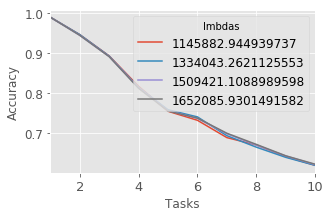

In [34]:
#fig, ax = plt.subplots(figsize=(4.5,2.5))
mpl.rcParams['figure.figsize'] = 4.75,3.0
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
df2.iloc[:,1:5].plot()
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ylabel('Accuracy')
plt.xlabel('Tasks')

Text(0.5,0,'Tasks')

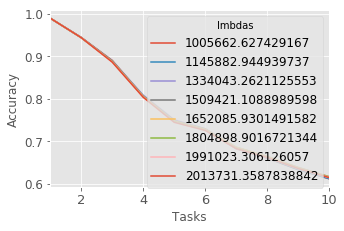

In [35]:
mpl.rcParams['figure.figsize'] = 5,3.25
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
df3.plot()
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ylabel('Accuracy')
plt.xlabel('Tasks')

In [36]:
Min = df1.iloc[:,4:].values[:,0]
Max = df2.iloc[:,4:].values[:,0]
Mean = df3.iloc[:,4:].values[:,0]
final_df = pd.DataFrame({'Min':Min, 'Max':Max, 'Mean':Mean})
final_df

,Max,Mean,Min
0,0.990000,0.989250,0.988000
1,0.944750,0.943250,0.941250
2,0.891500,0.887472,0.883833
3,0.812375,0.805250,0.797125
4,0.755600,0.747117,0.740800
5,0.737833,0.727778,0.720000
6,0.700071,0.685500,0.678571
7,0.672244,0.664060,0.657820
8,0.643779,0.637481,0.630872
9,0.622660,0.615869,0.609734


In [37]:
final_df.index.rename('Task', inplace=True)
final_df

,Max,Mean,Min
Task,,,
0,0.990000,0.989250,0.988000
1,0.944750,0.943250,0.941250
2,0.891500,0.887472,0.883833
3,0.812375,0.805250,0.797125
4,0.755600,0.747117,0.740800
5,0.737833,0.727778,0.720000
6,0.700071,0.685500,0.678571
7,0.672244,0.664060,0.657820
8,0.643779,0.637481,0.630872


In [38]:
task_splits

[(0, 4),
 (5, 9),
 (10, 14),
 (15, 19),
 (20, 24),
 (25, 29),
 (30, 34),
 (35, 38),
 (39, 42),
 (43, 46)]

In [39]:
final_df.index

RangeIndex(start=0, stop=10, step=1, name=u'Task')

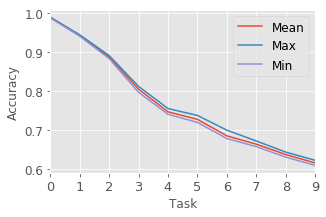

In [41]:
mpl.rcParams['figure.figsize'] = 4.75,3.0
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
ax = final_df.plot(y=['Mean','Max','Min'],x=final_df.index)
ax.set_xticks(final_df.index)
# [(0, 9), (10, 35), (36, 46)]
#ax.set_xticklabels([str(thing) for thing in task_splits])
ax.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
ax.set_ylabel('Accuracy')
#plt.savefig('../outputs/tg_mnist_results_cl/disjoint_accuracy.pdf', bbox_inches='tight')
#plt.savefig('../outputs/tg_mnist_results_cl/disjoint_accuracy.png', bbox_inches='tight')
#plt.savefig('../outputs/tg_mnist_results_cl/disjoint_accuracy.eps', bbox_inches='tight')
plt.show()

# Init the writer with  best $\lambda$s and train $10\%$ of previous samples

In [12]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/emnist/continual_learning/3sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/spike_emnist_ar1_final_10pc_v7', sess.graph)

# Generate $\lambda$s 

In [13]:
np.random.seed(100)
n_lmbdas = 8
a = np.random.uniform(low=10.0, high=22, size=(n_lmbdas,))
print(a)
print()
a = a*1.0e5
a = a[np.argsort(a)]
#a= a[-3:]
print(a)
print(type(a))
n_reps = 6
#a = ([0]+a.tolist())*n_reps
#n_lmbdas+=1
a = (a.tolist())*n_reps
print(a, len(a))

[16.5208593  13.34043262 15.09421109 20.13731359 10.05662627 11.45882945
 18.04898902 19.91023306]
()
[1005662.62742917 1145882.94493974 1334043.26211256 1509421.10889896
 1652085.93014916 1804898.90167213 1991023.30612606 2013731.35878388]
<type 'numpy.ndarray'>
([1005662.627429167, 1145882.944939737, 1334043.2621125553, 1509421.1088989598, 1652085.9301491582, 1804898.9016721344, 1991023.306126057, 2013731.3587838842, 1005662.627429167, 1145882.944939737, 1334043.2621125553, 1509421.1088989598, 1652085.9301491582, 1804898.9016721344, 1991023.306126057, 2013731.3587838842, 1005662.627429167, 1145882.944939737, 1334043.2621125553, 1509421.1088989598, 1652085.9301491582, 1804898.9016721344, 1991023.306126057, 2013731.3587838842, 1005662.627429167, 1145882.944939737, 1334043.2621125553, 1509421.1088989598, 1652085.9301491582, 1804898.9016721344, 1991023.306126057, 2013731.3587838842, 1005662.627429167, 1145882.944939737, 1334043.2621125553, 1509421.1088989598, 1652085.9301491582, 1804898.

# Generate random weights 

In [14]:
lmbdas = a
np.random.seed(0)
np_weights = []
low = -np.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
high = np.sqrt(2.0/(n_input))
for i in range(n_reps):
    np_weights.append(np.random.uniform(low=low,high=high,size=(n_input,n_middle)))

np_weights=[item for item in np_weights for i in range(n_lmbdas)]
print(len(np_weights), len(lmbdas))

(48, 48)


In [15]:
np.array_equal(np_weights[0], np_weights[7])

True

In [16]:
np.array_equal(np_weights[0], np_weights[8])

False

In [17]:
np.array_equal(np_weights[8], np_weights[10])

True

# Splitting the dataset into tasks

In [18]:
print(labels_map)

task_splits = np.array_split(np.arange(num_classes), num_classes/4-1)

task_splits = [(item.tolist()[0], item.tolist()[-1]) for item in task_splits]
task_splits

# Commence training

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}


[(0, 4),
 (5, 9),
 (10, 14),
 (15, 19),
 (20, 24),
 (25, 29),
 (30, 34),
 (35, 38),
 (39, 42),
 (43, 46)]

# Commence training

In [19]:
START_TIME = time.time()
method3_test_accs = []
#INITIALIZE THE NETWORK
logging_count = 0
sess.run(init_op,options=run_options, run_metadata=run_metadata)
sess.graph.finalize()
all_prev_task_test_accs = []
all_prev_task_test_activs = []
all_prev_task_test_accs_extra = []
all_prev_task_test_activs_extra = []
retrain_tes_acc = []
for l in range(len(lmbdas)):
    print('Training with lmbda:{}, {}'.format(lmbdas[l], l))
    #sess.run(init_op,options=run_options, run_metadata=run_metadata)
    zeta = 1e-3
    new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
    w3_zeros = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    b3_zeros = np.zeros(shape=[1,n_out], dtype=np.float32)
    w3_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    w3_accum = []
    b3_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    b3_accum = []
    reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)

    start_w2 = None
    start_b2 = None
    sess.run(w_2_update_op, {w_2_update_placeholder:np_weights[l]})
    sess.run(b_2_update_op, {b_2_update_placeholder:np.zeros(shape=[1,n_middle],dtype=np.float32)})
    end_w2 = None
    end_b2 = None

    old_test_data = []
    frac_old_train_images = []
    frac_old_train_labels = []
    historical_cross_test_acc = {}
    historical_train_accuracies = {}
    historical_train_costs = {}
    historical_val_accuracies = {}
    historical_val_costs = {}
    #sets = [(0,1), (2,3), (4,5), (6,7), (8,9)]
    sets = np.array_split(range(num_classes), int(num_classes/2))
    sets = [tuple(item.tolist()) for item in sets]
    sets = [(0, 9), (10, 35), (36, 46)]
    sets = task_splits
    test_labels_set = []
    prev_task_test_accs = []
    prev_task_test_activs = []
    prev_task_test_accs_extra = []
    prev_task_test_activs_extra = []
    n_test_samples = []
    for a_set in range(len(sets)):
        current_set = sets[a_set]
        current_set_name = 'set'+str(a_set)
        mask_val = [0]*num_classes
        for i in range(0, current_set[1]+1):
            mask_val[i]=1
        set_mask_val = np.array(mask_val, dtype=np.float32)
        print('Current mask:{}'.format(set_mask_val))
        train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                      stop=current_set[1])
        train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
        valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
        test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
        n_test_samples.append(len(test_labels_set))
        train_total = len(train_images_set)
        n_batches = len(train_images_set)/BATCH_SIZE
        #@@print('Number of batches:{}'.format(n_batches))


        #@@set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2)]
        #@@sess.run(set_omegas)
        
        sess.run(big_omeg_w2_update_op, {big_omeg_w2_update_placeholder:new_big_omeg_w2})
        sess.run(big_omeg_b2_update_op, {big_omeg_b2_update_placeholder:new_big_omeg_b2})

        #@@reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
        #@@                     tf.assign(b2_grad_accum, reset_b2_grad_accum)]
        #@@sess.run(reset_grad_accums)
        
        sess.run(w2_grad_accum_update_op, {w2_grad_accum_update_placeholder:reset_w2_grad_accum})
        sess.run(b2_grad_accum_update_op, {b2_grad_accum_update_placeholder:reset_b2_grad_accum})

        
        #@@reset_w3 = [tf.assign(w_3, w3_zeros), tf.assign(b_3, b3_zeros)]
        #@@sess.run(reset_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:w3_zeros})
        sess.run(b_3_update_op, {b_3_update_placeholder:b3_zeros})
    
        epochs = 20
        repeats = 1

        for repeat in range(repeats):
            #tf.set_random_seed(l)
            print('Repeat:{}'.format(repeat))
            train_accuracies = []
            train_costs = []
            val_accuracies = []
            val_costs = []
            best_val = 0
            first_params_set = None
            last_params_set = None
            T1 = time.time()
            for i in range(epochs):
                if(i==epochs-1):
                    start_w2, start_b2 = w_2.eval(), b_2.eval()
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: len(train_images_set)})
                #@@print('Epoch:{}'.format((i)))
                t1 = time.time()

                ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
                train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                     set1_mask:set_mask_val})
                train_costs.append(train_cost)
                train_accuracies.append(train_accuracy)
                #train_writer.add_summary(summary,logging_count)
                if(i%2==0):
                    print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

                ### CALCULATE VALID COSTS AND VALID ACCURACIES
                sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                      batch_size: len(valid_images_set)})
                _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
                val_costs.append(val_cost)
                val_accuracies.append(val_acc)

                if(val_acc>best_val):
                    best_val = val_acc
                    best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
                if(i%2==0):
                    print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: BATCH_SIZE})
                if(i%2==0):
                    print('Training on :{}'.format(current_set))
                for j in range(n_batches):

                    if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                        #if(a_set==1):
                        #    print(j, w_2.eval().sum(), w_3.eval().sum())
                        if(((j)% 1000 ==0)):
                            logging_count+=1
                            if(i==0):   
                                summary,_,_ = sess.run([merged,step, omega_step], 
                                                     feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                                  set1_mask:set_mask_val,eta:0.001,
                                                                  lmbda:lmbdas[l],n_tot:train_total,
                                                                 gradient_gate:1})
                            else:
                                summary,_, = sess.run([merged,step], 
                                                     feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                                  set1_mask:set_mask_val,eta:0.001,
                                                                  lmbda:lmbdas[l],n_tot:train_total,
                                                                 gradient_gate:1})
                            #train_writer.add_summary(summary, (i+1)*j)
                            train_writer.add_summary(summary, logging_count)
                        else:
                            if(i==0):
                                sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                         tau:0.5,set1_mask:set_mask_val,
                                                                         eta:0.001,lmbda:lmbdas[l],
                                                                         n_tot:train_total,
                                                                        gradient_gate:1})
                            else:
                                sess.run([step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                     tau:0.5,set1_mask:set_mask_val,
                                                                     eta:0.001,lmbda:lmbdas[l],
                                                                     n_tot:train_total,
                                                            gradient_gate:1})
                    else:
                        print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
                #@@print('Epoch time:{}'.format(time.time()-t1))


            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                                  feed_dict = {drop_out:0.0, 
                                                                               set1_mask:set_mask_val})
            #@@print('Final test accuracy is:{}'.format(final_test_acc))
            end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
            #@@sess.run(update_star_wbs)
            sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
            sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
            
            
            #all_final_test_accs_set1.append(final_test_acc)


            #@@best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
            #@@             tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
            #@@sess.run(best_step)
            
            sess.run(w_2_update_op, {w_2_update_placeholder:best_params_set1[0][0]})
            sess.run(b_2_update_op, {b_2_update_placeholder:best_params_set1[0][1]})
            
            sess.run(w_3_update_op, {w_3_update_placeholder:best_params_set1[1][0]})
            sess.run(b_3_update_op, {b_3_update_placeholder:best_params_set1[1][1]})
            
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                     feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

            #@@print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
            print('Time taken:{}'.format(time.time()-T1))
            #w3_list.append(w_3.eval())
            w3_accum.append(w_3.eval())
            #b3_list.append(b_3.eval())
            b3_accum.append(b_3.eval())
            if(i==epochs-1):
                if(test_acc_corresp_best_val>final_test_acc):
                    end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                    #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                    #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
                    #@@sess.run(update_star_wbs)
                    
                    sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
                    sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
                    

                #@@best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                #@@         tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
                #@@sess.run(best_step)
                
                
                sess.run(w_2_update_op, {w_2_update_placeholder:end_w2})
                sess.run(b_2_update_op, {b_2_update_placeholder:end_b2})
                
                sess.run(w_3_update_op, {w_3_update_placeholder:end_w3})
                sess.run(b_3_update_op, {b_3_update_placeholder:end_b3})

                first_params_set = [(start_w2, start_b2)]
                last_params_set = [(end_w2, end_b2)]

                small_omegas = [(w2_grad_accum.eval(),b2_grad_accum.eval())]

                delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                           [item[0] for item in first_params_set])

                delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                           [item[1] for item in first_params_set])
                delta_wbs = zip(delta_ws, delta_bs)

                big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                           [item[0] for item in delta_wbs])            
                big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                           [item[1] for item in delta_wbs])

                big_omegas = zip(big_omegas_ws, big_omegas_bs)
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                #@@print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                #@@                                                new_big_omeg_w2.mean(),
                #@@                                                new_big_omeg_w2.std()))
                #@@print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                #@@                                                new_big_omeg_b2.mean(),
                #@@                                                new_big_omeg_b2.std()))

        historical_train_accuracies[current_set_name]=train_accuracies
        historical_train_costs[current_set_name]=train_costs
        historical_val_accuracies[current_set_name]=val_accuracies
        historical_val_costs[current_set_name]=val_costs
        
        old_test_data.append(test_data_set)
        frac_old_train_images.append(train_images_set[0:int(len(train_images_set[0])*0.1),:])
        frac_old_train_labels.append(train_labels_set[0:int(len(train_images_set[0])*0.1),:])
        #######Method 3 ###########
        w3_set_rows = []
        offset=0
        #for item in w3_accum:
        #    w3_set_rows.append(item[:,offset:offset+2])
        #    offset+=2
        for v in range(len(w3_accum)):
            current_set = sets[v]
            w3_set_rows.append(w3_accum[v][:,offset:offset+(current_set[1]-current_set[0]+1)])
            offset+=current_set[1]-current_set[0]+1

        w3_set_row_avgs = [item.mean() for item in w3_set_rows]
        final_w3 = map(lambda x,y:x-y,w3_set_rows, w3_set_row_avgs)
        #final_w3 = np.concatenate(final_w3, axis=1)
        final_w3 = np.concatenate([item for item in final_w3]+[np.zeros((n_middle,n_out-offset))], axis=1)
        
        b3_set_rows = []
        offset=0
        #for item in b3_accum:
        #    b3_set_rows.append(item[:,offset:offset+2])
        #    offset+=2
        for v in range(len(b3_accum)):
            current_set = sets[v]
            b3_set_rows.append(b3_accum[v][:,offset:offset+(current_set[1]-current_set[0]+1)])
            offset+=current_set[1]-current_set[0]+1
            
        b3_set_row_avgs = [item.mean() for item in b3_set_rows]
        final_b3 = map(lambda x,y:x-y,b3_set_rows, b3_set_row_avgs)
        #final_b3 = np.concatenate(final_b3, axis=1)
        final_b3 = np.concatenate([item for item in final_b3]+[np.zeros((1,n_out-offset))], axis=1)
        
        #@@set_w3 = [tf.assign(w_3, final_w3), tf.assign(b_3, final_b3)]
        #@@sess.run(set_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:final_w3})
        sess.run(b_3_update_op, {b_3_update_placeholder:final_b3})
        
        for items in old_test_data:
            test_images_set, test_labels_set = items[0], items[1]
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, 
                                                  y:test_labels_set,
                                                  batch_size: len(test_images_set)})
            _,final_test_acc,final_test_activ = sess.run([predictions, acct_res, a_3],
                                      feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
            prev_task_test_accs.append(final_test_acc)
            prev_task_test_activs.append(final_test_activ)
            print('Method 3 test accuracy:{}'.format(final_test_acc))
        
        print('Extra training..')
        enlarged_train_imgs = np.concatenate(frac_old_train_images, axis=0)
        enlarged_train_lbls = np.concatenate(frac_old_train_labels, axis=0)
        extra_X, extra_y = shuffle(enlarged_train_imgs, enlarged_train_lbls, random_state=0)
        #extra_X = extra_X.astype(np.float32)
        #extra_y = extra_y.astype(np.float32)
        for rep in range(5):
            sess.run(iter.initializer, feed_dict={a_1: extra_X, y: extra_y,
                                                      batch_size: BATCH_SIZE})
            enlarged_batches = len(enlarged_train_imgs)/BATCH_SIZE
            for j in range(enlarged_batches):
                if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):        
                    sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                             tau:0.5,set1_mask:set_mask_val,
                                                             eta:0.001,lmbda:0,
                                                             n_tot:train_total,
                                                            gradient_gate:1.0})
                else:
                    print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
        
        for items in old_test_data:
            test_images_set, test_labels_set = items[0], items[1]
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, 
                                                  y:test_labels_set,
                                                  batch_size: len(test_images_set)})
            _,final_test_acc,final_test_activ = sess.run([predictions, acct_res, a_3],
                                      feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
            prev_task_test_accs_extra.append(final_test_acc)
            prev_task_test_activs_extra.append(final_test_activ)
            print('Method 3 test accuracy after extra trai:{}'.format(final_test_acc))
        
        w3_accum[-1] = w_3.eval()
        b3_accum[-1] = b_3.eval()
    
    all_prev_task_test_accs.append(prev_task_test_accs)
    all_prev_task_test_activs.append(prev_task_test_activs)
    
    all_prev_task_test_accs_extra.append(prev_task_test_accs_extra)
    all_prev_task_test_activs_extra.append(prev_task_test_activs_extra)
    
    #sess.run(iter.initializer, feed_dict={a_1: test_images, y: to_categorical(test_labels,num_classes=num_classes),
    #                                                      batch_size: len(test_images)})
    #_,final_test_acc,_ = sess.run([predictions, acct_res, a_3],
    #                              feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
    #method3_test_accs.append(final_test_acc)
    #print('Final test accuracy before extra training:{}'.format(final_test_acc))
    
    #print('5pc training after sequential training is done')
    
    #sess.run(iter.initializer, feed_dict={a_1: test_images, y: to_categorical(test_labels,num_classes=num_classes),
    #                                                      batch_size: len(test_images)})
    #_,final_test_acc,_ = sess.run([predictions, acct_res, a_3],
    #                              feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
    #method3_test_accs.append(final_test_acc)
    #print('Final test accuracy after extra training:{}'.format(final_test_acc))
    #retrain_tes_acc.append(final_test_acc)
                        
train_writer.close()
print('Total time:{}'.format(time.time()-START_TIME))

Training with lmbda:1005662.62743, 0
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.20045787096
validation cost:3.85014748573 and validation accuracy:0.183333337307
Training on :(0, 4)
training cost:0.0365205183625 and training accuracy:0.992582440376
validation cost:0.0333814546466 and validation accuracy:0.991666674614
Training on :(0, 4)
training cost:0.0165944229811 and training accuracy:0.998534798622
validation cost:0.0144818034023 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0093383770436 and training accuracy:0.999542117119
validation cost:0.00829836912453 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0061072

Method 3 test accuracy after extra trai:0.870000004768
Method 3 test accuracy after extra trai:0.884500026703
Method 3 test accuracy after extra trai:0.87349998951
Method 3 test accuracy after extra trai:0.813499987125
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(20, 24)
training cost:0.0599293373525 and training accuracy:0.989194154739
validation cost:0.0717980414629 and validation accuracy:0.980555534363
Training on :(20, 24)
training cost:0.0384775437415 and training accuracy:0.99459707737
validation cost:0.0453496947885 and validation accuracy:0.992592573166
Training on :(20

Training on :(35, 38)
training cost:0.040851611644 and training accuracy:0.99244505167
validation cost:0.047550175339 and validation accuracy:0.990729987621
Training on :(35, 38)
training cost:0.0309680551291 and training accuracy:0.994848906994
validation cost:0.0357397049665 and validation accuracy:0.993047535419
Training on :(35, 38)
training cost:0.0248738192022 and training accuracy:0.997252762318
validation cost:0.0283190477639 and validation accuracy:0.995365023613
Training on :(35, 38)
training cost:0.02071124129 and training accuracy:0.997939586639
validation cost:0.0234092026949 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0176912713796 and training accuracy:0.998282968998
validation cost:0.0199873074889 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.0154214166105 and training accuracy:0.99896979332
validation cost:0.0174755863845 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.01367060

Training on :(0, 4)
training cost:0.0365205183625 and training accuracy:0.992582440376
validation cost:0.0333814546466 and validation accuracy:0.991666674614
Training on :(0, 4)
training cost:0.0165944229811 and training accuracy:0.998534798622
validation cost:0.0144818034023 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0093383770436 and training accuracy:0.999542117119
validation cost:0.00829836912453 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00610721157864 and training accuracy:0.999908447266
validation cost:0.00564641179517 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00444224802777 and training accuracy:1.0
validation cost:0.00417770119384 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00345107656904 and training accuracy:1.0
validation cost:0.00325590535067 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0027997365687 and training accuracy:1.0
validation cost:0.00263868784532 and validatio

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(20, 24)
training cost:0.061055265367 and training accuracy:0.989010989666
validation cost:0.0731148868799 and validation accuracy:0.980555534363
Training on :(20, 24)
training cost:0.0394436381757 and training accuracy:0.994322359562
validation cost:0.0465116724372 and validation accuracy:0.992592573166
Training on :(20, 24)
training cost:0.0294612627476 and training accuracy:0.996520161629
validation cost:0.0344889424741 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0234689228237 and training accuracy:0.997069597244
validation cost:0.0272958297282 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0194570943713 and training accuracy:0.998260080814
validation cost:0.0224315691739 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.0166223850101 and training accuracy:0.998717963696


Training on :(35, 38)
training cost:0.0214483533055 and training accuracy:0.997825086117
validation cost:0.02425628528 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0183528307825 and training accuracy:0.998282968998
validation cost:0.0207201000303 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.0160111747682 and training accuracy:0.998855292797
validation cost:0.0181133393198 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0141939641908 and training accuracy:0.99919873476
validation cost:0.0161080434918 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0127551844344 and training accuracy:0.999313175678
validation cost:0.0145123712718 and validation accuracy:0.998841226101
Training on :(35, 38)
Time taken:215.559545994
Method 3 test accuracy:0.740499973297
Method 3 test accuracy:0.808000028133
Method 3 test accuracy:0.822499990463
Method 3 test accuracy:0.709999978542
Meth

training cost:0.00610721157864 and training accuracy:0.999908447266
validation cost:0.00564641179517 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00444224802777 and training accuracy:1.0
validation cost:0.00417770119384 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00345107656904 and training accuracy:1.0
validation cost:0.00325590535067 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.0027997365687 and training accuracy:1.0
validation cost:0.00263868784532 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00234182691202 and training accuracy:1.0
validation cost:0.00220151781105 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00200422620401 and training accuracy:1.0
validation cost:0.00187872804236 and validation accuracy:1.0
Training on :(0, 4)
Time taken:273.300060034
Method 3 test accuracy:0.987999975681
Extra training..
Method 3 test accuracy after extra trai:0.989000022411
Current mask:[1. 1. 1. 1. 1

Training on :(20, 24)
training cost:0.0304468087852 and training accuracy:0.996336996555
validation cost:0.0357307605445 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0243507809937 and training accuracy:0.99697804451
validation cost:0.0284301042557 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0202384665608 and training accuracy:0.998076915741
validation cost:0.023453168571 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.0173081066459 and training accuracy:0.998534798622
validation cost:0.0199204776436 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.015143035911 and training accuracy:0.99880951643
validation cost:0.0173640884459 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0134854605421 and training accuracy:0.999175846577
validation cost:0.015447457321 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0121872

Training on :(35, 38)
training cost:0.0147697953507 and training accuracy:0.999084234238
validation cost:0.016708733514 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0132690491155 and training accuracy:0.999313175678
validation cost:0.0150506459177 and validation accuracy:0.998841226101
Training on :(35, 38)
Time taken:216.675426006
Method 3 test accuracy:0.763000011444
Method 3 test accuracy:0.816999971867
Method 3 test accuracy:0.820500016212
Method 3 test accuracy:0.709999978542
Method 3 test accuracy:0.545000016689
Method 3 test accuracy:0.751999974251
Method 3 test accuracy:0.770500004292
Method 3 test accuracy:0.628125011921
Extra training..
Method 3 test accuracy after extra trai:0.732500016689
Method 3 test accuracy after extra trai:0.81400001049
Method 3 test accuracy after extra trai:0.816500008106
Method 3 test accuracy after extra trai:0.759000003338
Method 3 test accuracy after extra trai:0.64050000906
Method 3 test accuracy after extra trai:

Training on :(0, 4)
training cost:0.00234182691202 and training accuracy:1.0
validation cost:0.00220151781105 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00200422620401 and training accuracy:1.0
validation cost:0.00187872804236 and validation accuracy:1.0
Training on :(0, 4)
Time taken:274.175651073
Method 3 test accuracy:0.987999975681
Extra training..
Method 3 test accuracy after extra trai:0.989000022411
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(5, 9)
training cost:0.0513612143695 and training accuracy:0.991849839687
validation cost:0.0611802339554 and 

Training on :(20, 24)
training cost:0.0178818199784 and training accuracy:0.998443245888
validation cost:0.0206563118845 and validation accuracy:0.998148143291
Training on :(20, 24)
training cost:0.0156455356628 and training accuracy:0.99880951643
validation cost:0.0180055983365 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0139305880293 and training accuracy:0.999175846577
validation cost:0.0160105507821 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.012582895346 and training accuracy:0.999450564384
validation cost:0.0144540620968 and validation accuracy:0.999074101448
Training on :(20, 24)
Time taken:272.695050955
Method 3 test accuracy:0.788500010967
Method 3 test accuracy:0.89200001955
Method 3 test accuracy:0.861500024796
Method 3 test accuracy:0.728500008583
Method 3 test accuracy:0.582499980927
Extra training..
Method 3 test accuracy after extra trai:0.784500002861
Method 3 test accuracy after extra trai:0.880500018597

Method 3 test accuracy:0.837000012398
Method 3 test accuracy:0.684499979019
Method 3 test accuracy:0.547500014305
Method 3 test accuracy:0.777000010014
Method 3 test accuracy:0.770500004292
Method 3 test accuracy:0.582499980927
Extra training..
Method 3 test accuracy after extra trai:0.733500003815
Method 3 test accuracy after extra trai:0.81400001049
Method 3 test accuracy after extra trai:0.814999997616
Method 3 test accuracy after extra trai:0.758499979973
Method 3 test accuracy after extra trai:0.639999985695
Method 3 test accuracy after extra trai:0.830500006676
Method 3 test accuracy after extra trai:0.788999974728
Method 3 test accuracy after extra trai:0.81124997139
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:

Method 3 test accuracy after extra trai:0.989000022411
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(5, 9)
training cost:0.0518519245088 and training accuracy:0.991849839687
validation cost:0.061673283577 and validation accuracy:0.986111104488
Training on :(5, 9)
training cost:0.0296021774411 and training accuracy:0.996703267097
validation cost:0.0355623587966 and validation accuracy:0.996296286583
Training on :(5, 9)
training cost:0.0204410478473 and training accuracy:0.999175846577
validation cost:0.02440033108 and validation accuracy:0.998148143291
Training on :(5, 9)
training

training cost:0.0142156919464 and training accuracy:0.999084234238
validation cost:0.0163884256035 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0128325978294 and training accuracy:0.999358952045
validation cost:0.0147889191285 and validation accuracy:0.999074101448
Training on :(20, 24)
Time taken:274.280664921
Method 3 test accuracy:0.783500015736
Method 3 test accuracy:0.888499975204
Method 3 test accuracy:0.865000009537
Method 3 test accuracy:0.731000006199
Method 3 test accuracy:0.57800000906
Extra training..
Method 3 test accuracy after extra trai:0.78250002861
Method 3 test accuracy after extra trai:0.879999995232
Method 3 test accuracy after extra trai:0.853999972343
Method 3 test accuracy after extra trai:0.771000027657
Method 3 test accuracy after extra trai:0.73449999094
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000

Method 3 test accuracy after extra trai:0.64050000906
Method 3 test accuracy after extra trai:0.829999983311
Method 3 test accuracy after extra trai:0.788500010967
Method 3 test accuracy after extra trai:0.810625016689
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(39, 42)
training cost:0.0704752579331 and training accuracy:0.985119044781
validation cost:0.0816322490573 and validation accuracy:0.979166686535
Training on :(39, 42)
training cost:0.0483722686768 and training accuracy:0.991071403027
validation cost:0.0594779290259 and validation accuracy:0.986111104488
Training on :(39, 4

Training on :(5, 9)
training cost:0.0523452349007 and training accuracy:0.991849839687
validation cost:0.0621731802821 and validation accuracy:0.986111104488
Training on :(5, 9)
training cost:0.0300470013171 and training accuracy:0.996611714363
validation cost:0.0360613614321 and validation accuracy:0.996296286583
Training on :(5, 9)
training cost:0.0208190865815 and training accuracy:0.999084234238
validation cost:0.0248475335538 and validation accuracy:0.998148143291
Training on :(5, 9)
training cost:0.0159031618387 and training accuracy:0.999633669853
validation cost:0.0187911931425 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0128626758233 and training accuracy:0.999725282192
validation cost:0.0149783808738 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0108266547322 and training accuracy:0.999725282192
validation cost:0.0124362781644 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00940004829317 a

Method 3 test accuracy after extra trai:0.783500015736
Method 3 test accuracy after extra trai:0.879999995232
Method 3 test accuracy after extra trai:0.853999972343
Method 3 test accuracy after extra trai:0.770500004292
Method 3 test accuracy after extra trai:0.73449999094
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.0634144023061 and training accuracy:0.986904740334
validation cost:0.0689880922437 and validation accuracy:0.981481492519
Training on :(25, 29)
training cost:0.0406817756593 and training accuracy:0.993040263653
validation cost:0.0452342182398

Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(39, 42)
training cost:0.0713029354811 and training accuracy:0.98489010334
validation cost:0.0823614224792 and validation accuracy:0.978009283543
Training on :(39, 42)
training cost:0.0490468069911 and training accuracy:0.991071403027
validation cost:0.0601536519825 and validation accuracy:0.986111104488
Training on :(39, 42)
training cost:0.0380669124424 and training accuracy:0.993933141232
validation cost:0.0478119328618 and validation accuracy:0.988425910473
Training on :(39, 42)
training cost:0.0312528908253 and training accuracy:0.995535731316
validation cost:0.0395245850086 and validation accuracy:0.988425910473
Training on :(39, 42)
training cost:0.0265369974077 and training accuracy:0.

Training on :(5, 9)
training cost:0.021249840036 and training accuracy:0.999084234238
validation cost:0.0253486987203 and validation accuracy:0.998148143291
Training on :(5, 9)
training cost:0.0162699837238 and training accuracy:0.999633669853
validation cost:0.0192333124578 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0131803238764 and training accuracy:0.999725282192
validation cost:0.0153706511483 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0111024165526 and training accuracy:0.999725282192
validation cost:0.0127819562331 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00964128784835 and training accuracy:0.999816834927
validation cost:0.010994005017 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00856595207006 and training accuracy:1.0
validation cost:0.00971436873078 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00773768033832 and training accuracy:

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.0643110871315 and training accuracy:0.986813187599
validation cost:0.0698516741395 and validation accuracy:0.981481492519
Training on :(25, 29)
training cost:0.0414394848049 and training accuracy:0.993040263653
validation cost:0.046030189842 and validation accuracy:0.988888859749
Training on :(25, 29)
training cost:0.0306681096554 and training accuracy:0.995604395866
validation cost:0.034196600318 and validation accuracy:0.991666674614
Training on :(25, 29)
training cost:0.024300666526 and training accuracy:0.997161149979
validation cost:0.0270879175514 and validation accuracy:0.991666674614
Training on :(25, 29)
training cost:0.0201268009841 and training accuracy:0.998351633549
validation cost:0.0224014688283 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.0171953197569 and training accuracy:0.999084234238
va

Training on :(39, 42)
training cost:0.0387168116868 and training accuracy:0.99347525835
validation cost:0.0484602227807 and validation accuracy:0.988425910473
Training on :(39, 42)
training cost:0.0318287573755 and training accuracy:0.995421230793
validation cost:0.0401402637362 and validation accuracy:0.988425910473
Training on :(39, 42)
training cost:0.0270512104034 and training accuracy:0.996451437473
validation cost:0.0340768136084 and validation accuracy:0.990740716457
Training on :(39, 42)
training cost:0.0235033240169 and training accuracy:0.997481703758
validation cost:0.0294709783047 and validation accuracy:0.993055582047
Training on :(39, 42)
training cost:0.0207534991205 and training accuracy:0.998282968998
validation cost:0.0258875712752 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0185637678951 and training accuracy:0.998855292797
validation cost:0.0230465866625 and validation accuracy:0.997685194016
Training on :(39, 42)
training cost:0.016

Training on :(5, 9)
training cost:0.00966951530427 and training accuracy:0.999816834927
validation cost:0.0110290665179 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00859119556844 and training accuracy:0.999908447266
validation cost:0.00974587537348 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00775997946039 and training accuracy:1.0
validation cost:0.00876939669251 and validation accuracy:1.0
Training on :(5, 9)
Time taken:272.832303047
Method 3 test accuracy:0.948499977589
Method 3 test accuracy:0.943000018597
Extra training..
Method 3 test accuracy after extra trai:0.962000012398
Method 3 test accuracy after extra trai:0.952499985695
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of

Training on :(25, 29)
training cost:0.0415273010731 and training accuracy:0.993040263653
validation cost:0.0461281165481 and validation accuracy:0.988888859749
Training on :(25, 29)
training cost:0.0307460743934 and training accuracy:0.995604395866
validation cost:0.034289624542 and validation accuracy:0.991666674614
Training on :(25, 29)
training cost:0.0243667848408 and training accuracy:0.997161149979
validation cost:0.0271689333022 and validation accuracy:0.991666674614
Training on :(25, 29)
training cost:0.0201847404242 and training accuracy:0.998351633549
validation cost:0.022471813485 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.0172440689057 and training accuracy:0.999084234238
validation cost:0.0191675741225 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.0150655666366 and training accuracy:0.999633669853
validation cost:0.0167297963053 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.01338

Training on :(39, 42)
training cost:0.0271109100431 and training accuracy:0.996451437473
validation cost:0.0341524779797 and validation accuracy:0.990740716457
Training on :(39, 42)
training cost:0.0235582962632 and training accuracy:0.997481703758
validation cost:0.0295423530042 and validation accuracy:0.993055582047
Training on :(39, 42)
training cost:0.0208036731929 and training accuracy:0.998282968998
validation cost:0.025952892378 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0186103042215 and training accuracy:0.998855292797
validation cost:0.0231076329947 and validation accuracy:0.997685194016
Training on :(39, 42)
training cost:0.0168254971504 and training accuracy:0.999313175678
validation cost:0.0208093561232 and validation accuracy:0.997685194016
Training on :(39, 42)
Time taken:216.103769064
Method 3 test accuracy:0.736500024796
Method 3 test accuracy:0.794000029564
Method 3 test accuracy:0.833999991417
Method 3 test accuracy:0.659500002861
Me

training cost:0.00657955929637 and training accuracy:1.0
validation cost:0.0074256262742 and validation accuracy:1.0
Training on :(5, 9)
Time taken:273.497436047
Method 3 test accuracy:0.962000012398
Method 3 test accuracy:0.927500009537
Extra training..
Method 3 test accuracy after extra trai:0.964500010014
Method 3 test accuracy after extra trai:0.958000004292
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.060875158757 and training accuracy:0.987179458141
validation cost:0.0793085470796 and validation accuracy:0.981481492519
Training on :(10, 14)
training

Training on :(25, 29)
training cost:0.0167685560882 and training accuracy:0.998992681503
validation cost:0.0200280435383 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.0143474135548 and training accuracy:0.999633669853
validation cost:0.0173095241189 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.0125801088288 and training accuracy:0.999816834927
validation cost:0.0152809284627 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.0112410029396 and training accuracy:0.999816834927
validation cost:0.0137119581923 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.0101898238063 and training accuracy:1.0
validation cost:0.0124527523294 and validation accuracy:1.0
Training on :(25, 29)
Time taken:274.048026085
Method 3 test accuracy:0.838500022888
Method 3 test accuracy:0.846000015736
Method 3 test accuracy:0.865999996662
Method 3 test accuracy:0.689499974251
Method 3 test accuracy:

training cost:0.016264161095 and training accuracy:0.999084234238
validation cost:0.0226763766259 and validation accuracy:0.998842597008
Training on :(39, 42)
training cost:0.0146870333701 and training accuracy:0.999313175678
validation cost:0.0206542462111 and validation accuracy:0.998842597008
Training on :(39, 42)
Time taken:216.609143019
Method 3 test accuracy:0.805499970913
Method 3 test accuracy:0.78149998188
Method 3 test accuracy:0.845499992371
Method 3 test accuracy:0.642499983311
Method 3 test accuracy:0.534500002861
Method 3 test accuracy:0.779500007629
Method 3 test accuracy:0.73299998045
Method 3 test accuracy:0.685000002384
Method 3 test accuracy:0.501874983311
Extra training..
Method 3 test accuracy after extra trai:0.742500007153
Method 3 test accuracy after extra trai:0.771499991417
Method 3 test accuracy after extra trai:0.810000002384
Method 3 test accuracy after extra trai:0.653500020504
Method 3 test accuracy after extra trai:0.635500013828
Method 3 test accuracy a

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.061920043081 and training accuracy:0.986721634865
validation cost:0.0804960876703 and validation accuracy:0.980555534363
Training on :(10, 14)
training cost:0.0376861914992 and training accuracy:0.994780242443
validation cost:0.0518726855516 and validation accuracy:0.987037062645
Training on :(10, 14)
training cost:0.0266252178699 and training accuracy:0.997435867786
validation cost:0.037387996912 and validation accuracy:0.993518531322
Training on :(10, 14)
training cost:0.0204767622054 and training accuracy:0.999084234238
validation cost:0.0287906043231 and validation accuracy:0.995370388031
Training on :(10, 14)
training cost:0.0167075097561 and training accuracy:0.999633669853
validation cost:0.0232960712165 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0141965122893 and training accuracy:0.999725282192
v

Training on :(25, 29)
training cost:0.0105724669993 and training accuracy:1.0
validation cost:0.0129543980584 and validation accuracy:1.0
Training on :(25, 29)
Time taken:273.659897089
Method 3 test accuracy:0.82950001955
Method 3 test accuracy:0.84500002861
Method 3 test accuracy:0.867500007153
Method 3 test accuracy:0.677500009537
Method 3 test accuracy:0.555000007153
Method 3 test accuracy:0.757499992847
Extra training..
Method 3 test accuracy after extra trai:0.81400001049
Method 3 test accuracy after extra trai:0.856000006199
Method 3 test accuracy after extra trai:0.853500008583
Method 3 test accuracy after extra trai:0.759500026703
Method 3 test accuracy after extra trai:0.654500007629
Method 3 test accuracy after extra trai:0.823000013828
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Len

Method 3 test accuracy after extra trai:0.741500020027
Method 3 test accuracy after extra trai:0.772000014782
Method 3 test accuracy after extra trai:0.807500004768
Method 3 test accuracy after extra trai:0.653500020504
Method 3 test accuracy after extra trai:0.633000016212
Method 3 test accuracy after extra trai:0.82800000906
Method 3 test accuracy after extra trai:0.79650002718
Method 3 test accuracy after extra trai:0.810000002384
Method 3 test accuracy after extra trai:0.721249997616
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(43, 46)
training cost:0.088046848774 and training a

Training on :(10, 14)
training cost:0.0213645305485 and training accuracy:0.998992681503
validation cost:0.0300929322839 and validation accuracy:0.995370388031
Training on :(10, 14)
training cost:0.0174518041313 and training accuracy:0.999542117119
validation cost:0.0244126673788 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0148332072422 and training accuracy:0.999725282192
validation cost:0.0205068122596 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0129641732201 and training accuracy:0.999908447266
validation cost:0.0176906231791 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0115629890934 and training accuracy:1.0
validation cost:0.01558523532 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0104712555185 and training accuracy:1.0
validation cost:0.0139633184299 and validation accuracy:1.0
Training on :(10, 14)
Time taken:273.524253845
Method 3 test accuracy:0.89200001955
Me

Method 3 test accuracy after extra trai:0.653500020504
Method 3 test accuracy after extra trai:0.819999992847
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(30, 34)
training cost:0.154844209552 and training accuracy:0.956501841545
validation cost:0.140059098601 and validation accuracy:0.962037026882
Training on :(30, 34)
training cost:0.115225754678 and training accuracy:0.968772888184
validation cost:0.103317499161 and validation accuracy:0.972222208977
Training on :(30, 34)
training cost:0.0923263058066 and training accuracy:0.976282060146
validation cost:0.0824828967452 and val

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(43, 46)
training cost:0.0901835635304 and training accuracy:0.979967951775
validation cost:0.102923497558 and validation accuracy:0.96875
Training on :(43, 46)
training cost:0.06225098297 and training accuracy:0.987293958664
validation cost:0.0702998414636 and validation accuracy:0.982638895512
Training on :(43, 46)
training cost:0.0482516363263 and training accuracy:0.990842461586
validation cost:0.0540198720992 and validation accuracy:0.986111104488
Training on :(43, 46)
training cost:0.0394956022501 and training accuracy:0.993589758873
validation cost:0.0440055653453 and validation accuracy:0.989583313465
Training on :(43, 46)
training cost:0.033451475203 and training accuracy:0.995535731316
validation cost:0.0372092798352 and validation accuracy:0.993055582047
Training on :(43, 46)
training cost:0.0290071126074 and training accuracy:0.996565937996
validation

Training on :(10, 14)
training cost:0.0108402241021 and training accuracy:1.0
validation cost:0.0145177198574 and validation accuracy:1.0
Training on :(10, 14)
Time taken:274.490854025
Method 3 test accuracy:0.881500005722
Method 3 test accuracy:0.910499989986
Method 3 test accuracy:0.892499983311
Extra training..
Method 3 test accuracy after extra trai:0.933000028133
Method 3 test accuracy after extra trai:0.916499972343
Method 3 test accuracy after extra trai:0.916499972343
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(15, 19)
training cost:0.0954761132598 and training accuracy

Training on :(30, 34)
training cost:0.117394044995 and training accuracy:0.968406617641
validation cost:0.105150476098 and validation accuracy:0.972222208977
Training on :(30, 34)
training cost:0.0947283953428 and training accuracy:0.97527474165
validation cost:0.0845314189792 and validation accuracy:0.977777779102
Training on :(30, 34)
training cost:0.0789869353175 and training accuracy:0.980311334133
validation cost:0.0703171491623 and validation accuracy:0.981481492519
Training on :(30, 34)
training cost:0.0673012286425 and training accuracy:0.98369961977
validation cost:0.059868529439 and validation accuracy:0.986111104488
Training on :(30, 34)
training cost:0.0584359094501 and training accuracy:0.987545788288
validation cost:0.0519797764719 and validation accuracy:0.991666674614
Training on :(30, 34)
training cost:0.0515337474644 and training accuracy:0.990842461586
validation cost:0.0458665527403 and validation accuracy:0.994444429874
Training on :(30, 34)
training cost:0.0461223

training cost:0.0495315529406 and training accuracy:0.990842461586
validation cost:0.0554478876293 and validation accuracy:0.986111104488
Training on :(43, 46)
training cost:0.0406352169812 and training accuracy:0.993131875992
validation cost:0.0452567078173 and validation accuracy:0.989583313465
Training on :(43, 46)
training cost:0.0344726778567 and training accuracy:0.995192289352
validation cost:0.0383129827678 and validation accuracy:0.993055582047
Training on :(43, 46)
training cost:0.0299289766699 and training accuracy:0.996451437473
validation cost:0.033255673945 and validation accuracy:0.994212985039
Training on :(43, 46)
training cost:0.0264281108975 and training accuracy:0.997023820877
validation cost:0.0293760336936 and validation accuracy:0.995370388031
Training on :(43, 46)
training cost:0.0236424636096 and training accuracy:0.998054027557
validation cost:0.0262992549688 and validation accuracy:0.997685194016
Training on :(43, 46)
training cost:0.021376285702 and training

Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(15, 19)
training cost:0.0963099300861 and training accuracy:0.975457847118
validation cost:0.111504204571 and validation accuracy:0.96851849556
Training on :(15, 19)
training cost:0.0664834082127 and training accuracy:0.984432220459
validation cost:0.0785935223103 and validation accuracy:0.978703677654
Training on :(15, 19)
training cost:0.0511172674596 and training accuracy:0.988919436932
validation cost:0.0614957101643 and validation accuracy:0.987037062645
Training on :(15, 19)
training cost:0.041298341006 and training accuracy:0.991941392422
validation cost:0.0502846576273 and validation accuracy:0.989814817905
Training on :(15, 19)
training cost:0.0344729498029 and training accuracy:0.994230747223
validation cost:0.0421928688884 and validation accuracy:0.991666674614
Training on :(15, 19)
training cost:0.0295099113137 and training accuracy:0.996062

Training on :(30, 34)
training cost:0.0533424243331 and training accuracy:0.990201473236
validation cost:0.0473339557648 and validation accuracy:0.994444429874
Training on :(30, 34)
training cost:0.0477302074432 and training accuracy:0.992582440376
validation cost:0.0423922166228 and validation accuracy:0.995370388031
Training on :(30, 34)
training cost:0.0433166772127 and training accuracy:0.994139194489
validation cost:0.0384438037872 and validation accuracy:0.998148143291
Training on :(30, 34)
Time taken:274.344862938
Method 3 test accuracy:0.748000025749
Method 3 test accuracy:0.79650002718
Method 3 test accuracy:0.814999997616
Method 3 test accuracy:0.630500018597
Method 3 test accuracy:0.535000026226
Method 3 test accuracy:0.774500012398
Method 3 test accuracy:0.697499990463
Extra training..
Method 3 test accuracy after extra trai:0.763499975204
Method 3 test accuracy after extra trai:0.839999973774
Method 3 test accuracy after extra trai:0.839500010014
Method 3 test accuracy aft

Training on :(43, 46)
training cost:0.0241959970444 and training accuracy:0.997939586639
validation cost:0.0268771275878 and validation accuracy:0.997685194016
Training on :(43, 46)
training cost:0.021882513538 and training accuracy:0.998740851879
validation cost:0.0243237093091 and validation accuracy:0.998842597008
Training on :(43, 46)
Time taken:215.900843143
Method 3 test accuracy:0.784500002861
Method 3 test accuracy:0.768000006676
Method 3 test accuracy:0.837499976158
Method 3 test accuracy:0.589500010014
Method 3 test accuracy:0.527000010014
Method 3 test accuracy:0.778500020504
Method 3 test accuracy:0.732500016689
Method 3 test accuracy:0.706250011921
Method 3 test accuracy:0.589999973774
Method 3 test accuracy:0.484375
Extra training..
Method 3 test accuracy after extra trai:0.716000020504
Method 3 test accuracy after extra trai:0.736500024796
Method 3 test accuracy after extra trai:0.796000003815
Method 3 test accuracy after extra trai:0.672500014305
Method 3 test accuracy 

Training on :(15, 19)
training cost:0.0519964806736 and training accuracy:0.988736271858
validation cost:0.0624312236905 and validation accuracy:0.987037062645
Training on :(15, 19)
training cost:0.0421550497413 and training accuracy:0.991391956806
validation cost:0.0512269325554 and validation accuracy:0.989814817905
Training on :(15, 19)
training cost:0.0352842435241 and training accuracy:0.994139194489
validation cost:0.0431283041835 and validation accuracy:0.991666674614
Training on :(15, 19)
training cost:0.0302645619959 and training accuracy:0.995695948601
validation cost:0.0370352640748 and validation accuracy:0.992592573166
Training on :(15, 19)
training cost:0.0264704804868 and training accuracy:0.99697804451
validation cost:0.032334625721 and validation accuracy:0.995370388031
Training on :(15, 19)
training cost:0.0235148705542 and training accuracy:0.997710645199
validation cost:0.0286396052688 and validation accuracy:0.995370388031
Training on :(15, 19)
training cost:0.0211

training cost:0.0447508245707 and training accuracy:0.993772864342
validation cost:0.0396298095584 and validation accuracy:0.99722224474
Training on :(30, 34)
Time taken:273.00846386
Method 3 test accuracy:0.745500028133
Method 3 test accuracy:0.796000003815
Method 3 test accuracy:0.819500029087
Method 3 test accuracy:0.625999987125
Method 3 test accuracy:0.542999982834
Method 3 test accuracy:0.739000022411
Method 3 test accuracy:0.708500027657
Extra training..
Method 3 test accuracy after extra trai:0.764500021935
Method 3 test accuracy after extra trai:0.839500010014
Method 3 test accuracy after extra trai:0.837999999523
Method 3 test accuracy after extra trai:0.740999996662
Method 3 test accuracy after extra trai:0.648999989033
Method 3 test accuracy after extra trai:0.842000007629
Method 3 test accuracy after extra trai:0.801999986172
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.

Method 3 test accuracy:0.84399998188
Method 3 test accuracy:0.587000012398
Method 3 test accuracy:0.53250002861
Method 3 test accuracy:0.745000004768
Method 3 test accuracy:0.741999983788
Method 3 test accuracy:0.708124995232
Method 3 test accuracy:0.59249997139
Method 3 test accuracy:0.493124991655
Extra training..
Method 3 test accuracy after extra trai:0.716499984264
Method 3 test accuracy after extra trai:0.73449999094
Method 3 test accuracy after extra trai:0.796000003815
Method 3 test accuracy after extra trai:0.67150002718
Method 3 test accuracy after extra trai:0.638000011444
Method 3 test accuracy after extra trai:0.800499975681
Method 3 test accuracy after extra trai:0.782000005245
Method 3 test accuracy after extra trai:0.804374992847
Method 3 test accuracy after extra trai:0.663124978542
Method 3 test accuracy after extra trai:0.653124988079
Training with lmbda:1991023.30613, 14
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 

training cost:0.0361904166639 and training accuracy:0.993772864342
validation cost:0.0441542677581 and validation accuracy:0.990740716457
Training on :(15, 19)
training cost:0.0311205293983 and training accuracy:0.995421230793
validation cost:0.0380303449929 and validation accuracy:0.992592573166
Training on :(15, 19)
training cost:0.0272624865174 and training accuracy:0.996886432171
validation cost:0.0332908555865 and validation accuracy:0.995370388031
Training on :(15, 19)
training cost:0.0242490489036 and training accuracy:0.99761903286
validation cost:0.0295321438462 and validation accuracy:0.995370388031
Training on :(15, 19)
training cost:0.0218317303807 and training accuracy:0.998168468475
validation cost:0.0264939554036 and validation accuracy:0.99722224474
Training on :(15, 19)
Time taken:272.756277084
Method 3 test accuracy:0.864000022411
Method 3 test accuracy:0.887000024319
Method 3 test accuracy:0.875
Method 3 test accuracy:0.666999995708
Extra training..
Method 3 test acc

Method 3 test accuracy:0.706499993801
Extra training..
Method 3 test accuracy after extra trai:0.761500000954
Method 3 test accuracy after extra trai:0.837999999523
Method 3 test accuracy after extra trai:0.837499976158
Method 3 test accuracy after extra trai:0.739000022411
Method 3 test accuracy after extra trai:0.648000001907
Method 3 test accuracy after extra trai:0.839500010014
Method 3 test accuracy after extra trai:0.801999986172
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(863, 3630)
Length of valid labels:863
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014796257 and validation accuracy:0.0
Training on :(35, 38)
training cost:0.063105084002 and training accuracy:0.98592031002
validation cost:0.07056786865 a

Method 3 test accuracy after extra trai:0.638000011444
Method 3 test accuracy after extra trai:0.799499988556
Method 3 test accuracy after extra trai:0.780499994755
Method 3 test accuracy after extra trai:0.803749978542
Method 3 test accuracy after extra trai:0.660624980927
Method 3 test accuracy after extra trai:0.654375016689
Training with lmbda:2013731.35878, 15
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.20045787096
validation cost:3.85014748573 and validation accuracy:0.183333337307
Training on :(0, 4)
training cost:0.0355046316981 and training accuracy:0.993589758873
validation cost:0.0335519351065 and validation accuracy:0.992592573166
Trainin

Training on :(15, 19)
training cost:0.0219086315483 and training accuracy:0.998076915741
validation cost:0.0265868920833 and validation accuracy:0.99722224474
Training on :(15, 19)
Time taken:273.386379004
Method 3 test accuracy:0.863499999046
Method 3 test accuracy:0.886500000954
Method 3 test accuracy:0.875
Method 3 test accuracy:0.666999995708
Extra training..
Method 3 test accuracy after extra trai:0.878499984741
Method 3 test accuracy after extra trai:0.886500000954
Method 3 test accuracy after extra trai:0.866999983788
Method 3 test accuracy after extra trai:0.813000023365
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014796257 and validation accuracy:0.0
Training on :(35, 38)
training cost:0.0631981268525 and training accuracy:0.98592031002
validation cost:0.0706634819508 and validation accuracy:0.981460034847
Training on :(35, 38)
training cost:0.0425098277628 and training accuracy:0.991300344467
validation cost:0.0476258732378 and validation accuracy:0.987253785133
Training on :(35, 38)
training cost:0.0323567427695 and training accuracy:0.994734406471
validation cost:0.0360744744539 and validation accuracy:0.995365023613
Training on :(35, 38)
training cost:0.0260760374367 and training accuracy:0.996794879436
validation cost:0.0290786772966 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0217737816274 and training accuracy:0.997939586639
validation cost:0.0244146790355 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0186533275992 and training accuracy:0.998855292797


training cost:3.85014748573 and training accuracy:0.20045787096
validation cost:3.85014748573 and validation accuracy:0.183333337307
Training on :(0, 4)
training cost:0.0364198386669 and training accuracy:0.993681311607
validation cost:0.0359098501503 and validation accuracy:0.992592573166
Training on :(0, 4)
training cost:0.0165302548558 and training accuracy:0.997893750668
validation cost:0.015737131238 and validation accuracy:0.996296286583
Training on :(0, 4)
training cost:0.00927482172847 and training accuracy:0.999725282192
validation cost:0.00873152259737 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00603256095201 and training accuracy:1.0
validation cost:0.00575694767758 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.004366743844 and training accuracy:1.0
validation cost:0.00420594774187 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00338846398517 and training accuracy:1.0
validation cost:0.00327685847878 and validation accu

Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(20, 24)
training cost:0.0617417097092 and training accuracy:0.989377260208
validation cost:0.0739637315273 and validation accuracy:0.982407391071
Training on :(20, 24)
training cost:0.0403646565974 and training accuracy:0.994230747223
validation cost:0.0469788946211 and validation accuracy:0.992592573166
Training on :(20, 24)
training cost:0.0302092730999 and training accuracy:0.996886432171
validation cost:0.0341127514839 and validation accuracy:0.994444429874
Training on :(20, 24)
training cost:0.0240079388022 and training accuracy:0.997435867786
validation cost:0.026293810457 and validation accuracy:0.995370388031
Training on :(20, 24)
training cost:0.0198329146951 and training accurac

Training on :(35, 38)
training cost:0.0245268996805 and training accuracy:0.997481703758
validation cost:0.0278964620084 and validation accuracy:0.995365023613
Training on :(35, 38)
training cost:0.0203348901123 and training accuracy:0.998168468475
validation cost:0.0229829680175 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0173698011786 and training accuracy:0.998855292797
validation cost:0.0195466130972 and validation accuracy:0.997682511806
Training on :(35, 38)
training cost:0.015177522786 and training accuracy:0.999542117119
validation cost:0.0170280337334 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0134994722903 and training accuracy:0.999771058559
validation cost:0.0151040637866 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0121777877212 and training accuracy:0.999771058559
validation cost:0.0135883186013 and validation accuracy:1.0
Training on :(35, 38)
Time taken:216.150638103
Method 3 test accuracy:0.81

training cost:0.00927482172847 and training accuracy:0.999725282192
validation cost:0.00873152259737 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00603256095201 and training accuracy:1.0
validation cost:0.00575694767758 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.004366743844 and training accuracy:1.0
validation cost:0.00420594774187 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00338846398517 and training accuracy:1.0
validation cost:0.00327685847878 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00274940137751 and training accuracy:1.0
validation cost:0.00266045634635 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00230149016716 and training accuracy:1.0
validation cost:0.00222453498282 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00197135494091 and training accuracy:1.0
validation cost:0.00190164404921 and validation accuracy:1.0
Training on :(0, 4)
Time taken:273.667680979


Training on :(20, 24)
training cost:0.0413892529905 and training accuracy:0.994139194489
validation cost:0.0482467599213 and validation accuracy:0.992592573166
Training on :(20, 24)
training cost:0.0311257950962 and training accuracy:0.996611714363
validation cost:0.0352932736278 and validation accuracy:0.993518531322
Training on :(20, 24)
training cost:0.024832142517 and training accuracy:0.997344315052
validation cost:0.0273599177599 and validation accuracy:0.994444429874
Training on :(20, 24)
training cost:0.0205690618604 and training accuracy:0.997802197933
validation cost:0.0222284384072 and validation accuracy:0.99722224474
Training on :(20, 24)
training cost:0.0175318568945 and training accuracy:0.998351633549
validation cost:0.0187908671796 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0152926016599 and training accuracy:0.998626351357
validation cost:0.0163516364992 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0135

Training on :(35, 38)
training cost:0.0157510805875 and training accuracy:0.99919873476
validation cost:0.0176605135202 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0140045946464 and training accuracy:0.999656617641
validation cost:0.0156614296138 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0126260556281 and training accuracy:0.999771058559
validation cost:0.0140845915303 and validation accuracy:1.0
Training on :(35, 38)
Time taken:216.414566994
Method 3 test accuracy:0.815500020981
Method 3 test accuracy:0.79699999094
Method 3 test accuracy:0.838500022888
Method 3 test accuracy:0.690999984741
Method 3 test accuracy:0.548500001431
Method 3 test accuracy:0.75
Method 3 test accuracy:0.768499970436
Method 3 test accuracy:0.582499980927
Extra training..
Method 3 test accuracy after extra trai:0.735000014305
Method 3 test accuracy after extra trai:0.819999992847
Method 3 test accuracy after extra trai:0.831499993801
Method 3 test accurac

Training on :(0, 4)
training cost:0.00274940137751 and training accuracy:1.0
validation cost:0.00266045634635 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00230149016716 and training accuracy:1.0
validation cost:0.00222453498282 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00197135494091 and training accuracy:1.0
validation cost:0.00190164404921 and validation accuracy:1.0
Training on :(0, 4)
Time taken:272.926415205
Method 3 test accuracy:0.990000009537
Extra training..
Method 3 test accuracy after extra trai:0.989499986172
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validatio

training cost:0.0213685873896 and training accuracy:0.99761903286
validation cost:0.0232247952372 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0182360559702 and training accuracy:0.998076915741
validation cost:0.0196311883628 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.015911616385 and training accuracy:0.998626351357
validation cost:0.017071871087 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0141358235851 and training accuracy:0.99880951643
validation cost:0.0151570457965 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0127397980541 and training accuracy:0.999084234238
validation cost:0.013647784479 and validation accuracy:1.0
Training on :(20, 24)
Time taken:273.923289061
Method 3 test accuracy:0.82849997282
Method 3 test accuracy:0.879499971867
Method 3 test accuracy:0.861999988556
Method 3 test accuracy:0.716499984264
Method 3 test accuracy:0.596499979496
Ex

Training on :(35, 38)
Time taken:216.676501036
Method 3 test accuracy:0.800499975681
Method 3 test accuracy:0.806999981403
Method 3 test accuracy:0.837499976158
Method 3 test accuracy:0.686500012875
Method 3 test accuracy:0.552999973297
Method 3 test accuracy:0.746500015259
Method 3 test accuracy:0.768499970436
Method 3 test accuracy:0.567499995232
Extra training..
Method 3 test accuracy after extra trai:0.731500029564
Method 3 test accuracy after extra trai:0.822499990463
Method 3 test accuracy after extra trai:0.831499993801
Method 3 test accuracy after extra trai:0.750500023365
Method 3 test accuracy after extra trai:0.630500018597
Method 3 test accuracy after extra trai:0.81099998951
Method 3 test accuracy after extra trai:0.800499975681
Method 3 test accuracy after extra trai:0.839999973774
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of

Training on :(0, 4)
Time taken:274.665639162
Method 3 test accuracy:0.990000009537
Extra training..
Method 3 test accuracy after extra trai:0.989499986172
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(5, 9)
training cost:0.0493741035461 and training accuracy:0.992124557495
validation cost:0.0592778176069 and validation accuracy:0.988888859749
Training on :(5, 9)
training cost:0.0279230047017 and training accuracy:0.997069597244
validation cost:0.033666882664 and validation accuracy:0.996296286583
Training on :(5, 9)
training cost:0.0193236917257 and training accuracy:0.9989926815

Training on :(20, 24)
training cost:0.0146341621876 and training accuracy:0.998717963696
validation cost:0.0157219599932 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.013188123703 and training accuracy:0.998992681503
validation cost:0.0141570316628 and validation accuracy:1.0
Training on :(20, 24)
Time taken:273.731547117
Method 3 test accuracy:0.822499990463
Method 3 test accuracy:0.879000008106
Method 3 test accuracy:0.861500024796
Method 3 test accuracy:0.713999986649
Method 3 test accuracy:0.612999975681
Extra training..
Method 3 test accuracy after extra trai:0.787000000477
Method 3 test accuracy after extra trai:0.89099997282
Method 3 test accuracy after extra trai:0.85949999094
Method 3 test accuracy after extra trai:0.772499978542
Method 3 test accuracy after extra trai:0.726999998093
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test fea

Method 3 test accuracy after extra trai:0.630500018597
Method 3 test accuracy after extra trai:0.811999976635
Method 3 test accuracy after extra trai:0.800999999046
Method 3 test accuracy after extra trai:0.840624988079
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(39, 42)
training cost:0.068509042263 and training accuracy:0.98592031002
validation cost:0.0841230973601 and validation accuracy:0.97685188055
Training on :(39, 42)
training cost:0.0474556870759 and training accuracy:0.991300344467
validation cost:0.0612404868007 and validation accuracy:0.982638895512
Training on :(39, 42)

Training on :(5, 9)
training cost:0.0498659685254 and training accuracy:0.992124557495
validation cost:0.0597943849862 and validation accuracy:0.988888859749
Training on :(5, 9)
training cost:0.0283649656922 and training accuracy:0.997069597244
validation cost:0.0341795049608 and validation accuracy:0.996296286583
Training on :(5, 9)
training cost:0.0196950938553 and training accuracy:0.998992681503
validation cost:0.0234087686986 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0151404645294 and training accuracy:0.999542117119
validation cost:0.0177402999252 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0123713649809 and training accuracy:0.999725282192
validation cost:0.014327201061 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0105250859633 and training accuracy:0.999816834927
validation cost:0.0121131185442 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00920762587339 and training 

Method 3 test accuracy after extra trai:0.787000000477
Method 3 test accuracy after extra trai:0.889500021935
Method 3 test accuracy after extra trai:0.85900002718
Method 3 test accuracy after extra trai:0.772499978542
Method 3 test accuracy after extra trai:0.726000010967
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.0638631358743 and training accuracy:0.987454235554
validation cost:0.0684723034501 and validation accuracy:0.987037062645
Training on :(25, 29)
training cost:0.0413128659129 and training accuracy:0.993589758873
validation cost:0.04503608495 a

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(39, 42)
training cost:0.0696809887886 and training accuracy:0.985576927662
validation cost:0.0853721424937 and validation accuracy:0.975694417953
Training on :(39, 42)
training cost:0.0483541637659 and training accuracy:0.990728020668
validation cost:0.0622206144035 and validation accuracy:0.982638895512
Training on :(39, 42)
training cost:0.038040805608 and training accuracy:0.994276583195
validation cost:0.0497151464224 and validation accuracy:0.990740716457
Training on :(39, 42)
training cost:0.0314470566809 and training accuracy:0.995650172234
validation cost:0.0412581674755 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.0267713330686 and training accuracy:0.996336996555
validation cost:0.0350411757827 and validation accuracy:0.994212985039
Training on :(39, 42)
training cost:0.0232885684818 and training accuracy:0.998054027557
v

training cost:0.0154548333958 and training accuracy:0.999542117119
validation cost:0.0181240160018 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0126418648288 and training accuracy:0.999725282192
validation cost:0.0146614965051 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0107617937028 and training accuracy:0.999816834927
validation cost:0.0124063258991 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00941474549472 and training accuracy:0.999908447266
validation cost:0.0108179394156 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.0084053594619 and training accuracy:1.0
validation cost:0.0096387071535 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00761702982709 and training accuracy:1.0
validation cost:0.00872091762722 and validation accuracy:1.0
Training on :(5, 9)
Time taken:274.523733139
Method 3 test accuracy:0.96749997139
Method 3 test accuracy:0.918500006199
Extra training.

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.0644623339176 and training accuracy:0.987179458141
validation cost:0.0689912512898 and validation accuracy:0.987037062645
Training on :(25, 29)
training cost:0.0418587997556 and training accuracy:0.993315041065
validation cost:0.0455759651959 and validation accuracy:0.990740716457
Training on :(25, 29)
training cost:0.0312157217413 and training accuracy:0.996153831482
validation cost:0.0338940098882 and validation accuracy:0.992592573166
Training on :(25, 29)
training cost:0.0249031577259 and training accuracy:0.997069597244
validation cost:0.0269156955183 and validation accuracy:0.993518531322
Training on :(25, 29)
training cost:0.0207105707377 and training accuracy:0.998260080814
validation cost:0.0223495196551 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.0177258159965 and training accuracy:0.998992681503

training cost:0.0385367572308 and training accuracy:0.994276583195
validation cost:0.0503262765706 and validation accuracy:0.990740716457
Training on :(39, 42)
training cost:0.0319016762078 and training accuracy:0.995535731316
validation cost:0.0418395996094 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.0271842740476 and training accuracy:0.996222555637
validation cost:0.0355767831206 and validation accuracy:0.993055582047
Training on :(39, 42)
training cost:0.0236595459282 and training accuracy:0.997596144676
validation cost:0.0307723414153 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0209301095456 and training accuracy:0.998626351357
validation cost:0.0269826576114 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0187583118677 and training accuracy:0.99896979332
validation cost:0.0239415671676 and validation accuracy:0.996527791023
Training on :(39, 42)
training cost:0.0169804617763 and training

Training on :(5, 9)
training cost:0.00965117290616 and training accuracy:0.999816834927
validation cost:0.0111089162529 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00861604511738 and training accuracy:1.0
validation cost:0.00989853683859 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00780854001641 and training accuracy:1.0
validation cost:0.00895784236491 and validation accuracy:1.0
Training on :(5, 9)
Time taken:272.706854105
Method 3 test accuracy:0.96749997139
Method 3 test accuracy:0.917999982834
Extra training..
Method 3 test accuracy after extra trai:0.962999999523
Method 3 test accuracy after extra trai:0.950500011444
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repe

training cost:0.0426264405251 and training accuracy:0.993223428726
validation cost:0.0463332049549 and validation accuracy:0.990740716457
Training on :(25, 29)
training cost:0.0318806953728 and training accuracy:0.995970666409
validation cost:0.034567296505 and validation accuracy:0.992592573166
Training on :(25, 29)
training cost:0.0254783947021 and training accuracy:0.997069597244
validation cost:0.0274913832545 and validation accuracy:0.993518531322
Training on :(25, 29)
training cost:0.0212156251073 and training accuracy:0.998076915741
validation cost:0.0228545926511 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.0181703902781 and training accuracy:0.99880951643
validation cost:0.0196013692766 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.0158897601068 and training accuracy:0.999267399311
validation cost:0.0172018148005 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.0141159892082 and training 

Training on :(39, 42)
training cost:0.0277616307139 and training accuracy:0.996222555637
validation cost:0.0362819842994 and validation accuracy:0.993055582047
Training on :(39, 42)
training cost:0.024183716625 and training accuracy:0.997138261795
validation cost:0.0314207784832 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0214128363878 and training accuracy:0.998282968998
validation cost:0.0275808013976 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.019196677953 and training accuracy:0.99896979332
validation cost:0.0244904719293 and validation accuracy:0.996527791023
Training on :(39, 42)
training cost:0.0173867959529 and training accuracy:0.999313175678
validation cost:0.0219590701163 and validation accuracy:0.998842597008
Training on :(39, 42)
Time taken:215.254071951
Method 3 test accuracy:0.804499983788
Method 3 test accuracy:0.763999998569
Method 3 test accuracy:0.829999983311
Method 3 test accuracy:0.657000005245
Meth

training cost:0.00783102679998 and training accuracy:1.0
validation cost:0.00898436177522 and validation accuracy:1.0
Training on :(5, 9)
Time taken:274.104985237
Method 3 test accuracy:0.96749997139
Method 3 test accuracy:0.917999982834
Extra training..
Method 3 test accuracy after extra trai:0.962999999523
Method 3 test accuracy after extra trai:0.950500011444
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0655135959387 and training accuracy:0.98608058691
validation cost:0.0795384719968 and validation accuracy:0.97685188055
Training on :(10, 14)
training 

Training on :(25, 29)
training cost:0.025545809418 and training accuracy:0.997069597244
validation cost:0.0275684297085 and validation accuracy:0.993518531322
Training on :(25, 29)
training cost:0.0212748609483 and training accuracy:0.997985363007
validation cost:0.0229195840657 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.0182243119925 and training accuracy:0.99880951643
validation cost:0.0196597073227 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.0159365218133 and training accuracy:0.999267399311
validation cost:0.0172497462481 and validation accuracy:0.998148143291
Training on :(25, 29)
training cost:0.0141592426226 and training accuracy:0.999542117119
validation cost:0.0153971388936 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.0127337891608 and training accuracy:0.999633669853
validation cost:0.0139245390892 and validation accuracy:1.0
Training on :(25, 29)
Time taken:272.983545065
Method 

Training on :(39, 42)
training cost:0.0214647874236 and training accuracy:0.998282968998
validation cost:0.0276488922536 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0192451737821 and training accuracy:0.998855292797
validation cost:0.0245490111411 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0174316987395 and training accuracy:0.999313175678
validation cost:0.0220128819346 and validation accuracy:0.998842597008
Training on :(39, 42)
Time taken:215.526366949
Method 3 test accuracy:0.802500009537
Method 3 test accuracy:0.763499975204
Method 3 test accuracy:0.829999983311
Method 3 test accuracy:0.65600001812
Method 3 test accuracy:0.524500012398
Method 3 test accuracy:0.767499983311
Method 3 test accuracy:0.75150001049
Method 3 test accuracy:0.744374990463
Method 3 test accuracy:0.525624990463
Extra training..
Method 3 test accuracy after extra trai:0.730000019073
Method 3 test accuracy after extra trai:0.758499979973
Method

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0588633678854 and training accuracy:0.988736271858
validation cost:0.0667494982481 and validation accuracy:0.98425924778
Training on :(10, 14)
training cost:0.0356827452779 and training accuracy:0.995879113674
validation cost:0.0416742935777 and validation accuracy:0.992592573166
Training on :(10, 14)
training cost:0.025463083759 and training accuracy:0.997710645199
validation cost:0.030346672982 and validation accuracy:0.996296286583
Training on :(10, 14)
training cost:0.019789583981 and training accuracy:0.999084234238
validation cost:0.0239528715611 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0162464268506 and training accuracy:0.999633669853
validation cost:0.0198533274233 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0138389058411 and training accuracy:0.999816834927
val

Training on :(25, 29)
training cost:0.0105243148282 and training accuracy:0.999908447266
validation cost:0.0122479684651 and validation accuracy:1.0
Training on :(25, 29)
Time taken:272.858403921
Method 3 test accuracy:0.819500029087
Method 3 test accuracy:0.858500003815
Method 3 test accuracy:0.860499978065
Method 3 test accuracy:0.71850001812
Method 3 test accuracy:0.536499977112
Method 3 test accuracy:0.746999979019
Extra training..
Method 3 test accuracy after extra trai:0.792500019073
Method 3 test accuracy after extra trai:0.848500013351
Method 3 test accuracy after extra trai:0.867500007153
Method 3 test accuracy after extra trai:0.770500004292
Method 3 test accuracy after extra trai:0.691999971867
Method 3 test accuracy after extra trai:0.835500001907
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(109

Method 3 test accuracy after extra trai:0.723999977112
Method 3 test accuracy after extra trai:0.774999976158
Method 3 test accuracy after extra trai:0.805999994278
Method 3 test accuracy after extra trai:0.669499993324
Method 3 test accuracy after extra trai:0.666499972343
Method 3 test accuracy after extra trai:0.825500011444
Method 3 test accuracy after extra trai:0.787500023842
Method 3 test accuracy after extra trai:0.813125014305
Method 3 test accuracy after extra trai:0.716875016689
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(43, 46)
training cost:0.0856263414025 and trainin

Training on :(10, 14)
training cost:0.0205046460032 and training accuracy:0.998901069164
validation cost:0.0247910879552 and validation accuracy:0.998148143291
Training on :(10, 14)
training cost:0.0168639570475 and training accuracy:0.999633669853
validation cost:0.020597236231 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0143762836233 and training accuracy:0.999816834927
validation cost:0.0176671873778 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0125779537484 and training accuracy:0.999816834927
validation cost:0.0155078265816 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0112276375294 and training accuracy:0.999816834927
validation cost:0.0138545269147 and validation accuracy:1.0
Training on :(10, 14)
training cost:0.0101765813306 and training accuracy:1.0
validation cost:0.0125445798039 and validation accuracy:1.0
Training on :(10, 14)
Time taken:272.440083027
Method 3 test accuracy:0.888499975204
Method 3 te

Method 3 test accuracy after extra trai:0.690500020981
Method 3 test accuracy after extra trai:0.834999978542
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(30, 34)
training cost:0.15481172502 and training accuracy:0.958150207996
validation cost:0.148688256741 and validation accuracy:0.957407414913
Training on :(30, 34)
training cost:0.11298340559 and training accuracy:0.970604419708
validation cost:0.110657542944 and validation accuracy:0.972222208977
Training on :(30, 34)
training cost:0.0900058969855 and training accuracy:0.978571414948
validation cost:0.0888152942061 and valid

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(43, 46)
training cost:0.0873195976019 and training accuracy:0.981684982777
validation cost:0.100830174983 and validation accuracy:0.971064805984
Training on :(43, 46)
training cost:0.05988650769 and training accuracy:0.988324165344
validation cost:0.071632437408 and validation accuracy:0.982638895512
Training on :(43, 46)
training cost:0.0460479147732 and training accuracy:0.991987168789
validation cost:0.0558935590088 and validation accuracy:0.988425910473
Training on :(43, 46)
training cost:0.0373135507107 and training accuracy:0.993589758873
validation cost:0.045564007014 and validation accuracy:0.989583313465
Training on :(43, 46)
training cost:0.031308144331 and training accuracy:0.995650172234
validation cost:0.0383084006608 and validation accuracy:0.989583313465
Training on :(43, 46)
training cost:0.0269558206201 and training accuracy:0.997023820877
valid

Training on :(10, 14)
training cost:0.0106282774359 and training accuracy:0.999816834927
validation cost:0.0131436334923 and validation accuracy:1.0
Training on :(10, 14)
Time taken:290.683504105
Method 3 test accuracy:0.880999982357
Method 3 test accuracy:0.924000024796
Method 3 test accuracy:0.875
Extra training..
Method 3 test accuracy after extra trai:0.911499977112
Method 3 test accuracy after extra trai:0.916000008583
Method 3 test accuracy after extra trai:0.919000029564
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(15, 19)
training cost:0.093052752316 and training accurac

Training on :(30, 34)
training cost:0.116211764514 and training accuracy:0.969505488873
validation cost:0.113564692438 and validation accuracy:0.970370352268
Training on :(30, 34)
training cost:0.0933033749461 and training accuracy:0.977655649185
validation cost:0.0919021219015 and validation accuracy:0.980555534363
Training on :(30, 34)
training cost:0.0779985487461 and training accuracy:0.982142865658
validation cost:0.0768691822886 and validation accuracy:0.985185205936
Training on :(30, 34)
training cost:0.0667810440063 and training accuracy:0.985897421837
validation cost:0.0656538233161 and validation accuracy:0.987962961197
Training on :(30, 34)
training cost:0.0581629388034 and training accuracy:0.988186836243
validation cost:0.0569441691041 and validation accuracy:0.989814817905
Training on :(30, 34)
training cost:0.0514516197145 and training accuracy:0.99029302597
validation cost:0.0501130148768 and validation accuracy:0.993518531322
Training on :(30, 34)
training cost:0.04608

training cost:0.0478245876729 and training accuracy:0.99141484499
validation cost:0.0577332265675 and validation accuracy:0.987268507481
Training on :(43, 46)
training cost:0.0389024615288 and training accuracy:0.993017375469
validation cost:0.0472417660058 and validation accuracy:0.989583313465
Training on :(43, 46)
training cost:0.032723352313 and training accuracy:0.995077848434
validation cost:0.0398112311959 and validation accuracy:0.989583313465
Training on :(43, 46)
training cost:0.0282184779644 and training accuracy:0.996794879436
validation cost:0.0343340076506 and validation accuracy:0.99189811945
Training on :(43, 46)
training cost:0.0248058382422 and training accuracy:0.997710645199
validation cost:0.0301548521966 and validation accuracy:0.994212985039
Training on :(43, 46)
training cost:0.0221403185278 and training accuracy:0.998626351357
validation cost:0.026880485937 and validation accuracy:0.997685194016
Training on :(43, 46)
training cost:0.0200097393245 and training a

Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(15, 19)
training cost:0.0942596122622 and training accuracy:0.975091576576
validation cost:0.115389354527 and validation accuracy:0.965740740299
Training on :(15, 19)
training cost:0.0644941627979 and training accuracy:0.98489010334
validation cost:0.0808815658092 and validation accuracy:0.979629635811
Training on :(15, 19)
training cost:0.0492245294154 and training accuracy:0.990109860897
validation cost:0.0622793138027 and validation accuracy:0.987037062645
Training on :(15, 19)
training cost:0.0395774058998 and training accuracy:0.992307662964
validation cost:0.0503289103508 and validation accuracy:0.987962961197
Training on :(15, 19)
training cost:0.032935731113 and training accuracy:

Training on :(30, 34)
training cost:0.0607581734657 and training accuracy:0.987362623215
validation cost:0.0594414398074 and validation accuracy:0.988888859749
Training on :(30, 34)
training cost:0.0539070442319 and training accuracy:0.989377260208
validation cost:0.0524739809334 and validation accuracy:0.992592573166
Training on :(30, 34)
training cost:0.0484082214534 and training accuracy:0.991483509541
validation cost:0.0468645058572 and validation accuracy:0.994444429874
Training on :(30, 34)
training cost:0.0438799522817 and training accuracy:0.992673993111
validation cost:0.0422917865217 and validation accuracy:0.994444429874
Training on :(30, 34)
Time taken:272.48991394
Method 3 test accuracy:0.776000022888
Method 3 test accuracy:0.822000026703
Method 3 test accuracy:0.822499990463
Method 3 test accuracy:0.661000013351
Method 3 test accuracy:0.523000001907
Method 3 test accuracy:0.787000000477
Method 3 test accuracy:0.67199999094
Extra training..
Method 3 test accuracy after ext

training cost:0.0257201530039 and training accuracy:0.997596144676
validation cost:0.0311612952501 and validation accuracy:0.994212985039
Training on :(43, 46)
training cost:0.0229655671865 and training accuracy:0.998397409916
validation cost:0.0277925226837 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.0207566488534 and training accuracy:0.998855292797
validation cost:0.0250782128423 and validation accuracy:0.998842597008
Training on :(43, 46)
Time taken:216.060189009
Method 3 test accuracy:0.794499993324
Method 3 test accuracy:0.800000011921
Method 3 test accuracy:0.834500014782
Method 3 test accuracy:0.603500008583
Method 3 test accuracy:0.524500012398
Method 3 test accuracy:0.775499999523
Method 3 test accuracy:0.723500013351
Method 3 test accuracy:0.711875021458
Method 3 test accuracy:0.575625002384
Method 3 test accuracy:0.494374990463
Extra training..
Method 3 test accuracy after extra trai:0.708999991417
Method 3 test accuracy after extra trai:0.7

Training on :(15, 19)
training cost:0.0654050707817 and training accuracy:0.984523832798
validation cost:0.0819110572338 and validation accuracy:0.977777779102
Training on :(15, 19)
training cost:0.0501337237656 and training accuracy:0.989560425282
validation cost:0.0633403882384 and validation accuracy:0.986111104488
Training on :(15, 19)
training cost:0.0404479652643 and training accuracy:0.992124557495
validation cost:0.0513660907745 and validation accuracy:0.987962961197
Training on :(15, 19)
training cost:0.0337575264275 and training accuracy:0.994139194489
validation cost:0.0429824441671 and validation accuracy:0.989814817905
Training on :(15, 19)
training cost:0.0288892164826 and training accuracy:0.995421230793
validation cost:0.0367593467236 and validation accuracy:0.991666674614
Training on :(15, 19)
training cost:0.0252214986831 and training accuracy:0.997069597244
validation cost:0.0320232510567 and validation accuracy:0.993518531322
Training on :(15, 19)
training cost:0.02

Training on :(30, 34)
training cost:0.0454672463238 and training accuracy:0.992399275303
validation cost:0.0438379310071 and validation accuracy:0.994444429874
Training on :(30, 34)
Time taken:273.037415981
Method 3 test accuracy:0.767499983311
Method 3 test accuracy:0.816500008106
Method 3 test accuracy:0.824999988079
Method 3 test accuracy:0.672500014305
Method 3 test accuracy:0.519500017166
Method 3 test accuracy:0.76550000906
Method 3 test accuracy:0.685000002384
Extra training..
Method 3 test accuracy after extra trai:0.740999996662
Method 3 test accuracy after extra trai:0.830999970436
Method 3 test accuracy after extra trai:0.852999985218
Method 3 test accuracy after extra trai:0.763499975204
Method 3 test accuracy after extra trai:0.664499998093
Method 3 test accuracy after extra trai:0.839500010014
Method 3 test accuracy after extra trai:0.800999999046
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

Time taken:216.699817896
Method 3 test accuracy:0.788500010967
Method 3 test accuracy:0.797500014305
Method 3 test accuracy:0.837000012398
Method 3 test accuracy:0.616500020027
Method 3 test accuracy:0.522000014782
Method 3 test accuracy:0.755999982357
Method 3 test accuracy:0.729499995708
Method 3 test accuracy:0.712499976158
Method 3 test accuracy:0.574999988079
Method 3 test accuracy:0.491250008345
Extra training..
Method 3 test accuracy after extra trai:0.705500006676
Method 3 test accuracy after extra trai:0.736000001431
Method 3 test accuracy after extra trai:0.799000024796
Method 3 test accuracy after extra trai:0.688000023365
Method 3 test accuracy after extra trai:0.663500010967
Method 3 test accuracy after extra trai:0.811999976635
Method 3 test accuracy after extra trai:0.775499999523
Method 3 test accuracy after extra trai:0.800625026226
Method 3 test accuracy after extra trai:0.653124988079
Method 3 test accuracy after extra trai:0.663124978542
Training with lmbda:1804898.

Training on :(15, 19)
training cost:0.0345786586404 and training accuracy:0.993956029415
validation cost:0.0439466051757 and validation accuracy:0.989814817905
Training on :(15, 19)
training cost:0.0296536237001 and training accuracy:0.995329678059
validation cost:0.0376904606819 and validation accuracy:0.991666674614
Training on :(15, 19)
training cost:0.0259293671697 and training accuracy:0.996886432171
validation cost:0.0329004973173 and validation accuracy:0.993518531322
Training on :(15, 19)
training cost:0.0230417717248 and training accuracy:0.997344315052
validation cost:0.029147900641 and validation accuracy:0.994444429874
Training on :(15, 19)
training cost:0.0207510571927 and training accuracy:0.998168468475
validation cost:0.0261432491243 and validation accuracy:0.998148143291
Training on :(15, 19)
Time taken:274.074240923
Method 3 test accuracy:0.852999985218
Method 3 test accuracy:0.897499978542
Method 3 test accuracy:0.869499981403
Method 3 test accuracy:0.689999997616
Ex

Method 3 test accuracy:0.680999994278
Extra training..
Method 3 test accuracy after extra trai:0.742500007153
Method 3 test accuracy after extra trai:0.831499993801
Method 3 test accuracy after extra trai:0.851999998093
Method 3 test accuracy after extra trai:0.763000011444
Method 3 test accuracy after extra trai:0.666499972343
Method 3 test accuracy after extra trai:0.836000025272
Method 3 test accuracy after extra trai:0.801500022411
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(863, 3630)
Length of valid labels:863
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014796257 and validation accuracy:0.0
Training on :(35, 38)
training cost:0.0655427724123 and training accuracy:0.985805869102
validation cost:0.06728567183

Method 3 test accuracy after extra trai:0.664499998093
Method 3 test accuracy after extra trai:0.810500025749
Method 3 test accuracy after extra trai:0.776000022888
Method 3 test accuracy after extra trai:0.800625026226
Method 3 test accuracy after extra trai:0.649999976158
Method 3 test accuracy after extra trai:0.660624980927
Training with lmbda:1991023.30613, 30
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.20045787096
validation cost:3.85014748573 and validation accuracy:0.183333337307
Training on :(0, 4)
training cost:0.0367122776806 and training accuracy:0.991941392422
validation cost:0.03256508708 and validation accuracy:0.994444429874
Training 

Training on :(15, 19)
training cost:0.0214232187718 and training accuracy:0.998076915741
validation cost:0.027026547119 and validation accuracy:0.998148143291
Training on :(15, 19)
Time taken:273.691823006
Method 3 test accuracy:0.850000023842
Method 3 test accuracy:0.896499991417
Method 3 test accuracy:0.865999996662
Method 3 test accuracy:0.697499990463
Extra training..
Method 3 test accuracy after extra trai:0.863499999046
Method 3 test accuracy after extra trai:0.89099997282
Method 3 test accuracy after extra trai:0.884000003338
Method 3 test accuracy after extra trai:0.811500012875
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014796257 and validation accuracy:0.0
Training on :(35, 38)
training cost:0.0662696361542 and training accuracy:0.98569136858
validation cost:0.0679360255599 and validation accuracy:0.983777523041
Training on :(35, 38)
training cost:0.0449356213212 and training accuracy:0.991300344467
validation cost:0.0451704487205 and validation accuracy:0.988412499428
Training on :(35, 38)
training cost:0.0344607979059 and training accuracy:0.994963347912
validation cost:0.0341923497617 and validation accuracy:0.994206249714
Training on :(35, 38)
training cost:0.0279819704592 and training accuracy:0.996451437473
validation cost:0.0277030896395 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0235307589173 and training accuracy:0.997481703758
validation cost:0.023435909301 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.020270710811 and training accuracy:0.998511910439
va

training cost:3.85014748573 and training accuracy:0.20045787096
validation cost:3.85014748573 and validation accuracy:0.183333337307
Training on :(0, 4)
training cost:0.0367122776806 and training accuracy:0.991941392422
validation cost:0.03256508708 and validation accuracy:0.994444429874
Training on :(0, 4)
training cost:0.0169109310955 and training accuracy:0.998168468475
validation cost:0.0150993224233 and validation accuracy:0.998148143291
Training on :(0, 4)
training cost:0.00957615952939 and training accuracy:0.999633669853
validation cost:0.00869818683714 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00622358359396 and training accuracy:0.999908447266
validation cost:0.00579908443615 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00449550664052 and training accuracy:1.0
validation cost:0.004258279223 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00347807537764 and training accuracy:1.0
validation cost:0.00332393823192 and valid

Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(20, 24)
training cost:0.0671978890896 and training accuracy:0.987362623215
validation cost:0.078834630549 and validation accuracy:0.980555534363
Training on :(20, 24)
training cost:0.0450511202216 and training accuracy:0.992765545845
validation cost:0.0530492253602 and validation accuracy:0.988888859749
Training on :(20, 24)
training cost:0.0343977101147 and training accuracy:0.995512843132
validation cost:0.0402252413332 and validation accuracy:0.993518531322
Training on :(20, 24)
training cost:0.027787476778 and training accuracy:0.996611714363
validation cost:0.0319306179881 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0231944676489 and training accuracy

Training on :(35, 38)
training cost:0.0280428156257 and training accuracy:0.996451437473
validation cost:0.0277619957924 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0235849134624 and training accuracy:0.997481703758
validation cost:0.0234850067645 and validation accuracy:0.996523737907
Training on :(35, 38)
training cost:0.0203181318939 and training accuracy:0.998511910439
validation cost:0.0204265695065 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0178253054619 and training accuracy:0.998855292797
validation cost:0.0181025899947 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0158685017377 and training accuracy:0.99896979332
validation cost:0.0162528716028 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0143013577908 and training accuracy:0.999542117119
validation cost:0.0147409578785 and validation accuracy:1.0
Training on :(35, 38)
Time taken:216.786888838
Method 3 test ac

Training on :(0, 4)
training cost:0.00917680375278 and training accuracy:0.999725282192
validation cost:0.00850028451532 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00598708633333 and training accuracy:1.0
validation cost:0.00564674427733 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00434914324433 and training accuracy:1.0
validation cost:0.00414710631594 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00337792816572 and training accuracy:1.0
validation cost:0.00324006634764 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00274169724435 and training accuracy:1.0
validation cost:0.00263653299771 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00229549547657 and training accuracy:1.0
validation cost:0.00220854463987 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00196654186584 and training accuracy:1.0
validation cost:0.00189083244186 and validation accuracy:1.0
Training on :(0, 4)
Tim

Training on :(20, 24)
training cost:0.039973154664 and training accuracy:0.993956029415
validation cost:0.0433802641928 and validation accuracy:0.994444429874
Training on :(20, 24)
training cost:0.0301253348589 and training accuracy:0.996062278748
validation cost:0.0318977758288 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0240030419081 and training accuracy:0.99761903286
validation cost:0.0247593298554 and validation accuracy:0.99722224474
Training on :(20, 24)
training cost:0.0198105815798 and training accuracy:0.998076915741
validation cost:0.0200077351183 and validation accuracy:0.99722224474
Training on :(20, 24)
training cost:0.0168316066265 and training accuracy:0.998626351357
validation cost:0.016828963533 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0146675109863 and training accuracy:0.999084234238
validation cost:0.0146245425567 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0130499424413 and 

Training on :(35, 38)
training cost:0.0155993225053 and training accuracy:0.999427676201
validation cost:0.019342398271 and validation accuracy:0.998841226101
Training on :(35, 38)
training cost:0.0138598307967 and training accuracy:0.999542117119
validation cost:0.0172680933028 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0124905221164 and training accuracy:0.999771058559
validation cost:0.0156041234732 and validation accuracy:1.0
Training on :(35, 38)
Time taken:215.742513895
Method 3 test accuracy:0.796000003815
Method 3 test accuracy:0.825999975204
Method 3 test accuracy:0.852999985218
Method 3 test accuracy:0.680999994278
Method 3 test accuracy:0.527000010014
Method 3 test accuracy:0.727500021458
Method 3 test accuracy:0.776000022888
Method 3 test accuracy:0.578750014305
Extra training..
Method 3 test accuracy after extra trai:0.735000014305
Method 3 test accuracy after extra trai:0.819000005722
Method 3 test accuracy after extra trai:0.828999996185
Method 3 t

Training on :(0, 4)
training cost:0.00274169724435 and training accuracy:1.0
validation cost:0.00263653299771 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00229549547657 and training accuracy:1.0
validation cost:0.00220854463987 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00196654186584 and training accuracy:1.0
validation cost:0.00189083244186 and validation accuracy:1.0
Training on :(0, 4)
Time taken:274.270339012
Method 3 test accuracy:0.990000009537
Extra training..
Method 3 test accuracy after extra trai:0.990499973297
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validatio

Training on :(20, 24)
training cost:0.0205241758376 and training accuracy:0.997893750668
validation cost:0.0208027213812 and validation accuracy:0.99722224474
Training on :(20, 24)
training cost:0.0174646843225 and training accuracy:0.998534798622
validation cost:0.0175015758723 and validation accuracy:0.999074101448
Training on :(20, 24)
training cost:0.0152229368687 and training accuracy:0.999084234238
validation cost:0.0151999313384 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0135364318267 and training accuracy:0.999358952045
validation cost:0.013507171534 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0122275687754 and training accuracy:0.999450564384
validation cost:0.0121918264776 and validation accuracy:1.0
Training on :(20, 24)
Time taken:273.150418997
Method 3 test accuracy:0.822000026703
Method 3 test accuracy:0.880999982357
Method 3 test accuracy:0.881500005722
Method 3 test accuracy:0.716499984264
Method 3 test accuracy:0.56150001287

Training on :(35, 38)
Time taken:215.886913061
Method 3 test accuracy:0.792500019073
Method 3 test accuracy:0.814999997616
Method 3 test accuracy:0.856500029564
Method 3 test accuracy:0.681500017643
Method 3 test accuracy:0.538999974728
Method 3 test accuracy:0.736500024796
Method 3 test accuracy:0.76550000906
Method 3 test accuracy:0.583750009537
Extra training..
Method 3 test accuracy after extra trai:0.73449999094
Method 3 test accuracy after extra trai:0.819000005722
Method 3 test accuracy after extra trai:0.82950001955
Method 3 test accuracy after extra trai:0.779500007629
Method 3 test accuracy after extra trai:0.635999977589
Method 3 test accuracy after extra trai:0.817499995232
Method 3 test accuracy after extra trai:0.79650002718
Method 3 test accuracy after extra trai:0.828750014305
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of te

Training on :(0, 4)
Time taken:272.599452019
Method 3 test accuracy:0.990000009537
Extra training..
Method 3 test accuracy after extra trai:0.990499973297
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(5, 9)
training cost:0.0500544831157 and training accuracy:0.991391956806
validation cost:0.0622191317379 and validation accuracy:0.986111104488
Training on :(5, 9)
training cost:0.0281380005181 and training accuracy:0.997435867786
validation cost:0.0359419062734 and validation accuracy:0.996296286583
Training on :(5, 9)
training cost:0.0193134769797 and training accuracy:0.999084234

Training on :(20, 24)
training cost:0.0141124809161 and training accuracy:0.999175846577
validation cost:0.014082913287 and validation accuracy:1.0
Training on :(20, 24)
training cost:0.0127382678911 and training accuracy:0.999450564384
validation cost:0.0127091920003 and validation accuracy:1.0
Training on :(20, 24)
Time taken:273.260581017
Method 3 test accuracy:0.813499987125
Method 3 test accuracy:0.884000003338
Method 3 test accuracy:0.883499979973
Method 3 test accuracy:0.707000017166
Method 3 test accuracy:0.555499970913
Extra training..
Method 3 test accuracy after extra trai:0.79549998045
Method 3 test accuracy after extra trai:0.880500018597
Method 3 test accuracy after extra trai:0.867999970913
Method 3 test accuracy after extra trai:0.78100001812
Method 3 test accuracy after extra trai:0.728999972343
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000

Method 3 test accuracy after extra trai:0.633000016212
Method 3 test accuracy after extra trai:0.817499995232
Method 3 test accuracy after extra trai:0.79549998045
Method 3 test accuracy after extra trai:0.82687497139
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(39, 42)
training cost:0.0659958943725 and training accuracy:0.986149251461
validation cost:0.0855436325073 and validation accuracy:0.97685188055
Training on :(39, 42)
training cost:0.0452750325203 and training accuracy:0.99141484499
validation cost:0.0621005482972 and validation accuracy:0.983796298504
Training on :(39, 42)


Training on :(5, 9)
training cost:0.0507082417607 and training accuracy:0.991117238998
validation cost:0.0628965198994 and validation accuracy:0.985185205936
Training on :(5, 9)
training cost:0.0287299919873 and training accuracy:0.997344315052
validation cost:0.0366342887282 and validation accuracy:0.995370388031
Training on :(5, 9)
training cost:0.0198128912598 and training accuracy:0.998992681503
validation cost:0.0257121641189 and validation accuracy:0.998148143291
Training on :(5, 9)
training cost:0.0150704327971 and training accuracy:0.999633669853
validation cost:0.0195977780968 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0121589042246 and training accuracy:0.999725282192
validation cost:0.0155976880342 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.010228516534 and training accuracy:0.999725282192
validation cost:0.0128452647477 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00887502729893 an

Method 3 test accuracy after extra trai:0.795000016689
Method 3 test accuracy after extra trai:0.879000008106
Method 3 test accuracy after extra trai:0.867999970913
Method 3 test accuracy after extra trai:0.78100001812
Method 3 test accuracy after extra trai:0.728999972343
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.0614361613989 and training accuracy:0.988827824593
validation cost:0.0659001991153 and validation accuracy:0.987962961197
Training on :(25, 29)
training cost:0.0399400703609 and training accuracy:0.993956029415
validation cost:0.0442355759442

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(39, 42)
training cost:0.0673041641712 and training accuracy:0.985576927662
validation cost:0.0869624689221 and validation accuracy:0.975694417953
Training on :(39, 42)
training cost:0.0463153235614 and training accuracy:0.991300344467
validation cost:0.0633293315768 and validation accuracy:0.983796298504
Training on :(39, 42)
training cost:0.0362224988639 and training accuracy:0.993933141232
validation cost:0.0503586083651 and validation accuracy:0.984953701496
Training on :(39, 42)
training cost:0.0298525243998 and training accuracy:0.995993614197
validation cost:0.0415331050754 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.0253640860319 and training accuracy:0.997138261795
validation cost:0.0350958146155 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.0220295377076 and training accuracy:0.998054027557
v

training cost:0.0153863225132 and training accuracy:0.999633669853
validation cost:0.0200289543718 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.0124300941825 and training accuracy:0.999725282192
validation cost:0.0159871745855 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.010460969992 and training accuracy:0.999725282192
validation cost:0.0131875043735 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00907745026052 and training accuracy:0.999816834927
validation cost:0.0112496633083 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00805650092661 and training accuracy:0.999908447266
validation cost:0.00987019669265 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00727311428636 and training accuracy:1.0
validation cost:0.0088488291949 and validation accuracy:1.0
Training on :(5, 9)
Time taken:273.941202879
Method 3 test accuracy:0.956499993801
Method 3 test accur

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(25, 29)
training cost:0.0622277185321 and training accuracy:0.98846155405
validation cost:0.0666163489223 and validation accuracy:0.987962961197
Training on :(25, 29)
training cost:0.0406042374671 and training accuracy:0.993681311607
validation cost:0.0449088476598 and validation accuracy:0.989814817905
Training on :(25, 29)
training cost:0.0302743371576 and training accuracy:0.995879113674
validation cost:0.0339995697141 and validation accuracy:0.993518531322
Training on :(25, 29)
training cost:0.0240739807487 and training accuracy:0.997435867786
validation cost:0.0272728204727 and validation accuracy:0.995370388031
Training on :(25, 29)
training cost:0.0199654586613 and training accuracy:0.998534798622
validation cost:0.0227465853095 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.0170668009669 and training accuracy:0.998901069164


training cost:0.0368179827929 and training accuracy:0.993818700314
validation cost:0.0510740987957 and validation accuracy:0.984953701496
Training on :(39, 42)
training cost:0.0303862094879 and training accuracy:0.995879113674
validation cost:0.0422020666301 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.0258479174227 and training accuracy:0.997138261795
validation cost:0.0357145033777 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.0224693417549 and training accuracy:0.997939586639
validation cost:0.0308160800487 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0198649764061 and training accuracy:0.998397409916
validation cost:0.0270405691117 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0177995134145 and training accuracy:0.99896979332
validation cost:0.0240656621754 and validation accuracy:0.997685194016
Training on :(39, 42)
training cost:0.0161190517247 and training 

Training on :(5, 9)
training cost:0.00927851162851 and training accuracy:0.999816834927
validation cost:0.0115383146331 and validation accuracy:0.999074101448
Training on :(5, 9)
training cost:0.00823507364839 and training accuracy:0.999908447266
validation cost:0.0101204169914 and validation accuracy:1.0
Training on :(5, 9)
training cost:0.00743219163269 and training accuracy:1.0
validation cost:0.00906904507428 and validation accuracy:1.0
Training on :(5, 9)
Time taken:273.460631132
Method 3 test accuracy:0.954999983311
Method 3 test accuracy:0.936500012875
Extra training..
Method 3 test accuracy after extra trai:0.964500010014
Method 3 test accuracy after extra trai:0.948000013828
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of 

Training on :(25, 29)
training cost:0.0413625501096 and training accuracy:0.9934065938
validation cost:0.045676458627 and validation accuracy:0.989814817905
Training on :(25, 29)
training cost:0.0309280510992 and training accuracy:0.99578756094
validation cost:0.0346987918019 and validation accuracy:0.993518531322
Training on :(25, 29)
training cost:0.024642765522 and training accuracy:0.997252762318
validation cost:0.0278976019472 and validation accuracy:0.994444429874
Training on :(25, 29)
training cost:0.020457977429 and training accuracy:0.998443245888
validation cost:0.0232994966209 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.0174979548901 and training accuracy:0.998626351357
validation cost:0.0200202893466 and validation accuracy:0.99722224474
Training on :(25, 29)
training cost:0.0152909569442 and training accuracy:0.999450564384
validation cost:0.0175649262965 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.013585156

Training on :(39, 42)
training cost:0.0263986382633 and training accuracy:0.996909320354
validation cost:0.0363830588758 and validation accuracy:0.99189811945
Training on :(39, 42)
training cost:0.0229737907648 and training accuracy:0.997710645199
validation cost:0.0314278565347 and validation accuracy:0.994212985039
Training on :(39, 42)
training cost:0.0203276388347 and training accuracy:0.998282968998
validation cost:0.0275969728827 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.018221989274 and training accuracy:0.998855292797
validation cost:0.0245697703212 and validation accuracy:0.996527791023
Training on :(39, 42)
training cost:0.0165080428123 and training accuracy:0.999084234238
validation cost:0.0221287924796 and validation accuracy:0.997685194016
Training on :(39, 42)
Time taken:215.847635031
Method 3 test accuracy:0.773000001907
Method 3 test accuracy:0.797500014305
Method 3 test accuracy:0.851999998093
Method 3 test accuracy:0.649999976158
Met

Training on :(5, 9)
training cost:0.007613199763 and training accuracy:1.0
validation cost:0.0093254307285 and validation accuracy:1.0
Training on :(5, 9)
Time taken:273.301998854
Method 3 test accuracy:0.954999983311
Method 3 test accuracy:0.936500012875
Extra training..
Method 3 test accuracy after extra trai:0.963500022888
Method 3 test accuracy after extra trai:0.947499990463
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0651703476906 and training accuracy:0.987545788288
validation cost:0.0755587518215 and validation accuracy:0.981481492519
Training on

Training on :(25, 29)
training cost:0.0251962188631 and training accuracy:0.997161149979
validation cost:0.0285314265639 and validation accuracy:0.994444429874
Training on :(25, 29)
training cost:0.0209481138736 and training accuracy:0.998443245888
validation cost:0.0238812863827 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.017924271524 and training accuracy:0.998534798622
validation cost:0.0205311458558 and validation accuracy:0.996296286583
Training on :(25, 29)
training cost:0.0156686268747 and training accuracy:0.999358952045
validation cost:0.0180224273354 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.0139215029776 and training accuracy:0.999542117119
validation cost:0.0160751231015 and validation accuracy:0.999074101448
Training on :(25, 29)
training cost:0.0125252716243 and training accuracy:0.999816834927
validation cost:0.0145218195394 and validation accuracy:1.0
Training on :(25, 29)
Time taken:273.312780142
Metho

Training on :(39, 42)
training cost:0.0207369495183 and training accuracy:0.998168468475
validation cost:0.0281136613339 and validation accuracy:0.995370388031
Training on :(39, 42)
training cost:0.0185967385769 and training accuracy:0.998855292797
validation cost:0.0250350367278 and validation accuracy:0.996527791023
Training on :(39, 42)
training cost:0.0168521869928 and training accuracy:0.99896979332
validation cost:0.0225526057184 and validation accuracy:0.997685194016
Training on :(39, 42)
Time taken:216.340293884
Method 3 test accuracy:0.76700001955
Method 3 test accuracy:0.792999982834
Method 3 test accuracy:0.852999985218
Method 3 test accuracy:0.632000029087
Method 3 test accuracy:0.53250002861
Method 3 test accuracy:0.75150001049
Method 3 test accuracy:0.751999974251
Method 3 test accuracy:0.736874997616
Method 3 test accuracy:0.484375
Extra training..
Method 3 test accuracy after extra trai:0.724500000477
Method 3 test accuracy after extra trai:0.779500007629
Method 3 test 

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(10, 14)
training cost:0.0652686357498 and training accuracy:0.987545788288
validation cost:0.0756554827094 and validation accuracy:0.981481492519
Training on :(10, 14)
training cost:0.0406043976545 and training accuracy:0.994963347912
validation cost:0.0491166375577 and validation accuracy:0.987962961197
Training on :(10, 14)
training cost:0.0294232107699 and training accuracy:0.99697804451
validation cost:0.0358229316771 and validation accuracy:0.991666674614
Training on :(10, 14)
training cost:0.0230525825173 and training accuracy:0.99880951643
validation cost:0.0279163774103 and validation accuracy:0.996296286583
Training on :(10, 14)
training cost:0.0189920384437 and training accuracy:0.999358952045
validation cost:0.0228391941637 and validation accuracy:0.998148143291
Training on :(10, 14)
training cost:0.0161924958229 and training accuracy:0.999450564384
v

Training on :(25, 29)
training cost:0.0125591652468 and training accuracy:0.999816834927
validation cost:0.0145592531189 and validation accuracy:1.0
Training on :(25, 29)
Time taken:273.162788153
Method 3 test accuracy:0.794000029564
Method 3 test accuracy:0.846499979496
Method 3 test accuracy:0.87650001049
Method 3 test accuracy:0.677500009537
Method 3 test accuracy:0.556999981403
Method 3 test accuracy:0.75150001049
Extra training..
Method 3 test accuracy after extra trai:0.799499988556
Method 3 test accuracy after extra trai:0.852500021458
Method 3 test accuracy after extra trai:0.858500003815
Method 3 test accuracy after extra trai:0.777999997139
Method 3 test accuracy after extra trai:0.668500006199
Method 3 test accuracy after extra trai:0.817499995232
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(1092

Method 3 test accuracy:0.74849998951
Method 3 test accuracy:0.737500011921
Method 3 test accuracy:0.484375
Extra training..
Method 3 test accuracy after extra trai:0.725000023842
Method 3 test accuracy after extra trai:0.778500020504
Method 3 test accuracy after extra trai:0.800000011921
Method 3 test accuracy after extra trai:0.675000011921
Method 3 test accuracy after extra trai:0.633499979973
Method 3 test accuracy after extra trai:0.81400001049
Method 3 test accuracy after extra trai:0.792500019073
Method 3 test accuracy after extra trai:0.811874985695
Method 3 test accuracy after extra trai:0.702499985695
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.

Training on :(10, 14)
training cost:0.0250962786376 and training accuracy:0.997802197933
validation cost:0.031095020473 and validation accuracy:0.995370388031
Training on :(10, 14)
training cost:0.019303008914 and training accuracy:0.999358952045
validation cost:0.0241760145873 and validation accuracy:0.99722224474
Training on :(10, 14)
training cost:0.0157522242516 and training accuracy:0.999633669853
validation cost:0.0197749752551 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0133829331025 and training accuracy:0.999725282192
validation cost:0.0167305897921 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.01170397643 and training accuracy:0.999908447266
validation cost:0.0145233655348 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0104488767684 and training accuracy:0.999908447266
validation cost:0.0128640793264 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0094737

Method 3 test accuracy after extra trai:0.784500002861
Method 3 test accuracy after extra trai:0.855499982834
Method 3 test accuracy after extra trai:0.856000006199
Method 3 test accuracy after extra trai:0.76700001955
Method 3 test accuracy after extra trai:0.68900001049
Method 3 test accuracy after extra trai:0.832000017166
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(30, 34)
training cost:0.151838719845 and training accuracy:0.956685006618
validation cost:0.145294815302 and validation accuracy:0.959259271622
Training on :(30, 34)
training cost:0.108390592039 and training accu

Method 3 test accuracy after extra trai:0.72000002861
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(864, 3630)
Length of valid labels:864
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014820099 and validation accuracy:0.0
Training on :(43, 46)
training cost:0.085260078311 and training accuracy:0.979967951775
validation cost:0.0987553521991 and validation accuracy:0.971064805984
Training on :(43, 46)
training cost:0.0588661581278 and training accuracy:0.986721634865
validation cost:0.0684578344226 and validation accuracy:0.978009283543
Training on :(43, 46)
training cost:0.0455433577299 and training accuracy:0.990842461586
validation cost:0.0527595505118 and validation accuracy:0.984953701496
Training on :(43, 46)
tra

Training on :(10, 14)
training cost:0.0138891572133 and training accuracy:0.999633669853
validation cost:0.0174177195877 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0121460203081 and training accuracy:0.999816834927
validation cost:0.015136282891 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.0108409095556 and training accuracy:0.999908447266
validation cost:0.0134091423824 and validation accuracy:0.999074101448
Training on :(10, 14)
training cost:0.00982622615993 and training accuracy:0.999908447266
validation cost:0.012070803903 and validation accuracy:0.999074101448
Training on :(10, 14)
Time taken:273.456983089
Method 3 test accuracy:0.834500014782
Method 3 test accuracy:0.915499985218
Method 3 test accuracy:0.911000013351
Extra training..
Method 3 test accuracy after extra trai:0.922500014305
Method 3 test accuracy after extra trai:0.915499985218
Method 3 test accuracy after extra trai:0.915499985218
Current mask:[1. 1

training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(30, 34)
training cost:0.154043674469 and training accuracy:0.955677628517
validation cost:0.14738599956 and validation accuracy:0.957407414913
Training on :(30, 34)
training cost:0.110957488418 and training accuracy:0.971062242985
validation cost:0.108784049749 and validation accuracy:0.96851849556
Training on :(30, 34)
training cost:0.0868014022708 and training accuracy:0.978205144405
validation cost:0.0868193656206 and validation accuracy:0.975000023842
Training on :(30, 34)
training cost:0.0707590654492 and training accuracy:0.984065949917
validation cost:0.0717374607921 and validation accuracy:0.980555534363
Training on :(30, 34)
training cost:0.0592916198075 and training accuracy:0.988369941711
validation cost:0.06078151986 and validation accuracy:0.98425924778
Training on :(30, 34)
training cost:0.050788603723 and training accuracy:0.992765545845
validatio

Training on :(43, 46)
training cost:0.0603570118546 and training accuracy:0.986149251461
validation cost:0.0701006799936 and validation accuracy:0.978009283543
Training on :(43, 46)
training cost:0.0468839481473 and training accuracy:0.990842461586
validation cost:0.0542822144926 and validation accuracy:0.984953701496
Training on :(43, 46)
training cost:0.0383982248604 and training accuracy:0.993589758873
validation cost:0.0442684628069 and validation accuracy:0.988425910473
Training on :(43, 46)
training cost:0.0325158238411 and training accuracy:0.995764672756
validation cost:0.0373343899846 and validation accuracy:0.989583313465
Training on :(43, 46)
training cost:0.0281906574965 and training accuracy:0.997252762318
validation cost:0.0322657823563 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.024884339422 and training accuracy:0.997939586639
validation cost:0.0284164585173 and validation accuracy:0.997685194016
Training on :(43, 46)
training cost:0.022

Time taken:273.879455805
Method 3 test accuracy:0.90499997139
Method 3 test accuracy:0.934000015259
Method 3 test accuracy:0.861000001431
Extra training..
Method 3 test accuracy after extra trai:0.926999986172
Method 3 test accuracy after extra trai:0.916000008583
Method 3 test accuracy after extra trai:0.916499972343
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(15, 19)
training cost:0.093252427876 and training accuracy:0.975000023842
validation cost:0.106177777052 and validation accuracy:0.96851849556
Training on :(15, 19)
training cost:0.0630454048514 and training accuracy:0.9

Training on :(30, 34)
training cost:0.0899263173342 and training accuracy:0.977197825909
validation cost:0.0898876935244 and validation accuracy:0.972222208977
Training on :(30, 34)
training cost:0.0738348737359 and training accuracy:0.982875466347
validation cost:0.0748632326722 and validation accuracy:0.980555534363
Training on :(30, 34)
training cost:0.0622881874442 and training accuracy:0.986904740334
validation cost:0.0638547092676 and validation accuracy:0.983333349228
Training on :(30, 34)
training cost:0.0536233074963 and training accuracy:0.991483509541
validation cost:0.0554714053869 and validation accuracy:0.992592573166
Training on :(30, 34)
training cost:0.0469536520541 and training accuracy:0.993956029415
validation cost:0.0488995499909 and validation accuracy:0.995370388031
Training on :(30, 34)
training cost:0.0416625924408 and training accuracy:0.995329678059
validation cost:0.0436629839242 and validation accuracy:0.995370388031
Training on :(30, 34)
training cost:0.03

Training on :(43, 46)
training cost:0.033798519522 and training accuracy:0.995306789875
validation cost:0.0388611070812 and validation accuracy:0.989583313465
Training on :(43, 46)
training cost:0.0293506439775 and training accuracy:0.997023820877
validation cost:0.0336511321366 and validation accuracy:0.994212985039
Training on :(43, 46)
training cost:0.0259311590344 and training accuracy:0.997710645199
validation cost:0.0296715255827 and validation accuracy:0.996527791023
Training on :(43, 46)
training cost:0.0232336614281 and training accuracy:0.998168468475
validation cost:0.026542680338 and validation accuracy:0.997685194016
Training on :(43, 46)
training cost:0.0210524294525 and training accuracy:0.998511910439
validation cost:0.0240127667785 and validation accuracy:0.997685194016
Training on :(43, 46)
Time taken:215.896332979
Method 3 test accuracy:0.79699999094
Method 3 test accuracy:0.813499987125
Method 3 test accuracy:0.802999973297
Method 3 test accuracy:0.617500007153
Meth

Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(15, 19)
training cost:0.0943832322955 and training accuracy:0.974633693695
validation cost:0.107326216996 and validation accuracy:0.96851849556
Training on :(15, 19)
training cost:0.0642329752445 and training accuracy:0.983791232109
validation cost:0.0746677815914 and validation accuracy:0.979629635811
Training on :(15, 19)
training cost:0.0487888045609 and training accuracy:0.988827824593
validation cost:0.0575862117112 and validation accuracy:0.98425924778
Training on :(15, 19)
training cost:0.0390117317438 and training accuracy:0.992582440376
validation cost:0.0465324148536 and validation accuracy:0.987962961197
Training on :(15, 19)
training cost:0.0322435460985 and training accuracy:

Training on :(30, 34)
training cost:0.0559946037829 and training accuracy:0.99029302597
validation cost:0.0578097514808 and validation accuracy:0.988888859749
Training on :(30, 34)
training cost:0.0491517111659 and training accuracy:0.993315041065
validation cost:0.0511438027024 and validation accuracy:0.994444429874
Training on :(30, 34)
training cost:0.0437346510589 and training accuracy:0.994688630104
validation cost:0.0457839258015 and validation accuracy:0.995370388031
Training on :(30, 34)
training cost:0.0393514856696 and training accuracy:0.995512843132
validation cost:0.0414154976606 and validation accuracy:0.995370388031
Training on :(30, 34)
Time taken:291.60649991
Method 3 test accuracy:0.772499978542
Method 3 test accuracy:0.853500008583
Method 3 test accuracy:0.792999982834
Method 3 test accuracy:0.681500017643
Method 3 test accuracy:0.598500013351
Method 3 test accuracy:0.728500008583
Method 3 test accuracy:0.6875
Extra training..
Method 3 test accuracy after extra trai:

Training on :(43, 46)
training cost:0.0239739269018 and training accuracy:0.998054027557
validation cost:0.0273736156523 and validation accuracy:0.997685194016
Training on :(43, 46)
training cost:0.0217290744185 and training accuracy:0.998282968998
validation cost:0.0247733108699 and validation accuracy:0.997685194016
Training on :(43, 46)
Time taken:230.020806074
Method 3 test accuracy:0.790499985218
Method 3 test accuracy:0.819000005722
Method 3 test accuracy:0.800999999046
Method 3 test accuracy:0.629999995232
Method 3 test accuracy:0.59350001812
Method 3 test accuracy:0.719500005245
Method 3 test accuracy:0.736999988556
Method 3 test accuracy:0.672500014305
Method 3 test accuracy:0.598749995232
Method 3 test accuracy:0.476249992847
Extra training..
Method 3 test accuracy after extra trai:0.690999984741
Method 3 test accuracy after extra trai:0.757000029087
Method 3 test accuracy after extra trai:0.797999978065
Method 3 test accuracy after extra trai:0.67199999094
Method 3 test accu

Training on :(15, 19)
training cost:0.0650984719396 and training accuracy:0.983608067036
validation cost:0.0755580514669 and validation accuracy:0.979629635811
Training on :(15, 19)
training cost:0.0496556386352 and training accuracy:0.98846155405
validation cost:0.0585031025112 and validation accuracy:0.983333349228
Training on :(15, 19)
training cost:0.0398464910686 and training accuracy:0.992490828037
validation cost:0.0474362038076 and validation accuracy:0.987962961197
Training on :(15, 19)
training cost:0.0330380126834 and training accuracy:0.994963347912
validation cost:0.0395991802216 and validation accuracy:0.990740716457
Training on :(15, 19)
training cost:0.0280690398067 and training accuracy:0.996886432171
validation cost:0.0337941460311 and validation accuracy:0.995370388031
Training on :(15, 19)
training cost:0.0243273023516 and training accuracy:0.997985363007
validation cost:0.0294023826718 and validation accuracy:0.998148143291
Training on :(15, 19)
training cost:0.021

Training on :(30, 34)
training cost:0.0407470650971 and training accuracy:0.995512843132
validation cost:0.0428256876767 and validation accuracy:0.995370388031
Training on :(30, 34)
Time taken:273.072282076
Method 3 test accuracy:0.762000024319
Method 3 test accuracy:0.850499987602
Method 3 test accuracy:0.801500022411
Method 3 test accuracy:0.676999986172
Method 3 test accuracy:0.604499995708
Method 3 test accuracy:0.736999988556
Method 3 test accuracy:0.684499979019
Extra training..
Method 3 test accuracy after extra trai:0.730000019073
Method 3 test accuracy after extra trai:0.839500010014
Method 3 test accuracy after extra trai:0.842999994755
Method 3 test accuracy after extra trai:0.763499975204
Method 3 test accuracy after extra trai:0.680000007153
Method 3 test accuracy after extra trai:0.838500022888
Method 3 test accuracy after extra trai:0.814499974251
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

Method 3 test accuracy:0.810500025749
Method 3 test accuracy:0.618499994278
Method 3 test accuracy:0.602999985218
Method 3 test accuracy:0.726000010967
Method 3 test accuracy:0.73400002718
Method 3 test accuracy:0.668749988079
Method 3 test accuracy:0.61062502861
Method 3 test accuracy:0.467500001192
Extra training..
Method 3 test accuracy after extra trai:0.68900001049
Method 3 test accuracy after extra trai:0.754999995232
Method 3 test accuracy after extra trai:0.797500014305
Method 3 test accuracy after extra trai:0.669499993324
Method 3 test accuracy after extra trai:0.666999995708
Method 3 test accuracy after extra trai:0.802500009537
Method 3 test accuracy after extra trai:0.782999992371
Method 3 test accuracy after extra trai:0.817499995232
Method 3 test accuracy after extra trai:0.653124988079
Method 3 test accuracy after extra trai:0.646875023842
Training with lmbda:1804898.90167, 45
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0

Training on :(15, 19)
training cost:0.0337818600237 and training accuracy:0.99459707737
validation cost:0.0403848290443 and validation accuracy:0.989814817905
Training on :(15, 19)
training cost:0.0287767462432 and training accuracy:0.996520161629
validation cost:0.0345671549439 and validation accuracy:0.993518531322
Training on :(15, 19)
training cost:0.0249911416322 and training accuracy:0.997802197933
validation cost:0.0301326606423 and validation accuracy:0.998148143291
Training on :(15, 19)
training cost:0.0220417547971 and training accuracy:0.998260080814
validation cost:0.0266818944365 and validation accuracy:0.999074101448
Training on :(15, 19)
training cost:0.019711451605 and training accuracy:0.998534798622
validation cost:0.0239144228399 and validation accuracy:0.999074101448
Training on :(15, 19)
Time taken:274.501894951
Method 3 test accuracy:0.875999987125
Method 3 test accuracy:0.908999979496
Method 3 test accuracy:0.85799998045
Method 3 test accuracy:0.686500012875
Extr

Method 3 test accuracy:0.691999971867
Extra training..
Method 3 test accuracy after extra trai:0.728500008583
Method 3 test accuracy after extra trai:0.837499976158
Method 3 test accuracy after extra trai:0.842000007629
Method 3 test accuracy after extra trai:0.759999990463
Method 3 test accuracy after extra trai:0.679000020027
Method 3 test accuracy after extra trai:0.837000012398
Method 3 test accuracy after extra trai:0.81400001049
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(1600, 3630)
Length of test labels:1600
Train features:(8736, 3630)
Length of train labels:8736
Valid features:(863, 3630)
Length of valid labels:863
Repeat:0
training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014796257 and validation accuracy:0.0
Training on :(35, 38)
training cost:0.0634699985385 and training accuracy:0.984546720982
validation cost:0.070195019245

Method 3 test accuracy after extra trai:0.666999995708
Method 3 test accuracy after extra trai:0.801999986172
Method 3 test accuracy after extra trai:0.78149998188
Method 3 test accuracy after extra trai:0.816250026226
Method 3 test accuracy after extra trai:0.652499973774
Method 3 test accuracy after extra trai:0.647499978542
Training with lmbda:1991023.30613, 46
Current mask:[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.20045787096
validation cost:3.85014748573 and validation accuracy:0.183333337307
Training on :(0, 4)
training cost:0.0363622158766 and training accuracy:0.992948710918
validation cost:0.0348426178098 and validation accuracy:0.990740716457
Training

Training on :(15, 19)
training cost:0.0203415323049 and training accuracy:0.998443245888
validation cost:0.0246550347656 and validation accuracy:0.999074101448
Training on :(15, 19)
Time taken:273.71485281
Method 3 test accuracy:0.867999970913
Method 3 test accuracy:0.90750002861
Method 3 test accuracy:0.863499999046
Method 3 test accuracy:0.681999981403
Extra training..
Method 3 test accuracy after extra trai:0.867999970913
Method 3 test accuracy after extra trai:0.888000011444
Method 3 test accuracy after extra trai:0.874000012875
Method 3 test accuracy after extra trai:0.814999997616
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.

training cost:3.85014724731 and training accuracy:0.0
validation cost:3.85014796257 and validation accuracy:0.0
Training on :(35, 38)
training cost:0.0642258748412 and training accuracy:0.984317779541
validation cost:0.0709932222962 and validation accuracy:0.981460034847
Training on :(35, 38)
training cost:0.0435564257205 and training accuracy:0.990728020668
validation cost:0.0483839139342 and validation accuracy:0.987253785133
Training on :(35, 38)
training cost:0.033203728497 and training accuracy:0.994505465031
validation cost:0.036773301661 and validation accuracy:0.99188876152
Training on :(35, 38)
training cost:0.0267341490835 and training accuracy:0.996909320354
validation cost:0.0295928623527 and validation accuracy:0.995365023613
Training on :(35, 38)
training cost:0.0222885943949 and training accuracy:0.998282968998
validation cost:0.024798149243 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0190678182989 and training accuracy:0.999084234238
validation cos

training cost:3.85014748573 and training accuracy:0.20045787096
validation cost:3.85014748573 and validation accuracy:0.183333337307
Training on :(0, 4)
training cost:0.0363622158766 and training accuracy:0.992948710918
validation cost:0.0348426178098 and validation accuracy:0.990740716457
Training on :(0, 4)
training cost:0.0165978800505 and training accuracy:0.998076915741
validation cost:0.0151436245069 and validation accuracy:0.998148143291
Training on :(0, 4)
training cost:0.00935380719602 and training accuracy:0.999816834927
validation cost:0.00861236918718 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00609694328159 and training accuracy:0.999908447266
validation cost:0.00584448222071 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00441345153376 and training accuracy:1.0
validation cost:0.00435207365081 and validation accuracy:1.0
Training on :(0, 4)
training cost:0.00342106237076 and training accuracy:1.0
validation cost:0.00341765233316 and v

Test features:(2000, 3630)
Length of test labels:2000
Train features:(10920, 3630)
Length of train labels:10920
Valid features:(1080, 3630)
Length of valid labels:1080
Repeat:0
training cost:3.85014748573 and training accuracy:0.0
validation cost:3.85014748573 and validation accuracy:0.0
Training on :(20, 24)
training cost:0.0651531815529 and training accuracy:0.988369941711
validation cost:0.0775081664324 and validation accuracy:0.979629635811
Training on :(20, 24)
training cost:0.0445259511471 and training accuracy:0.993131875992
validation cost:0.0523720532656 and validation accuracy:0.991666674614
Training on :(20, 24)
training cost:0.0343926660717 and training accuracy:0.995512843132
validation cost:0.0405865721405 and validation accuracy:0.994444429874
Training on :(20, 24)
training cost:0.0279207136482 and training accuracy:0.99642854929
validation cost:0.033078469336 and validation accuracy:0.996296286583
Training on :(20, 24)
training cost:0.0233383569866 and training accuracy

Training on :(35, 38)
training cost:0.0267862211913 and training accuracy:0.996909320354
validation cost:0.0296430662274 and validation accuracy:0.995365023613
Training on :(35, 38)
training cost:0.0223346110433 and training accuracy:0.998282968998
validation cost:0.0248422119766 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0191075783223 and training accuracy:0.999084234238
validation cost:0.0214297734201 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.016680708155 and training accuracy:0.99919873476
validation cost:0.0188660081476 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0148055143654 and training accuracy:0.999542117119
validation cost:0.0168697312474 and validation accuracy:1.0
Training on :(35, 38)
training cost:0.0133157121018 and training accuracy:0.999656617641
validation cost:0.0152574423701 and validation accuracy:1.0
Training on :(35, 38)
Time taken:216.214926958
Method 3 test accuracy:0.783500015736
Method 3 tes

# Final accuracy

In [20]:
all_test_samples = []
for i in range(len(n_test_samples)+1):
    all_test_samples.extend(n_test_samples[0:i])
all_test_samples = [np.array(all_test_samples)]*len(all_prev_task_test_accs)
np_all_test_accs = [np.array(item) for item in all_prev_task_test_accs]
scaled_all_accs = map(lambda x,y: x*y, all_test_samples, np_all_test_accs)
indices = []
x = 0
y = 1
step_x = 1
step_y = 2
for i in range(1,11):
    indices.append([x,y])
    x+=step_x
    y+=step_y
    step_x+=1
    step_y+=1
print(indices)
sum_scaled = [thing[item[0]:item[1]].sum()/all_test_samples[0][item[0]:item[1]].sum() for thing in scaled_all_accs for item in indices]
sum_scaled = np.array(sum_scaled).reshape(48,10)

[[0, 1], [1, 3], [3, 6], [6, 10], [10, 15], [15, 21], [21, 28], [28, 36], [36, 45], [45, 55]]


In [21]:
index = pd.MultiIndex.from_arrays([lmbdas], names=['lmbdas'])
df = pd.DataFrame(columns = [i for i in range(1,11)], data=sum_scaled, index=index)
df.to_csv('spike_emnist_ar1_final_10pc_v7.csv')
df.head()

,1,2,3,4,5,6,7,8,9,10
lmbdas,,,,,,,,,,
1.005663e+06,0.988,0.94725,0.897500,0.826875,0.7770,0.762333,0.721143,0.729744,0.710000,0.686277
1.145883e+06,0.988,0.94750,0.895833,0.826125,0.7747,0.760500,0.719857,0.728077,0.708081,0.683723
1.334043e+06,0.988,0.94575,0.894667,0.824625,0.7723,0.758917,0.718143,0.728269,0.709012,0.684521
1.509421e+06,0.988,0.94575,0.893333,0.820375,0.7706,0.759000,0.718214,0.727308,0.709593,0.685160
1.652086e+06,0.988,0.94550,0.894000,0.820625,0.7692,0.758167,0.716000,0.726538,0.708256,0.684681


## Plots

In [22]:
group_by_lmbda = df.groupby(level=['lmbdas'])
df1 = group_by_lmbda.min().T
display(df1)
df2 = group_by_lmbda.max().T
display(df2)
df3 = group_by_lmbda.mean().T
display(df3)
df4 = group_by_lmbda.median().T
display(df4)
df5 = group_by_lmbda.std().T
display(df5)

lmbdas,1005662.627429167,1145882.944939737,1334043.2621125553,1509421.1088989598,1652085.9301491582,1804898.9016721344,1991023.306126057,2013731.3587838842
1,0.988000,0.988000,0.988000,0.988000,0.988000,0.988000,0.988000,0.988000
2,0.939750,0.939250,0.943500,0.943750,0.940750,0.943000,0.942750,0.942750
3,0.890833,0.887000,0.893333,0.892167,0.890333,0.890333,0.890500,0.890333
4,0.816750,0.816500,0.819250,0.817500,0.816750,0.816750,0.815125,0.815000
5,0.770400,0.770600,0.768700,0.767800,0.768300,0.767400,0.765900,0.765700
6,0.749833,0.748500,0.751250,0.751083,0.752583,0.751417,0.750833,0.750500
7,0.714857,0.713071,0.712286,0.714286,0.713857,0.711071,0.711643,0.711929
8,0.713269,0.712051,0.722179,0.721795,0.722564,0.720705,0.722564,0.722308
9,0.698023,0.697791,0.704128,0.703953,0.705581,0.703198,0.703547,0.703895
10,0.679043,0.677926,0.678564,0.680957,0.682660,0.682074,0.680691,0.681011


lmbdas,1005662.627429167,1145882.944939737,1334043.2621125553,1509421.1088989598,1652085.9301491582,1804898.9016721344,1991023.306126057,2013731.3587838842
1,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000
2,0.949250,0.949000,0.949000,0.949000,0.949250,0.948000,0.947750,0.947750
3,0.900833,0.900667,0.901333,0.901500,0.899833,0.900333,0.899833,0.900000
4,0.834125,0.834250,0.831750,0.832375,0.831500,0.832375,0.830250,0.830000
5,0.777100,0.779000,0.784400,0.783900,0.785200,0.784100,0.781800,0.781700
6,0.762333,0.760500,0.763417,0.763417,0.763083,0.763083,0.761583,0.761583
7,0.726000,0.726786,0.723786,0.730714,0.731000,0.730357,0.727786,0.725357
8,0.729744,0.728077,0.728269,0.728269,0.729872,0.729103,0.729359,0.729872
9,0.710116,0.710407,0.709070,0.712558,0.712733,0.712267,0.710988,0.710640
10,0.690691,0.690798,0.689255,0.690266,0.689840,0.689309,0.688989,0.688564


lmbdas,1005662.627429167,1145882.944939737,1334043.2621125553,1509421.1088989598,1652085.9301491582,1804898.9016721344,1991023.306126057,2013731.3587838842
1,0.989250,0.989250,0.989250,0.989250,0.989250,0.989250,0.989250,0.989250
2,0.945167,0.944917,0.945375,0.945292,0.944833,0.945292,0.945292,0.945292
3,0.896944,0.895639,0.897083,0.896222,0.895444,0.895083,0.894250,0.894306
4,0.826104,0.825500,0.826438,0.825208,0.824333,0.824021,0.823292,0.823167
5,0.774717,0.774550,0.775167,0.774267,0.774150,0.773467,0.772283,0.772200
6,0.756306,0.755236,0.757042,0.756708,0.757097,0.756181,0.755097,0.755194
7,0.718738,0.718048,0.718381,0.721155,0.720631,0.719976,0.719167,0.718905
8,0.723654,0.723002,0.724241,0.725652,0.725940,0.725374,0.725812,0.725855
9,0.706667,0.705988,0.707141,0.708653,0.708779,0.708072,0.707238,0.707258
10,0.684379,0.683794,0.684867,0.686365,0.686507,0.686082,0.685523,0.685488


lmbdas,1005662.627429167,1145882.944939737,1334043.2621125553,1509421.1088989598,1652085.9301491582,1804898.9016721344,1991023.306126057,2013731.3587838842
1,0.989500,0.989500,0.989500,0.989500,0.989500,0.989500,0.989500,0.989500
2,0.945125,0.944750,0.944750,0.944625,0.944500,0.945125,0.945500,0.945500
3,0.898167,0.896667,0.896583,0.895417,0.895000,0.893917,0.893167,0.893417
4,0.826813,0.826438,0.827063,0.826313,0.824188,0.823250,0.823938,0.823875
5,0.775250,0.773950,0.774500,0.772650,0.772550,0.772150,0.771600,0.771550
6,0.756917,0.756458,0.756625,0.756333,0.756417,0.755542,0.754042,0.754625
7,0.717714,0.717107,0.717357,0.720786,0.719786,0.719786,0.719964,0.720250
8,0.724872,0.724712,0.723718,0.726186,0.726410,0.726218,0.725801,0.725417
9,0.707965,0.706860,0.707703,0.709070,0.707587,0.707413,0.707209,0.707209
10,0.685186,0.684282,0.685027,0.686383,0.686782,0.686223,0.685346,0.685479


lmbdas,1005662.627429167,1145882.944939737,1334043.2621125553,1509421.1088989598,1652085.9301491582,1804898.9016721344,1991023.306126057,2013731.3587838842
1,0.000822,0.000822,0.000822,0.000822,0.000822,0.000822,0.000822,0.000822
2,0.003196,0.003349,0.001915,0.001946,0.002719,0.001706,0.001646,0.001646
3,0.003668,0.004894,0.003065,0.003616,0.003583,0.003918,0.003383,0.003433
4,0.005647,0.005820,0.004242,0.005419,0.005336,0.005469,0.005532,0.005554
5,0.002740,0.003131,0.005261,0.005814,0.006275,0.006041,0.005561,0.005583
6,0.004435,0.004577,0.004018,0.004454,0.003925,0.004310,0.003757,0.003785
7,0.004281,0.004906,0.004415,0.005918,0.006174,0.006579,0.005643,0.004866
8,0.005658,0.005946,0.002180,0.002349,0.002735,0.002998,0.002528,0.002685
9,0.004679,0.004569,0.002065,0.003251,0.003092,0.003627,0.003004,0.003003
10,0.004328,0.004439,0.003626,0.003471,0.002716,0.002749,0.002999,0.002756


Text(0.5,0,'Tasks')

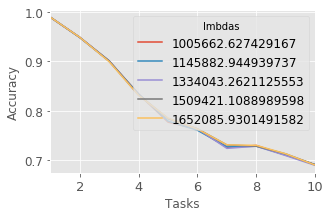

In [23]:
#fig, ax = plt.subplots(figsize=(4.5,2.5))
mpl.rcParams['figure.figsize'] = 4.75,3.0
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
df2.iloc[:,0:5].plot()
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ylabel('Accuracy')
plt.xlabel('Tasks')

Text(0.5,0,'Tasks')

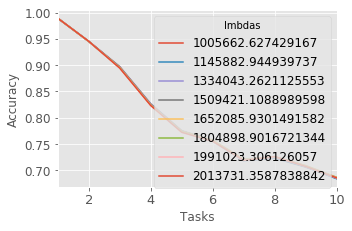

In [24]:
mpl.rcParams['figure.figsize'] = 5,3.25
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
df3.plot()
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ylabel('Accuracy')
plt.xlabel('Tasks')

In [25]:
df1.shape

(10, 8)

In [26]:
df1.iloc[:,0:5].values[:,0]

array([0.98799998, 0.93974999, 0.89083334, 0.81674999, 0.7704    ,
       0.74983334, 0.71485715, 0.71326923, 0.69802326, 0.67904255])

In [27]:
Min = df1.iloc[:,0:4].values[:,0]
Max = df2.iloc[:,0:4].values[:,0]
Mean = df3.iloc[:,0:4].values[:,0]
final_df = pd.DataFrame({'Min':Min, 'Max':Max, 'Mean':Mean})
final_df

,Max,Mean,Min
0,0.990000,0.989250,0.988000
1,0.949250,0.945167,0.939750
2,0.900833,0.896944,0.890833
3,0.834125,0.826104,0.816750
4,0.777100,0.774717,0.770400
5,0.762333,0.756306,0.749833
6,0.726000,0.718738,0.714857
7,0.729744,0.723654,0.713269
8,0.710116,0.706667,0.698023
9,0.690691,0.684379,0.679043


In [28]:
final_df.index.rename('Task', inplace=True)
final_df

,Max,Mean,Min
Task,,,
0,0.990000,0.989250,0.988000
1,0.949250,0.945167,0.939750
2,0.900833,0.896944,0.890833
3,0.834125,0.826104,0.816750
4,0.777100,0.774717,0.770400
5,0.762333,0.756306,0.749833
6,0.726000,0.718738,0.714857
7,0.729744,0.723654,0.713269
8,0.710116,0.706667,0.698023


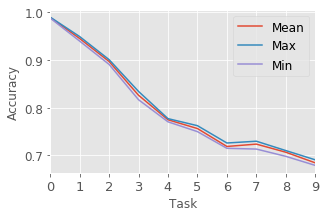

In [29]:
mpl.rcParams['figure.figsize'] = 4.75,3.0
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
ax = final_df.plot(y=['Mean','Max','Min'],x=final_df.index)
#ax.set_xticklabels([str((0,1)), str((2,3)), str((4,5)), str((6,7)), str((8,9))])
ax.set_xticks(final_df.index)
ax.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
ax.set_ylabel('Accuracy')
#plt.savefig('../outputs/tg_mnist_results_cl/buffered_accuracy.pdf', bbox_inches='tight')
#plt.savefig('../outputs/tg_mnist_results_cl/buffered_accuracy.png', bbox_inches='tight')
#plt.savefig('../outputs/tg_mnist_results_cl/buffered_accuracy.eps', bbox_inches='tight')
plt.show()